# 1. Model Initialization and Training

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

In [2]:
# Check for availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Function for Augmentation

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
# Define the transformation for training
class SVHNAugmentation:
  def __init__(self, rotation=0, crop_scale_range=(1.0, 1.0), aspect_ratio=(1.0, 1.0)):
    # Check if any augmentation parameters are different from the default
    if rotation != 0 or crop_scale_range != (1.0, 1.0) or aspect_ratio != (1.0, 1.0):
      self.transform = A.Compose([
          A.Rotate(limit=rotation),
          A.RandomResizedCrop(height=32, width=32, scale=crop_scale_range, ratio=aspect_ratio),
          A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
          ToTensorV2()
          ])
    else:
      self.transform = A.Compose([
          A.Resize(height=32, width=32),
          A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
          ToTensorV2()
          ])

  def __call__(self, img):
    img = np.array(img) # Ensure the image is a NumPy array
    return self.transform(image=img)['image']

train_transform = SVHNAugmentation(0, (1.0,1.0), (0.75,1.33))

# Define the transformation for testing (only normalization)
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
])

# Load the training dataset
train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=train_transform)

# Load the testing dataset
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


## Architecture of CNN (Using VGG)

In [5]:
# Define the smaller version of VGG (8 layers, max channel size 32)
class SmallVGG(nn.Module):
    def __init__(self):
        super(SmallVGG, self).__init__()
        self.conv_layers = nn.Sequential(

            # Input: (32 + 2) x (32 + 2) x 3
            # Output: 32 x 32 x 8
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.GroupNorm(2,8), nn.ReLU(),
            # Input: (32 + 2) x (32 + 2) x 8
            # Output: 32 x 32 x 16
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.GroupNorm(4,16), nn.ReLU(),
            # Input: 32 x 32 x 16
            # Output: 16 x 16 x 16
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.25), # 16x16

            # Input: (16 + 2) x (16 + 2) x 16
            # Output: 16 x 16 x 32
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.GroupNorm(8,32), nn.ReLU(),
            # Input: (16 + 2) x (16 + 2) x 32
            # Output: 16 x 16 x 32
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.GroupNorm(8,32), nn.ReLU(),
            # Input: 16 x 16 x 32
            # Output: 8 x 8 x 32
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.25), # 8x8

            # Input: (8 + 2) x (8 + 2) x 32
            # Output: 8 x 8 x 32
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.GroupNorm(8,32), nn.ReLU(),
            # Input: (8 + 2) x (8 + 2) x 32
            # Output: 8 x 8 x 32
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.GroupNorm(8,32), nn.ReLU(),
            # Input: 8 x 8 x 32
            # Output: 4 x 4 x 32
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.25) # 4x4
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, 10), # Output layer (10 classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc_layers(x)
        return x

## Function of Training and Evaluation

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
from tqdm import tqdm
import csv

# Training and evaluation function
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100, save_name='model'):
    train_losses = []
    test_losses = []
    test_accuracy = []
    test_f1 = []

    # For each epoch
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # ===== TRAINING =====
        # For each batch of images in "train_loader"
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * len(images)  # Total loss of this batch = average loss of each image in this batch * num of images in this batch

        # Average loss of images in this epoch
        train_losses.append(running_loss / len(train_loader.dataset))

        # ===== EVALUATION =====
        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        all_labels = []
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(images)

                _, preds = torch.max(outputs, 1)
                # Record the actual label for each instance
                all_labels.extend(labels.cpu().numpy())
                # Record the predicted label for each instance
                all_preds.extend(preds.cpu().numpy())
                # Record the probability of logits of each instance
                all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

        test_losses.append(test_loss / len(test_loader.dataset))
        test_accuracy.append(accuracy_score(all_labels, all_preds))
        test_f1.append(f1_score(all_labels, all_preds, average=None, labels=[i for i in range(10)]))

        # Print the result of each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.4f}")
    
    torch.save(model.state_dict(),f"{save_name}.pt")
    
    # Save training metrics to CSV
    with open(f"{save_name}_metrics.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        
        # Write header with relevant metrics
        writer.writerow(["Epoch", "Train Loss", "Test Loss", "Test Accuracy", "Test F1 Score"])
        
        # Write data for each epoch
        for epoch in range(num_epochs):
            writer.writerow([epoch + 1, train_losses[epoch], test_losses[epoch], test_accuracy[epoch], test_f1[epoch]])
    
    # Save predictions to CSV
    with open(f"{save_name}_predictions.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        
        # Write header for labels, predictions, and probabilities
        writer.writerow(["True Label", "Predicted Label"] + [f"Prob_{i}" for i in range(len(all_probs[0]))])  # For each class
        
        # Write data for each prediction (flatten the lists of labels, predictions, and probabilities)
        for true_label, pred_label, prob in zip(all_labels, all_preds, all_probs):
            writer.writerow([true_label, pred_label] + prob.tolist())  # Convert probabilities to list format

    
    return train_losses, test_losses, test_accuracy, test_f1, all_labels, all_preds, all_probs


## Function of Plotting Results

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_results(train_losses, test_losses, test_accuracy, test_f1, all_labels, all_preds, all_probs, num_epochs, num_classes=10):
    # Binarize the output for ROC curves
    all_labels_bin = label_binarize(all_labels, classes=[i for i in range(num_classes)])

    # Compute ROC AUC for each class
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), np.array(all_probs).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Create a figure with specified layout
    plt.figure(figsize=(20, 5))

    # First Row - Training and Testing Losses, Test Accuracy, F1 Score, ROC Curve
    plt.subplot(1, 4, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Losses')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(range(1, num_epochs + 1), test_accuracy, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    average_test_f1 = np.mean(test_f1, axis=1)  # Average F1 score across classes
    plt.subplot(1, 4, 3)
    plt.plot(range(1, num_epochs + 1), average_test_f1, label='F1 Score', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Epochs')
    plt.legend()

    plt.subplot(1, 4, 4)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.5f})')
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.5f})', color='deeppink', linestyle=':', linewidth=2)
    plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average (AUC = {roc_auc["macro"]:.5f})', color='navy', linestyle=':', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

    # Second Row - Accuracy per Class at Final Epoch
    plt.figure(figsize=(10, 5))
    final_accuracy_per_class = [accuracy_score(np.array(all_labels) == i, np.array(all_preds) == i) for i in range(num_classes)]
    plt.bar(range(num_classes), final_accuracy_per_class)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy per Class (Final Epoch)')
    plt.show()

    # Third Row - F1 Score per Class at Final Epoch
    plt.figure(figsize=(10, 5))
    final_f1_per_class = test_f1[-1]
    plt.bar(range(num_classes), final_f1_per_class, color='orange')
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Class (Final Epoch)')
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return


# 2. Running Initial Model

In [9]:
# Initialize model, loss function, and optimizer
model = SmallVGG().to(device)
# model.load_state_dict(torch.load("model.pt",weights_only=True))
criterion = nn.CrossEntropyLoss()

# Weight decay, also known as L2 regularization, is a technique used in training neural networks to prevent overfitting by adding a penalty term to the loss function
# This penalty term discourages the model from learning overly complex patterns that only work well on the training data but do not generalize to unseen data.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [10]:
# Example usage
num_epochs = 70
train_losses, test_losses, test_accuracy, test_f1, all_labels, all_preds, all_probs = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs, "initial")
initial_results = (train_losses, test_losses, test_accuracy, test_f1, all_labels, all_preds, all_probs)

100%|██████████| 573/573 [00:07<00:00, 72.15it/s]


Epoch [1/70], Train Loss: 1.0521, Test Loss: 0.4637, Test Accuracy: 0.8539


100%|██████████| 573/573 [00:07<00:00, 72.66it/s]


Epoch [2/70], Train Loss: 0.4727, Test Loss: 0.3255, Test Accuracy: 0.8999


100%|██████████| 573/573 [00:07<00:00, 73.68it/s]


Epoch [3/70], Train Loss: 0.3967, Test Loss: 0.2850, Test Accuracy: 0.9159


100%|██████████| 573/573 [00:07<00:00, 71.76it/s]


Epoch [4/70], Train Loss: 0.3599, Test Loss: 0.2628, Test Accuracy: 0.9231


100%|██████████| 573/573 [00:07<00:00, 73.98it/s]


Epoch [5/70], Train Loss: 0.3352, Test Loss: 0.2641, Test Accuracy: 0.9210


100%|██████████| 573/573 [00:07<00:00, 74.41it/s]


Epoch [6/70], Train Loss: 0.3155, Test Loss: 0.2332, Test Accuracy: 0.9321


100%|██████████| 573/573 [00:07<00:00, 74.06it/s]


Epoch [7/70], Train Loss: 0.2998, Test Loss: 0.2316, Test Accuracy: 0.9324


100%|██████████| 573/573 [00:07<00:00, 74.52it/s]


Epoch [8/70], Train Loss: 0.2863, Test Loss: 0.2266, Test Accuracy: 0.9348


100%|██████████| 573/573 [00:07<00:00, 74.17it/s]


Epoch [9/70], Train Loss: 0.2774, Test Loss: 0.2098, Test Accuracy: 0.9401


100%|██████████| 573/573 [00:07<00:00, 74.64it/s]


Epoch [10/70], Train Loss: 0.2689, Test Loss: 0.2059, Test Accuracy: 0.9418


100%|██████████| 573/573 [00:07<00:00, 74.49it/s]


Epoch [11/70], Train Loss: 0.2611, Test Loss: 0.2137, Test Accuracy: 0.9397


100%|██████████| 573/573 [00:07<00:00, 74.77it/s]


Epoch [12/70], Train Loss: 0.2540, Test Loss: 0.1921, Test Accuracy: 0.9462


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [13/70], Train Loss: 0.2507, Test Loss: 0.2035, Test Accuracy: 0.9437


100%|██████████| 573/573 [00:07<00:00, 75.02it/s]


Epoch [14/70], Train Loss: 0.2451, Test Loss: 0.2039, Test Accuracy: 0.9434


100%|██████████| 573/573 [00:07<00:00, 74.37it/s]


Epoch [15/70], Train Loss: 0.2397, Test Loss: 0.1893, Test Accuracy: 0.9478


100%|██████████| 573/573 [00:07<00:00, 74.58it/s]


Epoch [16/70], Train Loss: 0.2347, Test Loss: 0.1916, Test Accuracy: 0.9461


100%|██████████| 573/573 [00:07<00:00, 75.19it/s]


Epoch [17/70], Train Loss: 0.2295, Test Loss: 0.1845, Test Accuracy: 0.9488


100%|██████████| 573/573 [00:07<00:00, 74.33it/s]


Epoch [18/70], Train Loss: 0.2262, Test Loss: 0.1928, Test Accuracy: 0.9461


100%|██████████| 573/573 [00:07<00:00, 74.18it/s]


Epoch [19/70], Train Loss: 0.2205, Test Loss: 0.1831, Test Accuracy: 0.9499


100%|██████████| 573/573 [00:07<00:00, 74.49it/s]


Epoch [20/70], Train Loss: 0.2176, Test Loss: 0.1908, Test Accuracy: 0.9461


100%|██████████| 573/573 [00:07<00:00, 74.77it/s]


Epoch [21/70], Train Loss: 0.2166, Test Loss: 0.1851, Test Accuracy: 0.9486


100%|██████████| 573/573 [00:07<00:00, 74.43it/s]


Epoch [22/70], Train Loss: 0.2118, Test Loss: 0.1802, Test Accuracy: 0.9509


100%|██████████| 573/573 [00:07<00:00, 73.63it/s]


Epoch [23/70], Train Loss: 0.2109, Test Loss: 0.1780, Test Accuracy: 0.9525


100%|██████████| 573/573 [00:08<00:00, 69.82it/s]


Epoch [24/70], Train Loss: 0.2064, Test Loss: 0.1724, Test Accuracy: 0.9532


100%|██████████| 573/573 [00:07<00:00, 75.18it/s]


Epoch [25/70], Train Loss: 0.2049, Test Loss: 0.1786, Test Accuracy: 0.9521


100%|██████████| 573/573 [00:07<00:00, 74.82it/s]


Epoch [26/70], Train Loss: 0.2054, Test Loss: 0.2007, Test Accuracy: 0.9438


100%|██████████| 573/573 [00:07<00:00, 75.92it/s]


Epoch [27/70], Train Loss: 0.2019, Test Loss: 0.1814, Test Accuracy: 0.9500


100%|██████████| 573/573 [00:07<00:00, 75.73it/s]


Epoch [28/70], Train Loss: 0.2005, Test Loss: 0.1853, Test Accuracy: 0.9478


100%|██████████| 573/573 [00:07<00:00, 75.69it/s]


Epoch [29/70], Train Loss: 0.1945, Test Loss: 0.1901, Test Accuracy: 0.9473


100%|██████████| 573/573 [00:07<00:00, 75.93it/s]


Epoch [30/70], Train Loss: 0.1973, Test Loss: 0.1789, Test Accuracy: 0.9513


100%|██████████| 573/573 [00:07<00:00, 76.00it/s]


Epoch [31/70], Train Loss: 0.1958, Test Loss: 0.1770, Test Accuracy: 0.9516


100%|██████████| 573/573 [00:07<00:00, 76.14it/s]


Epoch [32/70], Train Loss: 0.1913, Test Loss: 0.1744, Test Accuracy: 0.9535


100%|██████████| 573/573 [00:07<00:00, 75.95it/s]


Epoch [33/70], Train Loss: 0.1895, Test Loss: 0.1770, Test Accuracy: 0.9513


100%|██████████| 573/573 [00:07<00:00, 75.37it/s]


Epoch [34/70], Train Loss: 0.1867, Test Loss: 0.1837, Test Accuracy: 0.9495


100%|██████████| 573/573 [00:07<00:00, 75.11it/s]


Epoch [35/70], Train Loss: 0.1855, Test Loss: 0.1807, Test Accuracy: 0.9509


100%|██████████| 573/573 [00:07<00:00, 75.24it/s]


Epoch [36/70], Train Loss: 0.1848, Test Loss: 0.1797, Test Accuracy: 0.9503


100%|██████████| 573/573 [00:07<00:00, 75.64it/s]


Epoch [37/70], Train Loss: 0.1856, Test Loss: 0.1896, Test Accuracy: 0.9488


100%|██████████| 573/573 [00:07<00:00, 75.74it/s]


Epoch [38/70], Train Loss: 0.1855, Test Loss: 0.1713, Test Accuracy: 0.9531


100%|██████████| 573/573 [00:07<00:00, 75.52it/s]


Epoch [39/70], Train Loss: 0.1836, Test Loss: 0.1771, Test Accuracy: 0.9522


100%|██████████| 573/573 [00:07<00:00, 75.78it/s]


Epoch [40/70], Train Loss: 0.1851, Test Loss: 0.1763, Test Accuracy: 0.9526


100%|██████████| 573/573 [00:07<00:00, 75.89it/s]


Epoch [41/70], Train Loss: 0.1796, Test Loss: 0.1740, Test Accuracy: 0.9542


100%|██████████| 573/573 [00:07<00:00, 75.31it/s]


Epoch [42/70], Train Loss: 0.1817, Test Loss: 0.1815, Test Accuracy: 0.9511


100%|██████████| 573/573 [00:07<00:00, 75.34it/s]


Epoch [43/70], Train Loss: 0.1757, Test Loss: 0.1743, Test Accuracy: 0.9523


100%|██████████| 573/573 [00:07<00:00, 74.85it/s]


Epoch [44/70], Train Loss: 0.1760, Test Loss: 0.1743, Test Accuracy: 0.9532


100%|██████████| 573/573 [00:08<00:00, 70.36it/s]


Epoch [45/70], Train Loss: 0.1753, Test Loss: 0.1812, Test Accuracy: 0.9516


100%|██████████| 573/573 [00:07<00:00, 75.77it/s]


Epoch [46/70], Train Loss: 0.1749, Test Loss: 0.1790, Test Accuracy: 0.9515


100%|██████████| 573/573 [00:07<00:00, 76.00it/s]


Epoch [47/70], Train Loss: 0.1734, Test Loss: 0.1803, Test Accuracy: 0.9519


100%|██████████| 573/573 [00:07<00:00, 75.74it/s]


Epoch [48/70], Train Loss: 0.1714, Test Loss: 0.1807, Test Accuracy: 0.9508


100%|██████████| 573/573 [00:07<00:00, 76.55it/s]


Epoch [49/70], Train Loss: 0.1738, Test Loss: 0.1717, Test Accuracy: 0.9530


100%|██████████| 573/573 [00:07<00:00, 76.40it/s]


Epoch [50/70], Train Loss: 0.1695, Test Loss: 0.1897, Test Accuracy: 0.9497


100%|██████████| 573/573 [00:07<00:00, 76.25it/s]


Epoch [51/70], Train Loss: 0.1707, Test Loss: 0.1802, Test Accuracy: 0.9506


100%|██████████| 573/573 [00:07<00:00, 75.92it/s]


Epoch [52/70], Train Loss: 0.1685, Test Loss: 0.1732, Test Accuracy: 0.9535


100%|██████████| 573/573 [00:07<00:00, 76.05it/s]


Epoch [53/70], Train Loss: 0.1674, Test Loss: 0.1831, Test Accuracy: 0.9508


100%|██████████| 573/573 [00:07<00:00, 75.64it/s]


Epoch [54/70], Train Loss: 0.1677, Test Loss: 0.1777, Test Accuracy: 0.9537


100%|██████████| 573/573 [00:07<00:00, 75.27it/s]


Epoch [55/70], Train Loss: 0.1679, Test Loss: 0.1776, Test Accuracy: 0.9523


100%|██████████| 573/573 [00:07<00:00, 76.05it/s]


Epoch [56/70], Train Loss: 0.1701, Test Loss: 0.1785, Test Accuracy: 0.9523


100%|██████████| 573/573 [00:07<00:00, 75.61it/s]


Epoch [57/70], Train Loss: 0.1644, Test Loss: 0.1702, Test Accuracy: 0.9541


100%|██████████| 573/573 [00:07<00:00, 75.69it/s]


Epoch [58/70], Train Loss: 0.1663, Test Loss: 0.1705, Test Accuracy: 0.9541


100%|██████████| 573/573 [00:07<00:00, 75.78it/s]


Epoch [59/70], Train Loss: 0.1624, Test Loss: 0.1737, Test Accuracy: 0.9539


100%|██████████| 573/573 [00:07<00:00, 76.25it/s]


Epoch [60/70], Train Loss: 0.1654, Test Loss: 0.1776, Test Accuracy: 0.9534


100%|██████████| 573/573 [00:07<00:00, 75.68it/s]


Epoch [61/70], Train Loss: 0.1646, Test Loss: 0.1756, Test Accuracy: 0.9521


100%|██████████| 573/573 [00:07<00:00, 75.89it/s]


Epoch [62/70], Train Loss: 0.1622, Test Loss: 0.1739, Test Accuracy: 0.9543


100%|██████████| 573/573 [00:07<00:00, 75.40it/s]


Epoch [63/70], Train Loss: 0.1607, Test Loss: 0.1863, Test Accuracy: 0.9499


100%|██████████| 573/573 [00:07<00:00, 75.85it/s]


Epoch [64/70], Train Loss: 0.1601, Test Loss: 0.1779, Test Accuracy: 0.9524


100%|██████████| 573/573 [00:07<00:00, 76.06it/s]


Epoch [65/70], Train Loss: 0.1608, Test Loss: 0.1738, Test Accuracy: 0.9541


100%|██████████| 573/573 [00:07<00:00, 75.58it/s]


Epoch [66/70], Train Loss: 0.1617, Test Loss: 0.1732, Test Accuracy: 0.9547


100%|██████████| 573/573 [00:07<00:00, 75.44it/s]


Epoch [67/70], Train Loss: 0.1602, Test Loss: 0.1792, Test Accuracy: 0.9523


100%|██████████| 573/573 [00:07<00:00, 75.44it/s]


Epoch [68/70], Train Loss: 0.1619, Test Loss: 0.1739, Test Accuracy: 0.9529


100%|██████████| 573/573 [00:07<00:00, 75.51it/s]


Epoch [69/70], Train Loss: 0.1597, Test Loss: 0.1721, Test Accuracy: 0.9545


100%|██████████| 573/573 [00:07<00:00, 75.63it/s]


Epoch [70/70], Train Loss: 0.1592, Test Loss: 0.1856, Test Accuracy: 0.9501


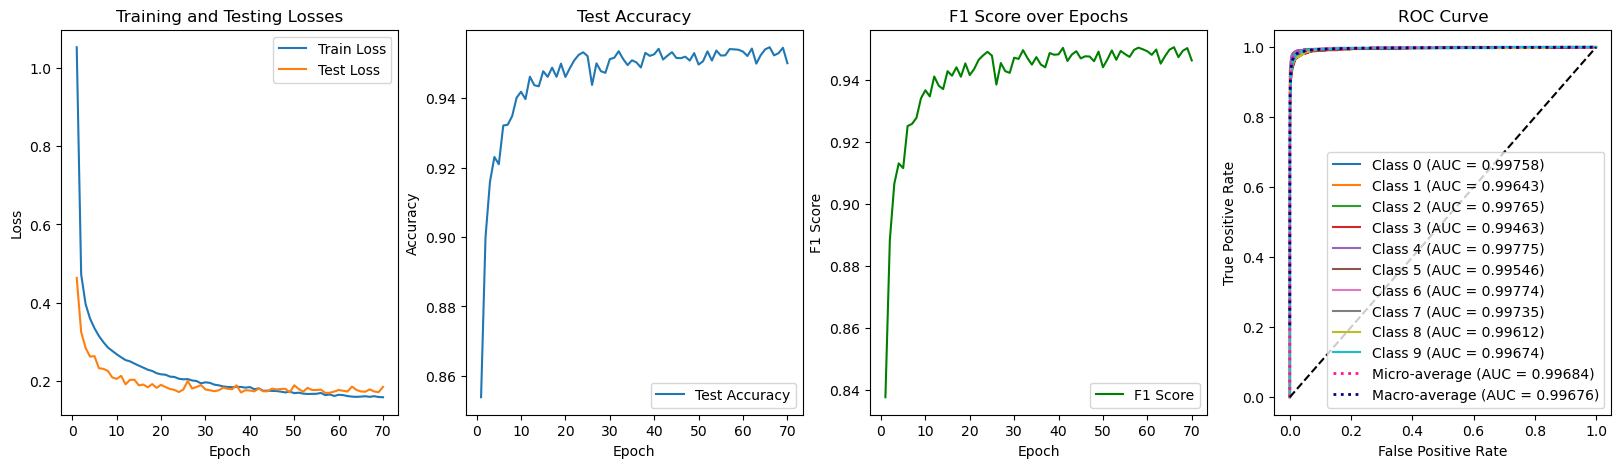

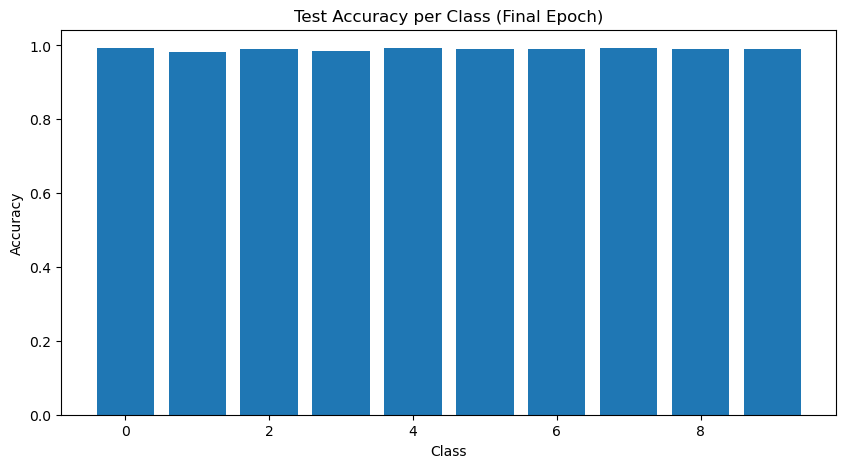

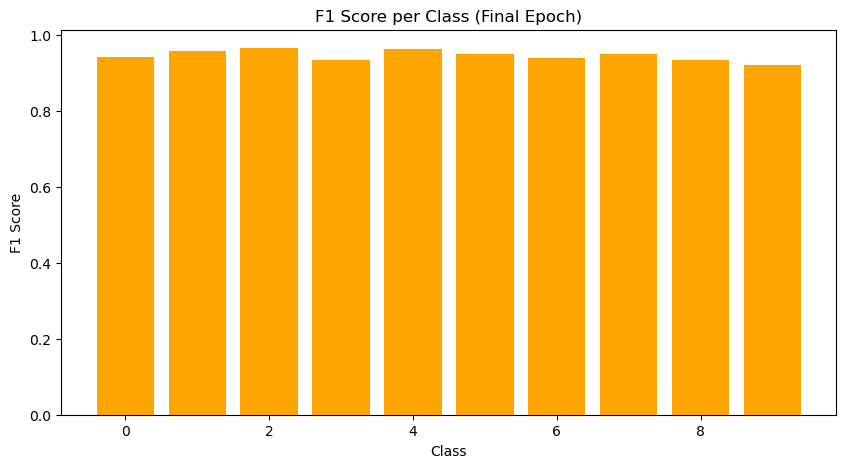

Confusion Matrix:
[[1675   17    9    3    1    3   24    3    5    4]
 [  17 4977   22   19   27    4    6   20    4    3]
 [   7   42 4007   39   21    2    1   15    8    7]
 [   6   37   26 2673    4   27    4    5   18   82]
 [   8   58   10    5 2424    3    5    4    2    4]
 [   5   20    7   52    7 2221   51    2    8   11]
 [  27   22    0   10    6   10 1879    3   18    2]
 [   2   90   30    6    3    3    1 1880    0    4]
 [  19   15    7   25    8    3   47    1 1520   15]
 [  44   15   26    8    5    7    4    0   10 1476]]


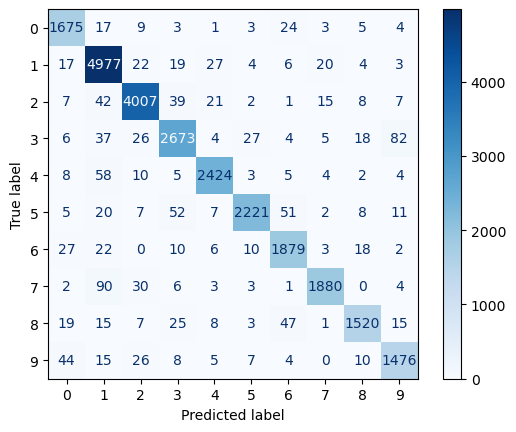

In [11]:
plot_results(train_losses, test_losses, test_accuracy, test_f1, all_labels, all_preds, all_probs, num_epochs, 10)


# Step 3: Model Performance Evaluation

# 3. Hyperparameter Tuning

## 3.1 Learning Rate (Initial: 0.001)

### Learning Rate = 0.0005

In [13]:
optimizer_3_1_1 = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [14]:
train_losses_3_1_1, test_losses_3_1_1, test_accuracy_3_1_1, test_f1_3_1_1, all_labels_3_1_1, all_preds_3_1_1, all_probs_3_1_1 = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer_3_1_1, num_epochs, 'lr0.0005')
results_3_1_1 = (train_losses_3_1_1, test_losses_3_1_1, test_accuracy_3_1_1, test_f1_3_1_1, all_labels_3_1_1, all_preds_3_1_1, all_probs_3_1_1)

100%|██████████| 573/573 [00:07<00:00, 76.46it/s]


Epoch [1/70], Train Loss: 0.1324, Test Loss: 0.1645, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 76.33it/s]


Epoch [2/70], Train Loss: 0.1243, Test Loss: 0.1637, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 76.22it/s]


Epoch [3/70], Train Loss: 0.1227, Test Loss: 0.1608, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 76.58it/s]


Epoch [4/70], Train Loss: 0.1218, Test Loss: 0.1632, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 76.28it/s]


Epoch [5/70], Train Loss: 0.1210, Test Loss: 0.1621, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 76.37it/s]


Epoch [6/70], Train Loss: 0.1175, Test Loss: 0.1628, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 76.22it/s]


Epoch [7/70], Train Loss: 0.1160, Test Loss: 0.1619, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 76.34it/s]


Epoch [8/70], Train Loss: 0.1160, Test Loss: 0.1612, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 76.52it/s]


Epoch [9/70], Train Loss: 0.1154, Test Loss: 0.1628, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 76.24it/s]


Epoch [10/70], Train Loss: 0.1161, Test Loss: 0.1625, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 76.62it/s]


Epoch [11/70], Train Loss: 0.1124, Test Loss: 0.1604, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 76.58it/s]


Epoch [12/70], Train Loss: 0.1128, Test Loss: 0.1611, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 76.29it/s]


Epoch [13/70], Train Loss: 0.1116, Test Loss: 0.1623, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 76.35it/s]


Epoch [14/70], Train Loss: 0.1100, Test Loss: 0.1639, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 76.87it/s]


Epoch [15/70], Train Loss: 0.1093, Test Loss: 0.1638, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 76.24it/s]


Epoch [16/70], Train Loss: 0.1099, Test Loss: 0.1618, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 76.62it/s]


Epoch [17/70], Train Loss: 0.1072, Test Loss: 0.1640, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 76.14it/s]


Epoch [18/70], Train Loss: 0.1092, Test Loss: 0.1600, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 72.43it/s]


Epoch [19/70], Train Loss: 0.1080, Test Loss: 0.1605, Test Accuracy: 0.9588


100%|██████████| 573/573 [00:07<00:00, 73.91it/s]


Epoch [20/70], Train Loss: 0.1073, Test Loss: 0.1606, Test Accuracy: 0.9590


100%|██████████| 573/573 [00:07<00:00, 74.80it/s]


Epoch [21/70], Train Loss: 0.1071, Test Loss: 0.1637, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.09it/s]


Epoch [22/70], Train Loss: 0.1077, Test Loss: 0.1618, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.06it/s]


Epoch [23/70], Train Loss: 0.1047, Test Loss: 0.1648, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.00it/s]


Epoch [24/70], Train Loss: 0.1055, Test Loss: 0.1613, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [25/70], Train Loss: 0.1050, Test Loss: 0.1644, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 74.59it/s]


Epoch [26/70], Train Loss: 0.1056, Test Loss: 0.1627, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [27/70], Train Loss: 0.1044, Test Loss: 0.1642, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 74.14it/s]


Epoch [28/70], Train Loss: 0.1035, Test Loss: 0.1638, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.76it/s]


Epoch [29/70], Train Loss: 0.1023, Test Loss: 0.1648, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [30/70], Train Loss: 0.1013, Test Loss: 0.1637, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.76it/s]


Epoch [31/70], Train Loss: 0.1023, Test Loss: 0.1644, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.11it/s]


Epoch [32/70], Train Loss: 0.1007, Test Loss: 0.1630, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 74.26it/s]


Epoch [33/70], Train Loss: 0.1011, Test Loss: 0.1642, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.40it/s]


Epoch [34/70], Train Loss: 0.1008, Test Loss: 0.1653, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.26it/s]


Epoch [35/70], Train Loss: 0.1008, Test Loss: 0.1651, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.46it/s]


Epoch [36/70], Train Loss: 0.1017, Test Loss: 0.1643, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.50it/s]


Epoch [37/70], Train Loss: 0.1020, Test Loss: 0.1651, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 73.91it/s]


Epoch [38/70], Train Loss: 0.1002, Test Loss: 0.1631, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.39it/s]


Epoch [39/70], Train Loss: 0.0997, Test Loss: 0.1662, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [40/70], Train Loss: 0.1004, Test Loss: 0.1649, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.29it/s]


Epoch [41/70], Train Loss: 0.0985, Test Loss: 0.1638, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.51it/s]


Epoch [42/70], Train Loss: 0.0978, Test Loss: 0.1641, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 74.88it/s]


Epoch [43/70], Train Loss: 0.0993, Test Loss: 0.1661, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.36it/s]


Epoch [44/70], Train Loss: 0.0982, Test Loss: 0.1652, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.98it/s]


Epoch [45/70], Train Loss: 0.0988, Test Loss: 0.1665, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 74.37it/s]


Epoch [46/70], Train Loss: 0.0978, Test Loss: 0.1647, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.84it/s]


Epoch [47/70], Train Loss: 0.0963, Test Loss: 0.1660, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 73.91it/s]


Epoch [48/70], Train Loss: 0.0965, Test Loss: 0.1642, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.06it/s]


Epoch [49/70], Train Loss: 0.0963, Test Loss: 0.1662, Test Accuracy: 0.9588


100%|██████████| 573/573 [00:07<00:00, 74.06it/s]


Epoch [50/70], Train Loss: 0.1000, Test Loss: 0.1662, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 73.89it/s]


Epoch [51/70], Train Loss: 0.0957, Test Loss: 0.1648, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.21it/s]


Epoch [52/70], Train Loss: 0.0956, Test Loss: 0.1651, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.03it/s]


Epoch [53/70], Train Loss: 0.0947, Test Loss: 0.1651, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.23it/s]


Epoch [54/70], Train Loss: 0.0952, Test Loss: 0.1654, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 74.58it/s]


Epoch [55/70], Train Loss: 0.0955, Test Loss: 0.1681, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 74.53it/s]


Epoch [56/70], Train Loss: 0.0932, Test Loss: 0.1665, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 74.60it/s]


Epoch [57/70], Train Loss: 0.0945, Test Loss: 0.1675, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.13it/s]


Epoch [58/70], Train Loss: 0.0944, Test Loss: 0.1656, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.57it/s]


Epoch [59/70], Train Loss: 0.0952, Test Loss: 0.1667, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.31it/s]


Epoch [60/70], Train Loss: 0.0932, Test Loss: 0.1660, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.50it/s]


Epoch [61/70], Train Loss: 0.0915, Test Loss: 0.1675, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 73.40it/s]


Epoch [62/70], Train Loss: 0.0946, Test Loss: 0.1674, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:08<00:00, 71.58it/s]


Epoch [63/70], Train Loss: 0.0947, Test Loss: 0.1674, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 71.83it/s]


Epoch [64/70], Train Loss: 0.0925, Test Loss: 0.1686, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:08<00:00, 68.90it/s]


Epoch [65/70], Train Loss: 0.0928, Test Loss: 0.1692, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:08<00:00, 69.13it/s]


Epoch [66/70], Train Loss: 0.0922, Test Loss: 0.1694, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:08<00:00, 70.42it/s]


Epoch [67/70], Train Loss: 0.0913, Test Loss: 0.1682, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:08<00:00, 70.22it/s]


Epoch [68/70], Train Loss: 0.0914, Test Loss: 0.1695, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:08<00:00, 69.89it/s]


Epoch [69/70], Train Loss: 0.0925, Test Loss: 0.1694, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 73.08it/s]


Epoch [70/70], Train Loss: 0.0908, Test Loss: 0.1669, Test Accuracy: 0.9579


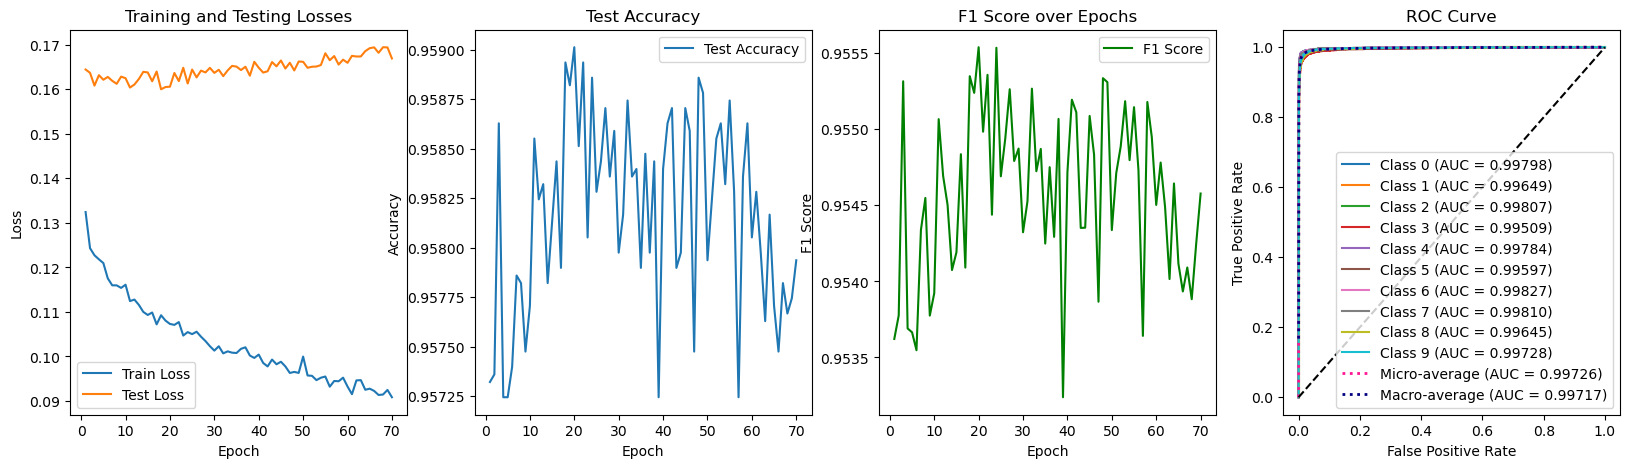

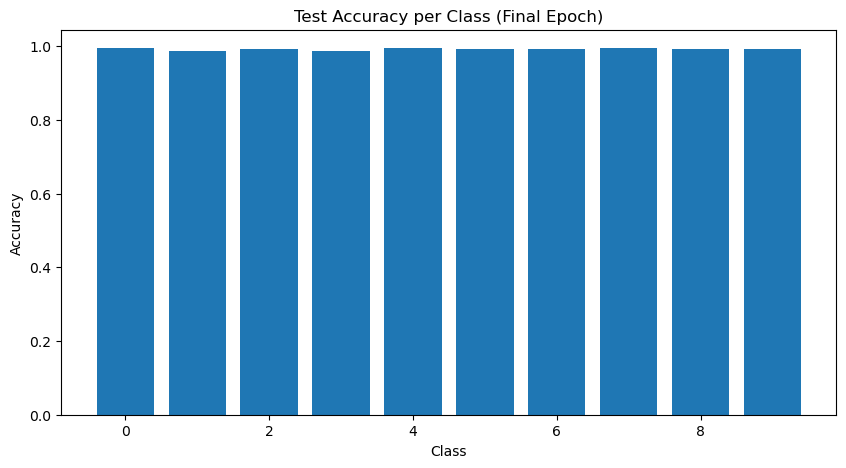

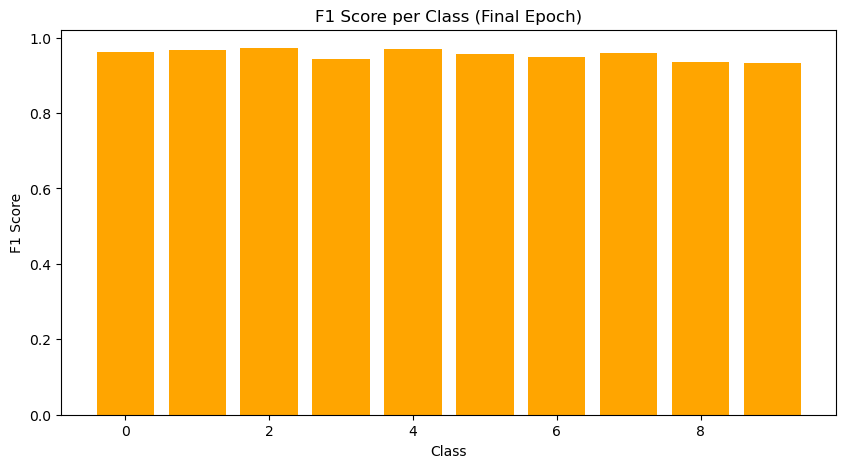

Confusion Matrix:
[[1688   11    5    5    1    3   14    4    7    6]
 [  16 4947   23   26   28    8    8   28   10    5]
 [   4   26 4029   33   14    8    3   15    8    9]
 [   5   20   21 2698    3   30    4    5   16   80]
 [   6   40   11    4 2433    4    9    4    6    6]
 [   2    9    6   36    3 2265   35    2    9   17]
 [  17    8    3    8    3   15 1895    3   23    2]
 [   1   54   18    8    5    3    1 1922    1    6]
 [   8   10    2   20    5    7   52    2 1536   18]
 [  18    7   22    6    4    4    2    0    8 1524]]


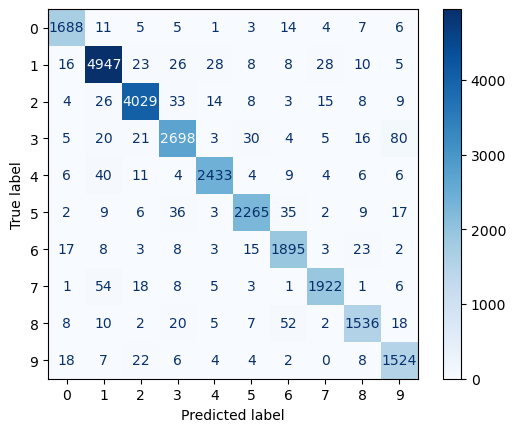

In [15]:
plot_results(train_losses_3_1_1, test_losses_3_1_1, test_accuracy_3_1_1, test_f1_3_1_1, all_labels_3_1_1, all_preds_3_1_1, all_probs_3_1_1, num_epochs, 10)

### Learning Rate = 0.005

In [16]:
optimizer_3_1_2 = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

In [17]:
train_losses_3_1_2, test_losses_3_1_2, test_accuracy_3_1_2, test_f1_3_1_2, all_labels_3_1_2, all_preds_3_1_2, all_probs_3_1_2 = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer_3_1_2, num_epochs, 'lr=0.005')
results_3_1_2 = (train_losses_3_1_2, test_losses_3_1_2, test_accuracy_3_1_2, test_f1_3_1_2, all_labels_3_1_2, all_preds_3_1_2, all_probs_3_1_2 )

100%|██████████| 573/573 [00:07<00:00, 74.64it/s]


Epoch [1/70], Train Loss: 0.3088, Test Loss: 0.2192, Test Accuracy: 0.9370


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [2/70], Train Loss: 0.2904, Test Loss: 0.2156, Test Accuracy: 0.9375


100%|██████████| 573/573 [00:07<00:00, 74.86it/s]


Epoch [3/70], Train Loss: 0.2842, Test Loss: 0.2528, Test Accuracy: 0.9269


100%|██████████| 573/573 [00:07<00:00, 74.74it/s]


Epoch [4/70], Train Loss: 0.2811, Test Loss: 0.2302, Test Accuracy: 0.9362


100%|██████████| 573/573 [00:07<00:00, 74.58it/s]


Epoch [5/70], Train Loss: 0.2765, Test Loss: 0.2108, Test Accuracy: 0.9404


100%|██████████| 573/573 [00:07<00:00, 74.54it/s]


Epoch [6/70], Train Loss: 0.2728, Test Loss: 0.2083, Test Accuracy: 0.9407


100%|██████████| 573/573 [00:07<00:00, 74.62it/s]


Epoch [7/70], Train Loss: 0.2747, Test Loss: 0.2334, Test Accuracy: 0.9346


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [8/70], Train Loss: 0.2737, Test Loss: 0.2095, Test Accuracy: 0.9416


100%|██████████| 573/573 [00:07<00:00, 74.64it/s]


Epoch [9/70], Train Loss: 0.2710, Test Loss: 0.2105, Test Accuracy: 0.9406


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [10/70], Train Loss: 0.2710, Test Loss: 0.1970, Test Accuracy: 0.9435


100%|██████████| 573/573 [00:07<00:00, 74.89it/s]


Epoch [11/70], Train Loss: 0.2685, Test Loss: 0.2013, Test Accuracy: 0.9450


100%|██████████| 573/573 [00:07<00:00, 74.91it/s]


Epoch [12/70], Train Loss: 0.2671, Test Loss: 0.2132, Test Accuracy: 0.9415


100%|██████████| 573/573 [00:07<00:00, 74.79it/s]


Epoch [13/70], Train Loss: 0.2682, Test Loss: 0.2147, Test Accuracy: 0.9421


100%|██████████| 573/573 [00:07<00:00, 74.87it/s]


Epoch [14/70], Train Loss: 0.2700, Test Loss: 0.2109, Test Accuracy: 0.9400


100%|██████████| 573/573 [00:07<00:00, 75.21it/s]


Epoch [15/70], Train Loss: 0.2677, Test Loss: 0.2147, Test Accuracy: 0.9393


100%|██████████| 573/573 [00:07<00:00, 74.87it/s]


Epoch [16/70], Train Loss: 0.2652, Test Loss: 0.1985, Test Accuracy: 0.9436


100%|██████████| 573/573 [00:07<00:00, 75.03it/s]


Epoch [17/70], Train Loss: 0.2667, Test Loss: 0.1951, Test Accuracy: 0.9448


100%|██████████| 573/573 [00:07<00:00, 74.98it/s]


Epoch [18/70], Train Loss: 0.2654, Test Loss: 0.2034, Test Accuracy: 0.9428


100%|██████████| 573/573 [00:07<00:00, 75.06it/s]


Epoch [19/70], Train Loss: 0.2645, Test Loss: 0.2001, Test Accuracy: 0.9428


100%|██████████| 573/573 [00:07<00:00, 74.48it/s]


Epoch [20/70], Train Loss: 0.2619, Test Loss: 0.1871, Test Accuracy: 0.9481


100%|██████████| 573/573 [00:07<00:00, 74.98it/s]


Epoch [21/70], Train Loss: 0.2656, Test Loss: 0.2036, Test Accuracy: 0.9419


100%|██████████| 573/573 [00:07<00:00, 74.88it/s]


Epoch [22/70], Train Loss: 0.2637, Test Loss: 0.2183, Test Accuracy: 0.9380


100%|██████████| 573/573 [00:07<00:00, 74.29it/s]


Epoch [23/70], Train Loss: 0.2591, Test Loss: 0.2175, Test Accuracy: 0.9383


100%|██████████| 573/573 [00:07<00:00, 74.95it/s]


Epoch [24/70], Train Loss: 0.2646, Test Loss: 0.1894, Test Accuracy: 0.9461


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [25/70], Train Loss: 0.2610, Test Loss: 0.2096, Test Accuracy: 0.9400


100%|██████████| 573/573 [00:07<00:00, 74.13it/s]


Epoch [26/70], Train Loss: 0.2651, Test Loss: 0.1913, Test Accuracy: 0.9472


100%|██████████| 573/573 [00:07<00:00, 74.36it/s]


Epoch [27/70], Train Loss: 0.2565, Test Loss: 0.2186, Test Accuracy: 0.9386


100%|██████████| 573/573 [00:07<00:00, 74.61it/s]


Epoch [28/70], Train Loss: 0.2610, Test Loss: 0.1989, Test Accuracy: 0.9440


100%|██████████| 573/573 [00:07<00:00, 74.44it/s]


Epoch [29/70], Train Loss: 0.2609, Test Loss: 0.2066, Test Accuracy: 0.9406


100%|██████████| 573/573 [00:07<00:00, 74.99it/s]


Epoch [30/70], Train Loss: 0.2591, Test Loss: 0.2002, Test Accuracy: 0.9438


100%|██████████| 573/573 [00:07<00:00, 74.80it/s]


Epoch [31/70], Train Loss: 0.2567, Test Loss: 0.2111, Test Accuracy: 0.9394


100%|██████████| 573/573 [00:07<00:00, 75.28it/s]


Epoch [32/70], Train Loss: 0.2590, Test Loss: 0.2206, Test Accuracy: 0.9368


100%|██████████| 573/573 [00:07<00:00, 74.30it/s]


Epoch [33/70], Train Loss: 0.2603, Test Loss: 0.1843, Test Accuracy: 0.9471


100%|██████████| 573/573 [00:07<00:00, 74.85it/s]


Epoch [34/70], Train Loss: 0.2563, Test Loss: 0.2069, Test Accuracy: 0.9421


100%|██████████| 573/573 [00:07<00:00, 74.84it/s]


Epoch [35/70], Train Loss: 0.2570, Test Loss: 0.1925, Test Accuracy: 0.9451


100%|██████████| 573/573 [00:07<00:00, 74.95it/s]


Epoch [36/70], Train Loss: 0.2576, Test Loss: 0.2001, Test Accuracy: 0.9431


100%|██████████| 573/573 [00:07<00:00, 74.60it/s]


Epoch [37/70], Train Loss: 0.2583, Test Loss: 0.1916, Test Accuracy: 0.9455


100%|██████████| 573/573 [00:07<00:00, 74.68it/s]


Epoch [38/70], Train Loss: 0.2537, Test Loss: 0.2140, Test Accuracy: 0.9387


100%|██████████| 573/573 [00:07<00:00, 74.60it/s]


Epoch [39/70], Train Loss: 0.2584, Test Loss: 0.1938, Test Accuracy: 0.9435


100%|██████████| 573/573 [00:07<00:00, 74.63it/s]


Epoch [40/70], Train Loss: 0.2559, Test Loss: 0.1896, Test Accuracy: 0.9469


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [41/70], Train Loss: 0.2566, Test Loss: 0.1956, Test Accuracy: 0.9451


100%|██████████| 573/573 [00:07<00:00, 74.40it/s]


Epoch [42/70], Train Loss: 0.2549, Test Loss: 0.1835, Test Accuracy: 0.9488


100%|██████████| 573/573 [00:07<00:00, 74.65it/s]


Epoch [43/70], Train Loss: 0.2559, Test Loss: 0.1909, Test Accuracy: 0.9456


100%|██████████| 573/573 [00:07<00:00, 74.65it/s]


Epoch [44/70], Train Loss: 0.2533, Test Loss: 0.1906, Test Accuracy: 0.9465


100%|██████████| 573/573 [00:07<00:00, 75.14it/s]


Epoch [45/70], Train Loss: 0.2552, Test Loss: 0.2032, Test Accuracy: 0.9433


100%|██████████| 573/573 [00:07<00:00, 74.81it/s]


Epoch [46/70], Train Loss: 0.2545, Test Loss: 0.1863, Test Accuracy: 0.9485


100%|██████████| 573/573 [00:07<00:00, 74.85it/s]


Epoch [47/70], Train Loss: 0.2535, Test Loss: 0.1924, Test Accuracy: 0.9469


100%|██████████| 573/573 [00:07<00:00, 74.52it/s]


Epoch [48/70], Train Loss: 0.2555, Test Loss: 0.1865, Test Accuracy: 0.9484


100%|██████████| 573/573 [00:07<00:00, 75.14it/s]


Epoch [49/70], Train Loss: 0.2521, Test Loss: 0.1914, Test Accuracy: 0.9464


100%|██████████| 573/573 [00:07<00:00, 75.06it/s]


Epoch [50/70], Train Loss: 0.2539, Test Loss: 0.1876, Test Accuracy: 0.9468


100%|██████████| 573/573 [00:07<00:00, 74.50it/s]


Epoch [51/70], Train Loss: 0.2525, Test Loss: 0.1948, Test Accuracy: 0.9436


100%|██████████| 573/573 [00:07<00:00, 74.49it/s]


Epoch [52/70], Train Loss: 0.2533, Test Loss: 0.1925, Test Accuracy: 0.9440


100%|██████████| 573/573 [00:07<00:00, 74.92it/s]


Epoch [53/70], Train Loss: 0.2516, Test Loss: 0.2000, Test Accuracy: 0.9436


100%|██████████| 573/573 [00:07<00:00, 74.28it/s]


Epoch [54/70], Train Loss: 0.2541, Test Loss: 0.1859, Test Accuracy: 0.9476


100%|██████████| 573/573 [00:07<00:00, 74.54it/s]


Epoch [55/70], Train Loss: 0.2577, Test Loss: 0.1985, Test Accuracy: 0.9453


100%|██████████| 573/573 [00:07<00:00, 75.01it/s]


Epoch [56/70], Train Loss: 0.2509, Test Loss: 0.1922, Test Accuracy: 0.9463


100%|██████████| 573/573 [00:07<00:00, 75.30it/s]


Epoch [57/70], Train Loss: 0.2525, Test Loss: 0.1926, Test Accuracy: 0.9457


100%|██████████| 573/573 [00:07<00:00, 75.08it/s]


Epoch [58/70], Train Loss: 0.2526, Test Loss: 0.1914, Test Accuracy: 0.9458


100%|██████████| 573/573 [00:07<00:00, 74.79it/s]


Epoch [59/70], Train Loss: 0.2513, Test Loss: 0.2074, Test Accuracy: 0.9427


100%|██████████| 573/573 [00:07<00:00, 74.31it/s]


Epoch [60/70], Train Loss: 0.2535, Test Loss: 0.2025, Test Accuracy: 0.9412


100%|██████████| 573/573 [00:07<00:00, 75.33it/s]


Epoch [61/70], Train Loss: 0.2528, Test Loss: 0.1844, Test Accuracy: 0.9482


100%|██████████| 573/573 [00:07<00:00, 75.28it/s]


Epoch [62/70], Train Loss: 0.2544, Test Loss: 0.2059, Test Accuracy: 0.9418


100%|██████████| 573/573 [00:07<00:00, 74.57it/s]


Epoch [63/70], Train Loss: 0.2521, Test Loss: 0.1839, Test Accuracy: 0.9486


100%|██████████| 573/573 [00:07<00:00, 75.03it/s]


Epoch [64/70], Train Loss: 0.2494, Test Loss: 0.2018, Test Accuracy: 0.9436


100%|██████████| 573/573 [00:07<00:00, 75.05it/s]


Epoch [65/70], Train Loss: 0.2487, Test Loss: 0.2106, Test Accuracy: 0.9415


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [66/70], Train Loss: 0.2492, Test Loss: 0.1983, Test Accuracy: 0.9439


100%|██████████| 573/573 [00:07<00:00, 74.37it/s]


Epoch [67/70], Train Loss: 0.2544, Test Loss: 0.1896, Test Accuracy: 0.9462


100%|██████████| 573/573 [00:07<00:00, 74.92it/s]


Epoch [68/70], Train Loss: 0.2509, Test Loss: 0.1982, Test Accuracy: 0.9440


100%|██████████| 573/573 [00:07<00:00, 75.09it/s]


Epoch [69/70], Train Loss: 0.2523, Test Loss: 0.1810, Test Accuracy: 0.9484


100%|██████████| 573/573 [00:07<00:00, 75.08it/s]


Epoch [70/70], Train Loss: 0.2528, Test Loss: 0.2060, Test Accuracy: 0.9406


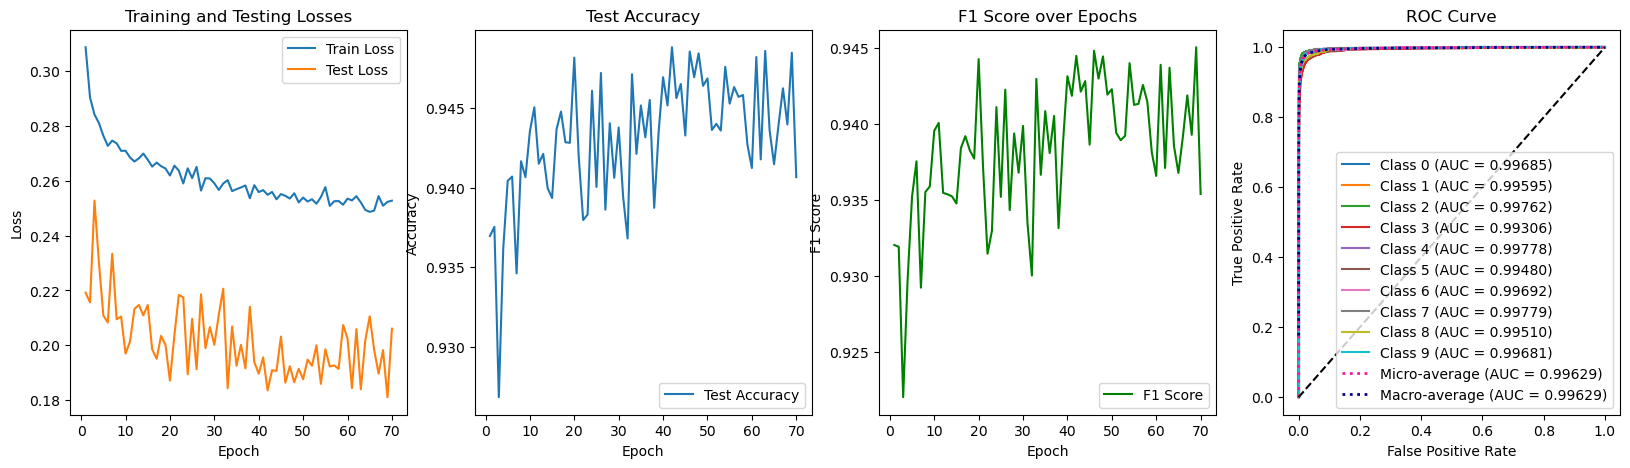

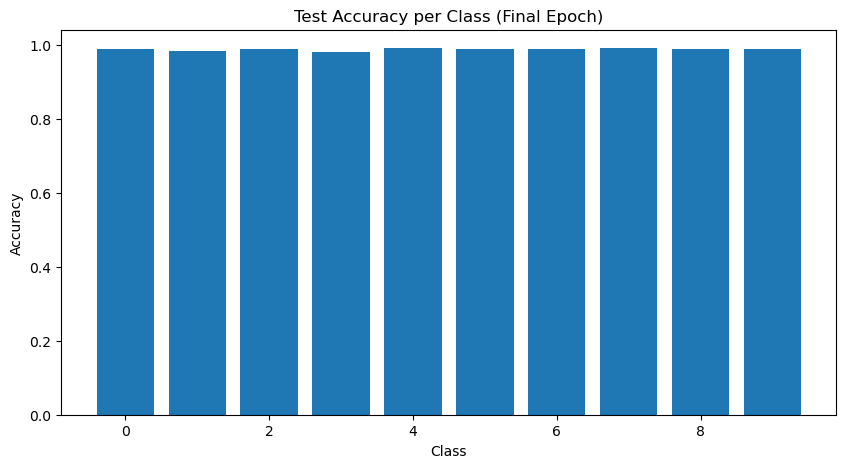

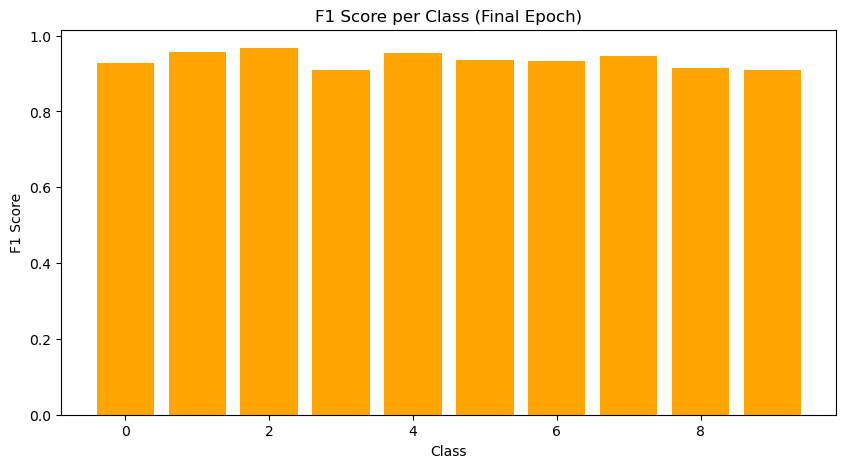

Confusion Matrix:
[[1687   14    2    6    0    3    7    4    1   20]
 [  50 4870   12   32   55    9    8   54    3    6]
 [   9   39 3951   59   21    6    1   41    0   22]
 [   6   14   12 2707    8   21    3    8    5   98]
 [   9   42   10   16 2416    4    3    9    2   12]
 [   7    9    8  123   10 2177   29    3    3   15]
 [  48   13    2   29   14   26 1826    6   10    3]
 [   3   59    8   13    2    4    1 1926    0    3]
 [  32   12    4   72   14   14   59    4 1418   31]
 [  39   11   11   10    5    5    1    2    2 1509]]


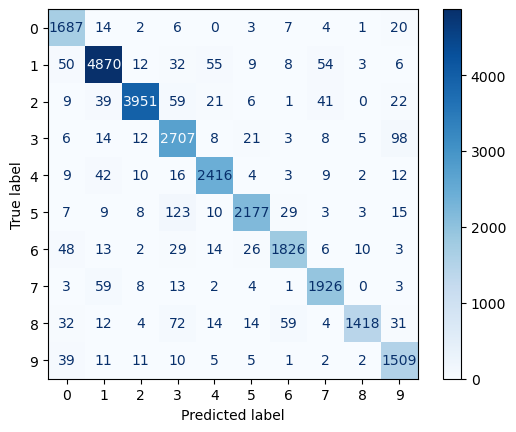

In [18]:
plot_results(train_losses_3_1_2, test_losses_3_1_2, test_accuracy_3_1_2, test_f1_3_1_2, all_labels_3_1_2, all_preds_3_1_2, all_probs_3_1_2 , num_epochs, 10)

## 3.2 Batch Size (Initial = 128)

### Batch Size = 64

In [21]:
train_loader_3_2_1 = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_3_2_1 = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
train_losses_3_2_1, test_losses_3_2_1, test_accuracy_3_2_1, test_f1_3_2_1, all_labels_3_2_1,  all_preds_3_2_1, all_probs_3_2_1 = train_and_evaluate(model, train_loader_3_2_1, test_loader_3_2_1, criterion, optimizer, num_epochs, 'batch64')
results_3_2_1 = (train_losses_3_2_1, test_losses_3_2_1, test_accuracy_3_2_1, test_f1_3_2_1, all_labels_3_2_1,  all_preds_3_2_1, all_probs_3_2_1)

100%|██████████| 1145/1145 [00:08<00:00, 131.55it/s]


Epoch [1/70], Train Loss: 0.2035, Test Loss: 0.1627, Test Accuracy: 0.9559


100%|██████████| 1145/1145 [00:08<00:00, 133.76it/s]


Epoch [2/70], Train Loss: 0.1957, Test Loss: 0.1602, Test Accuracy: 0.9561


100%|██████████| 1145/1145 [00:08<00:00, 133.59it/s]


Epoch [3/70], Train Loss: 0.1896, Test Loss: 0.1601, Test Accuracy: 0.9561


100%|██████████| 1145/1145 [00:08<00:00, 130.43it/s]


Epoch [4/70], Train Loss: 0.1873, Test Loss: 0.1528, Test Accuracy: 0.9592


100%|██████████| 1145/1145 [00:08<00:00, 130.09it/s]


Epoch [5/70], Train Loss: 0.1842, Test Loss: 0.1638, Test Accuracy: 0.9570


100%|██████████| 1145/1145 [00:08<00:00, 129.90it/s]


Epoch [6/70], Train Loss: 0.1865, Test Loss: 0.1601, Test Accuracy: 0.9566


100%|██████████| 1145/1145 [00:08<00:00, 132.09it/s]


Epoch [7/70], Train Loss: 0.1828, Test Loss: 0.1494, Test Accuracy: 0.9597


100%|██████████| 1145/1145 [00:08<00:00, 130.95it/s]


Epoch [8/70], Train Loss: 0.1808, Test Loss: 0.1625, Test Accuracy: 0.9561


100%|██████████| 1145/1145 [00:08<00:00, 130.61it/s]


Epoch [9/70], Train Loss: 0.1815, Test Loss: 0.1598, Test Accuracy: 0.9565


100%|██████████| 1145/1145 [00:08<00:00, 131.61it/s]


Epoch [10/70], Train Loss: 0.1792, Test Loss: 0.1568, Test Accuracy: 0.9581


100%|██████████| 1145/1145 [00:08<00:00, 130.54it/s]


Epoch [11/70], Train Loss: 0.1762, Test Loss: 0.1593, Test Accuracy: 0.9581


100%|██████████| 1145/1145 [00:08<00:00, 132.02it/s]


Epoch [12/70], Train Loss: 0.1776, Test Loss: 0.1570, Test Accuracy: 0.9576


100%|██████████| 1145/1145 [00:08<00:00, 133.09it/s]


Epoch [13/70], Train Loss: 0.1733, Test Loss: 0.1593, Test Accuracy: 0.9581


100%|██████████| 1145/1145 [00:08<00:00, 130.94it/s]


Epoch [14/70], Train Loss: 0.1738, Test Loss: 0.1648, Test Accuracy: 0.9556


100%|██████████| 1145/1145 [00:08<00:00, 131.61it/s]


Epoch [15/70], Train Loss: 0.1766, Test Loss: 0.1609, Test Accuracy: 0.9571


100%|██████████| 1145/1145 [00:08<00:00, 131.66it/s]


Epoch [16/70], Train Loss: 0.1720, Test Loss: 0.1609, Test Accuracy: 0.9569


100%|██████████| 1145/1145 [00:08<00:00, 132.73it/s]


Epoch [17/70], Train Loss: 0.1745, Test Loss: 0.1511, Test Accuracy: 0.9600


100%|██████████| 1145/1145 [00:08<00:00, 132.89it/s]


Epoch [18/70], Train Loss: 0.1746, Test Loss: 0.1585, Test Accuracy: 0.9569


100%|██████████| 1145/1145 [00:08<00:00, 131.16it/s]


Epoch [19/70], Train Loss: 0.1731, Test Loss: 0.1557, Test Accuracy: 0.9578


100%|██████████| 1145/1145 [00:08<00:00, 130.39it/s]


Epoch [20/70], Train Loss: 0.1739, Test Loss: 0.1593, Test Accuracy: 0.9572


100%|██████████| 1145/1145 [00:08<00:00, 132.30it/s]


Epoch [21/70], Train Loss: 0.1731, Test Loss: 0.1549, Test Accuracy: 0.9578


100%|██████████| 1145/1145 [00:08<00:00, 130.33it/s]


Epoch [22/70], Train Loss: 0.1723, Test Loss: 0.1541, Test Accuracy: 0.9570


100%|██████████| 1145/1145 [00:08<00:00, 132.86it/s]


Epoch [23/70], Train Loss: 0.1741, Test Loss: 0.1561, Test Accuracy: 0.9575


100%|██████████| 1145/1145 [00:08<00:00, 131.43it/s]


Epoch [24/70], Train Loss: 0.1741, Test Loss: 0.1522, Test Accuracy: 0.9582


100%|██████████| 1145/1145 [00:08<00:00, 133.18it/s]


Epoch [25/70], Train Loss: 0.1712, Test Loss: 0.1641, Test Accuracy: 0.9552


100%|██████████| 1145/1145 [00:08<00:00, 132.82it/s]


Epoch [26/70], Train Loss: 0.1713, Test Loss: 0.1558, Test Accuracy: 0.9571


100%|██████████| 1145/1145 [00:08<00:00, 131.06it/s]


Epoch [27/70], Train Loss: 0.1724, Test Loss: 0.1643, Test Accuracy: 0.9554


100%|██████████| 1145/1145 [00:08<00:00, 132.51it/s]


Epoch [28/70], Train Loss: 0.1702, Test Loss: 0.1597, Test Accuracy: 0.9570


100%|██████████| 1145/1145 [00:08<00:00, 132.20it/s]


Epoch [29/70], Train Loss: 0.1693, Test Loss: 0.1618, Test Accuracy: 0.9546


100%|██████████| 1145/1145 [00:08<00:00, 131.61it/s]


Epoch [30/70], Train Loss: 0.1720, Test Loss: 0.1670, Test Accuracy: 0.9546


100%|██████████| 1145/1145 [00:08<00:00, 131.56it/s]


Epoch [31/70], Train Loss: 0.1703, Test Loss: 0.1611, Test Accuracy: 0.9570


100%|██████████| 1145/1145 [00:08<00:00, 133.71it/s]


Epoch [32/70], Train Loss: 0.1690, Test Loss: 0.1689, Test Accuracy: 0.9533


100%|██████████| 1145/1145 [00:08<00:00, 133.26it/s]


Epoch [33/70], Train Loss: 0.1709, Test Loss: 0.1573, Test Accuracy: 0.9568


100%|██████████| 1145/1145 [00:08<00:00, 132.52it/s]


Epoch [34/70], Train Loss: 0.1713, Test Loss: 0.1624, Test Accuracy: 0.9563


100%|██████████| 1145/1145 [00:08<00:00, 131.06it/s]


Epoch [35/70], Train Loss: 0.1697, Test Loss: 0.1554, Test Accuracy: 0.9573


100%|██████████| 1145/1145 [00:08<00:00, 133.41it/s]


Epoch [36/70], Train Loss: 0.1699, Test Loss: 0.1599, Test Accuracy: 0.9556


100%|██████████| 1145/1145 [00:08<00:00, 133.08it/s]


Epoch [37/70], Train Loss: 0.1708, Test Loss: 0.1623, Test Accuracy: 0.9559


100%|██████████| 1145/1145 [00:08<00:00, 131.73it/s]


Epoch [38/70], Train Loss: 0.1688, Test Loss: 0.1604, Test Accuracy: 0.9566


100%|██████████| 1145/1145 [00:08<00:00, 132.29it/s]


Epoch [39/70], Train Loss: 0.1698, Test Loss: 0.1628, Test Accuracy: 0.9572


100%|██████████| 1145/1145 [00:08<00:00, 132.11it/s]


Epoch [40/70], Train Loss: 0.1717, Test Loss: 0.1597, Test Accuracy: 0.9573


100%|██████████| 1145/1145 [00:08<00:00, 130.91it/s]


Epoch [41/70], Train Loss: 0.1706, Test Loss: 0.1572, Test Accuracy: 0.9574


100%|██████████| 1145/1145 [00:08<00:00, 133.40it/s]


Epoch [42/70], Train Loss: 0.1678, Test Loss: 0.1560, Test Accuracy: 0.9573


100%|██████████| 1145/1145 [00:08<00:00, 131.86it/s]


Epoch [43/70], Train Loss: 0.1704, Test Loss: 0.1515, Test Accuracy: 0.9583


100%|██████████| 1145/1145 [00:08<00:00, 130.68it/s]


Epoch [44/70], Train Loss: 0.1688, Test Loss: 0.1580, Test Accuracy: 0.9574


100%|██████████| 1145/1145 [00:08<00:00, 131.37it/s]


Epoch [45/70], Train Loss: 0.1700, Test Loss: 0.1648, Test Accuracy: 0.9554


100%|██████████| 1145/1145 [00:08<00:00, 132.32it/s]


Epoch [46/70], Train Loss: 0.1682, Test Loss: 0.1623, Test Accuracy: 0.9557


100%|██████████| 1145/1145 [00:08<00:00, 132.14it/s]


Epoch [47/70], Train Loss: 0.1696, Test Loss: 0.1547, Test Accuracy: 0.9584


100%|██████████| 1145/1145 [00:08<00:00, 130.84it/s]


Epoch [48/70], Train Loss: 0.1682, Test Loss: 0.1599, Test Accuracy: 0.9573


100%|██████████| 1145/1145 [00:08<00:00, 130.79it/s]


Epoch [49/70], Train Loss: 0.1700, Test Loss: 0.1628, Test Accuracy: 0.9559


100%|██████████| 1145/1145 [00:08<00:00, 132.90it/s]


Epoch [50/70], Train Loss: 0.1689, Test Loss: 0.1620, Test Accuracy: 0.9575


100%|██████████| 1145/1145 [00:08<00:00, 131.75it/s]


Epoch [51/70], Train Loss: 0.1701, Test Loss: 0.1639, Test Accuracy: 0.9553


100%|██████████| 1145/1145 [00:08<00:00, 132.79it/s]


Epoch [52/70], Train Loss: 0.1696, Test Loss: 0.1630, Test Accuracy: 0.9562


100%|██████████| 1145/1145 [00:08<00:00, 132.07it/s]


Epoch [53/70], Train Loss: 0.1685, Test Loss: 0.1558, Test Accuracy: 0.9573


100%|██████████| 1145/1145 [00:08<00:00, 131.80it/s]


Epoch [54/70], Train Loss: 0.1680, Test Loss: 0.1729, Test Accuracy: 0.9535


100%|██████████| 1145/1145 [00:08<00:00, 131.77it/s]


Epoch [55/70], Train Loss: 0.1666, Test Loss: 0.1582, Test Accuracy: 0.9564


100%|██████████| 1145/1145 [00:08<00:00, 131.02it/s]


Epoch [56/70], Train Loss: 0.1698, Test Loss: 0.1602, Test Accuracy: 0.9562


100%|██████████| 1145/1145 [00:08<00:00, 132.47it/s]


Epoch [57/70], Train Loss: 0.1676, Test Loss: 0.1549, Test Accuracy: 0.9569


100%|██████████| 1145/1145 [00:08<00:00, 133.04it/s]


Epoch [58/70], Train Loss: 0.1683, Test Loss: 0.1609, Test Accuracy: 0.9561


100%|██████████| 1145/1145 [00:08<00:00, 132.88it/s]


Epoch [59/70], Train Loss: 0.1679, Test Loss: 0.1574, Test Accuracy: 0.9569


100%|██████████| 1145/1145 [00:08<00:00, 132.02it/s]


Epoch [60/70], Train Loss: 0.1666, Test Loss: 0.1547, Test Accuracy: 0.9581


100%|██████████| 1145/1145 [00:08<00:00, 130.50it/s]


Epoch [61/70], Train Loss: 0.1680, Test Loss: 0.1607, Test Accuracy: 0.9558


100%|██████████| 1145/1145 [00:08<00:00, 130.92it/s]


Epoch [62/70], Train Loss: 0.1662, Test Loss: 0.1586, Test Accuracy: 0.9577


100%|██████████| 1145/1145 [00:08<00:00, 131.37it/s]


Epoch [63/70], Train Loss: 0.1689, Test Loss: 0.1536, Test Accuracy: 0.9593


100%|██████████| 1145/1145 [00:08<00:00, 132.21it/s]


Epoch [64/70], Train Loss: 0.1659, Test Loss: 0.1550, Test Accuracy: 0.9576


100%|██████████| 1145/1145 [00:08<00:00, 130.73it/s]


Epoch [65/70], Train Loss: 0.1648, Test Loss: 0.1495, Test Accuracy: 0.9592


100%|██████████| 1145/1145 [00:08<00:00, 131.43it/s]


Epoch [66/70], Train Loss: 0.1661, Test Loss: 0.1664, Test Accuracy: 0.9564


100%|██████████| 1145/1145 [00:08<00:00, 131.29it/s]


Epoch [67/70], Train Loss: 0.1669, Test Loss: 0.1632, Test Accuracy: 0.9568


100%|██████████| 1145/1145 [00:08<00:00, 132.12it/s]


Epoch [68/70], Train Loss: 0.1688, Test Loss: 0.1602, Test Accuracy: 0.9561


100%|██████████| 1145/1145 [00:08<00:00, 132.11it/s]


Epoch [69/70], Train Loss: 0.1659, Test Loss: 0.1688, Test Accuracy: 0.9536


100%|██████████| 1145/1145 [00:08<00:00, 133.65it/s]


Epoch [70/70], Train Loss: 0.1681, Test Loss: 0.1648, Test Accuracy: 0.9541


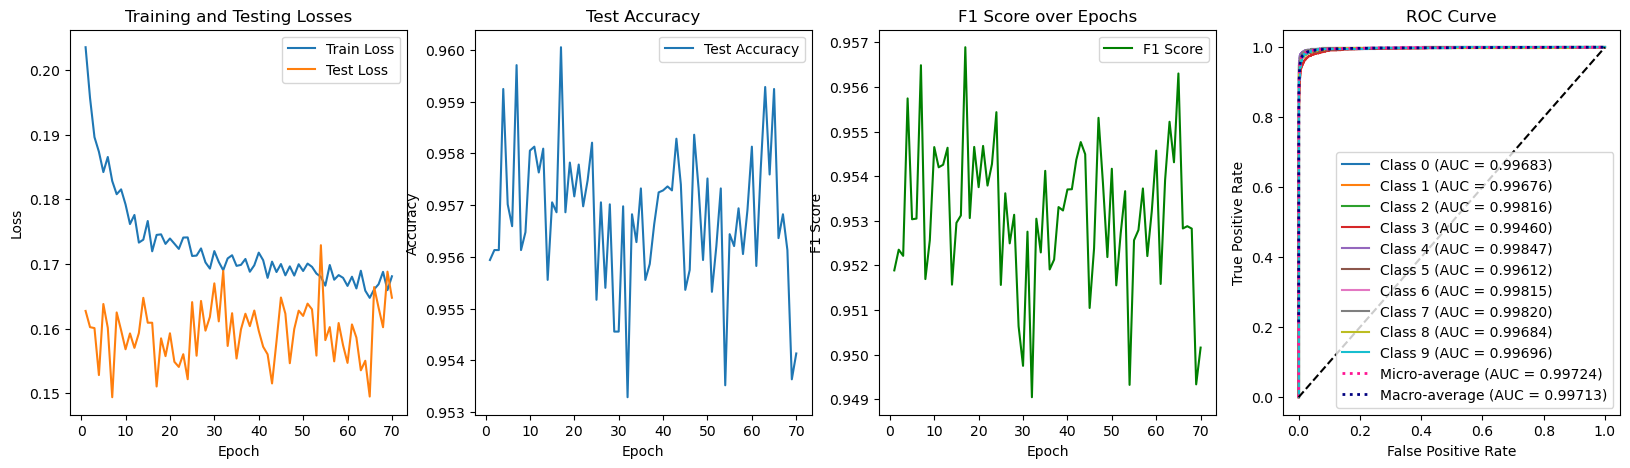

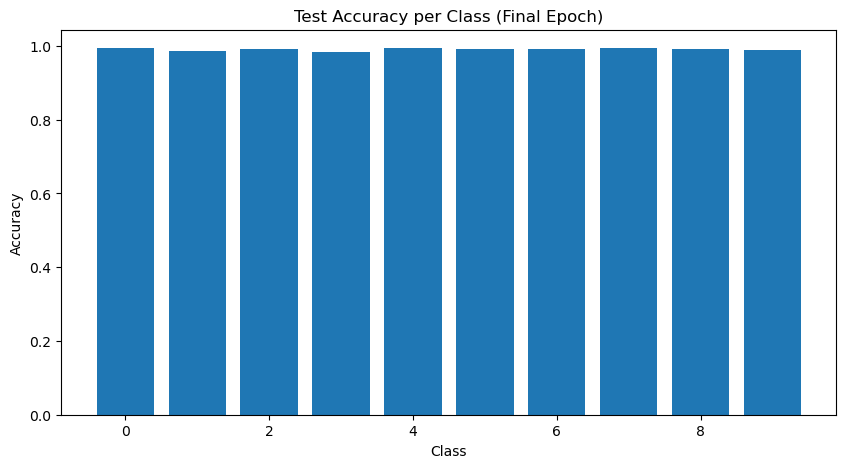

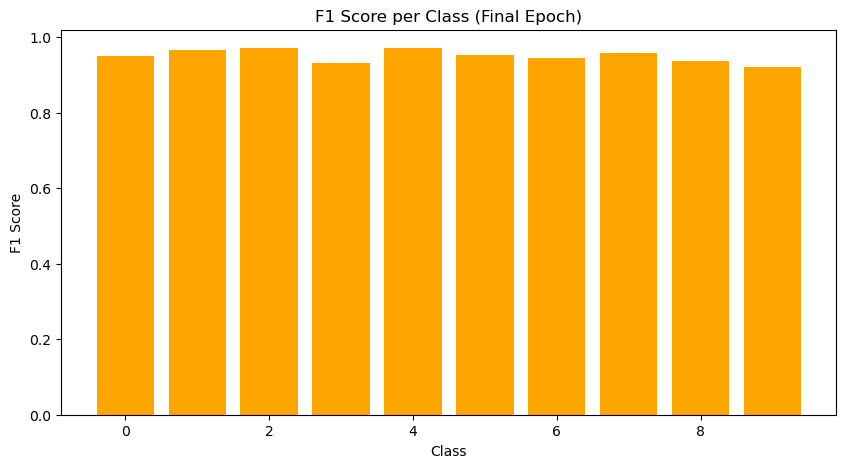

Confusion Matrix:
[[1672   14    5    5    1    4   24    3    7    9]
 [  21 4951   11   33   31    7    8   26    6    5]
 [   4   28 3982   65   11    5    6   17    8   23]
 [   6   15   10 2714    3   24    4    2   18   86]
 [   5   32    7   12 2438    4    5    3    5   12]
 [   4   10    5   63    3 2237   37    2    6   17]
 [  20   14    1    7    5   16 1899    1   13    1]
 [   2   65   17   13    3    3    1 1907    3    5]
 [  10    9    3   20    6    8   58    0 1525   21]
 [  30   10   15   10    3    5    1    1    7 1513]]


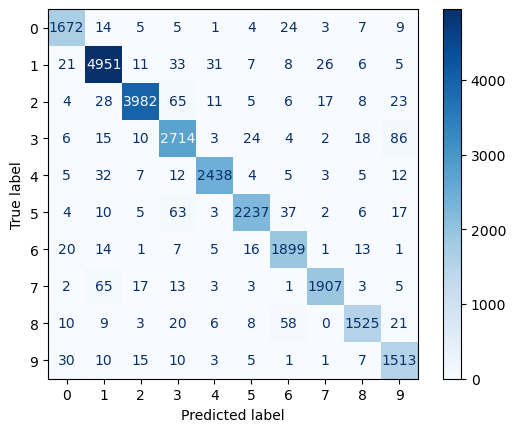

In [23]:
plot_results(train_losses_3_2_1, test_losses_3_2_1, test_accuracy_3_2_1, test_f1_3_2_1, all_labels_3_2_1,  all_preds_3_2_1, all_probs_3_2_1, num_epochs, 10)

### Batch Size = 256

In [24]:
train_loader_3_2_2 = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader_3_2_2 = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [25]:
train_losses_3_2_2, test_losses_3_2_2, test_accuracy_3_2_2, test_f1_3_2_2, all_labels_3_2_2, all_preds_3_2_2, all_probs_3_2_2 = train_and_evaluate(model, train_loader_3_2_2, test_loader_3_2_2, criterion, optimizer, num_epochs, 'batch256')
results_3_2_2 = (train_losses_3_2_2, test_losses_3_2_2, test_accuracy_3_2_2, test_f1_3_2_2, all_labels_3_2_2, all_preds_3_2_2, all_probs_3_2_2 )

100%|██████████| 287/287 [00:07<00:00, 39.01it/s]


Epoch [1/70], Train Loss: 0.1455, Test Loss: 0.1524, Test Accuracy: 0.9598


100%|██████████| 287/287 [00:07<00:00, 38.99it/s]


Epoch [2/70], Train Loss: 0.1370, Test Loss: 0.1582, Test Accuracy: 0.9579


100%|██████████| 287/287 [00:07<00:00, 39.18it/s]


Epoch [3/70], Train Loss: 0.1381, Test Loss: 0.1528, Test Accuracy: 0.9588


100%|██████████| 287/287 [00:07<00:00, 38.61it/s]


Epoch [4/70], Train Loss: 0.1383, Test Loss: 0.1466, Test Accuracy: 0.9607


100%|██████████| 287/287 [00:07<00:00, 39.45it/s]


Epoch [5/70], Train Loss: 0.1377, Test Loss: 0.1502, Test Accuracy: 0.9597


100%|██████████| 287/287 [00:07<00:00, 39.26it/s]


Epoch [6/70], Train Loss: 0.1375, Test Loss: 0.1481, Test Accuracy: 0.9610


100%|██████████| 287/287 [00:07<00:00, 39.42it/s]


Epoch [7/70], Train Loss: 0.1373, Test Loss: 0.1524, Test Accuracy: 0.9604


100%|██████████| 287/287 [00:07<00:00, 39.47it/s]


Epoch [8/70], Train Loss: 0.1371, Test Loss: 0.1526, Test Accuracy: 0.9592


100%|██████████| 287/287 [00:07<00:00, 39.26it/s]


Epoch [9/70], Train Loss: 0.1401, Test Loss: 0.1519, Test Accuracy: 0.9597


100%|██████████| 287/287 [00:07<00:00, 39.62it/s]


Epoch [10/70], Train Loss: 0.1361, Test Loss: 0.1544, Test Accuracy: 0.9583


100%|██████████| 287/287 [00:07<00:00, 39.30it/s]


Epoch [11/70], Train Loss: 0.1374, Test Loss: 0.1479, Test Accuracy: 0.9604


100%|██████████| 287/287 [00:07<00:00, 39.67it/s]


Epoch [12/70], Train Loss: 0.1379, Test Loss: 0.1543, Test Accuracy: 0.9596


100%|██████████| 287/287 [00:07<00:00, 39.55it/s]


Epoch [13/70], Train Loss: 0.1352, Test Loss: 0.1514, Test Accuracy: 0.9604


100%|██████████| 287/287 [00:07<00:00, 39.45it/s]


Epoch [14/70], Train Loss: 0.1355, Test Loss: 0.1565, Test Accuracy: 0.9594


100%|██████████| 287/287 [00:07<00:00, 39.49it/s]


Epoch [15/70], Train Loss: 0.1391, Test Loss: 0.1530, Test Accuracy: 0.9587


100%|██████████| 287/287 [00:07<00:00, 39.46it/s]


Epoch [16/70], Train Loss: 0.1354, Test Loss: 0.1514, Test Accuracy: 0.9598


100%|██████████| 287/287 [00:07<00:00, 39.58it/s]


Epoch [17/70], Train Loss: 0.1376, Test Loss: 0.1558, Test Accuracy: 0.9597


100%|██████████| 287/287 [00:07<00:00, 39.50it/s]


Epoch [18/70], Train Loss: 0.1372, Test Loss: 0.1514, Test Accuracy: 0.9606


100%|██████████| 287/287 [00:07<00:00, 39.71it/s]


Epoch [19/70], Train Loss: 0.1366, Test Loss: 0.1510, Test Accuracy: 0.9599


100%|██████████| 287/287 [00:07<00:00, 39.48it/s]


Epoch [20/70], Train Loss: 0.1355, Test Loss: 0.1560, Test Accuracy: 0.9587


100%|██████████| 287/287 [00:07<00:00, 39.66it/s]


Epoch [21/70], Train Loss: 0.1380, Test Loss: 0.1548, Test Accuracy: 0.9589


100%|██████████| 287/287 [00:07<00:00, 39.79it/s]


Epoch [22/70], Train Loss: 0.1368, Test Loss: 0.1549, Test Accuracy: 0.9582


100%|██████████| 287/287 [00:07<00:00, 39.42it/s]


Epoch [23/70], Train Loss: 0.1383, Test Loss: 0.1519, Test Accuracy: 0.9604


100%|██████████| 287/287 [00:07<00:00, 39.69it/s]


Epoch [24/70], Train Loss: 0.1368, Test Loss: 0.1546, Test Accuracy: 0.9582


100%|██████████| 287/287 [00:07<00:00, 39.67it/s]


Epoch [25/70], Train Loss: 0.1378, Test Loss: 0.1551, Test Accuracy: 0.9578


100%|██████████| 287/287 [00:07<00:00, 39.67it/s]


Epoch [26/70], Train Loss: 0.1341, Test Loss: 0.1555, Test Accuracy: 0.9600


100%|██████████| 287/287 [00:07<00:00, 39.64it/s]


Epoch [27/70], Train Loss: 0.1365, Test Loss: 0.1577, Test Accuracy: 0.9595


100%|██████████| 287/287 [00:07<00:00, 39.70it/s]


Epoch [28/70], Train Loss: 0.1403, Test Loss: 0.1559, Test Accuracy: 0.9589


100%|██████████| 287/287 [00:07<00:00, 39.63it/s]


Epoch [29/70], Train Loss: 0.1349, Test Loss: 0.1561, Test Accuracy: 0.9581


100%|██████████| 287/287 [00:07<00:00, 39.54it/s]


Epoch [30/70], Train Loss: 0.1357, Test Loss: 0.1521, Test Accuracy: 0.9608


100%|██████████| 287/287 [00:07<00:00, 39.44it/s]


Epoch [31/70], Train Loss: 0.1351, Test Loss: 0.1582, Test Accuracy: 0.9590


100%|██████████| 287/287 [00:07<00:00, 39.61it/s]


Epoch [32/70], Train Loss: 0.1345, Test Loss: 0.1549, Test Accuracy: 0.9599


100%|██████████| 287/287 [00:07<00:00, 39.68it/s]


Epoch [33/70], Train Loss: 0.1352, Test Loss: 0.1528, Test Accuracy: 0.9598


100%|██████████| 287/287 [00:07<00:00, 39.64it/s]


Epoch [34/70], Train Loss: 0.1344, Test Loss: 0.1612, Test Accuracy: 0.9582


100%|██████████| 287/287 [00:07<00:00, 39.71it/s]


Epoch [35/70], Train Loss: 0.1367, Test Loss: 0.1504, Test Accuracy: 0.9614


100%|██████████| 287/287 [00:07<00:00, 39.54it/s]


Epoch [36/70], Train Loss: 0.1352, Test Loss: 0.1511, Test Accuracy: 0.9604


100%|██████████| 287/287 [00:07<00:00, 39.64it/s]


Epoch [37/70], Train Loss: 0.1360, Test Loss: 0.1588, Test Accuracy: 0.9593


100%|██████████| 287/287 [00:07<00:00, 39.75it/s]


Epoch [38/70], Train Loss: 0.1368, Test Loss: 0.1558, Test Accuracy: 0.9592


100%|██████████| 287/287 [00:07<00:00, 39.51it/s]


Epoch [39/70], Train Loss: 0.1365, Test Loss: 0.1545, Test Accuracy: 0.9588


100%|██████████| 287/287 [00:07<00:00, 39.32it/s]


Epoch [40/70], Train Loss: 0.1365, Test Loss: 0.1487, Test Accuracy: 0.9607


100%|██████████| 287/287 [00:07<00:00, 39.50it/s]


Epoch [41/70], Train Loss: 0.1348, Test Loss: 0.1523, Test Accuracy: 0.9595


100%|██████████| 287/287 [00:07<00:00, 39.53it/s]


Epoch [42/70], Train Loss: 0.1353, Test Loss: 0.1545, Test Accuracy: 0.9600


100%|██████████| 287/287 [00:07<00:00, 39.50it/s]


Epoch [43/70], Train Loss: 0.1325, Test Loss: 0.1547, Test Accuracy: 0.9581


100%|██████████| 287/287 [00:07<00:00, 39.43it/s]


Epoch [44/70], Train Loss: 0.1346, Test Loss: 0.1568, Test Accuracy: 0.9590


100%|██████████| 287/287 [00:07<00:00, 39.62it/s]


Epoch [45/70], Train Loss: 0.1346, Test Loss: 0.1629, Test Accuracy: 0.9583


100%|██████████| 287/287 [00:07<00:00, 39.36it/s]


Epoch [46/70], Train Loss: 0.1351, Test Loss: 0.1641, Test Accuracy: 0.9579


100%|██████████| 287/287 [00:07<00:00, 39.42it/s]


Epoch [47/70], Train Loss: 0.1349, Test Loss: 0.1493, Test Accuracy: 0.9604


100%|██████████| 287/287 [00:07<00:00, 39.76it/s]


Epoch [48/70], Train Loss: 0.1347, Test Loss: 0.1615, Test Accuracy: 0.9579


100%|██████████| 287/287 [00:07<00:00, 39.55it/s]


Epoch [49/70], Train Loss: 0.1349, Test Loss: 0.1630, Test Accuracy: 0.9573


100%|██████████| 287/287 [00:07<00:00, 39.61it/s]


Epoch [50/70], Train Loss: 0.1356, Test Loss: 0.1542, Test Accuracy: 0.9595


100%|██████████| 287/287 [00:07<00:00, 39.23it/s]


Epoch [51/70], Train Loss: 0.1327, Test Loss: 0.1615, Test Accuracy: 0.9582


100%|██████████| 287/287 [00:07<00:00, 39.59it/s]


Epoch [52/70], Train Loss: 0.1338, Test Loss: 0.1557, Test Accuracy: 0.9600


100%|██████████| 287/287 [00:07<00:00, 39.50it/s]


Epoch [53/70], Train Loss: 0.1343, Test Loss: 0.1553, Test Accuracy: 0.9602


100%|██████████| 287/287 [00:07<00:00, 39.36it/s]


Epoch [54/70], Train Loss: 0.1338, Test Loss: 0.1541, Test Accuracy: 0.9600


100%|██████████| 287/287 [00:07<00:00, 39.14it/s]


Epoch [55/70], Train Loss: 0.1358, Test Loss: 0.1527, Test Accuracy: 0.9603


100%|██████████| 287/287 [00:07<00:00, 39.58it/s]


Epoch [56/70], Train Loss: 0.1328, Test Loss: 0.1589, Test Accuracy: 0.9585


100%|██████████| 287/287 [00:07<00:00, 39.70it/s]


Epoch [57/70], Train Loss: 0.1330, Test Loss: 0.1498, Test Accuracy: 0.9602


100%|██████████| 287/287 [00:07<00:00, 39.50it/s]


Epoch [58/70], Train Loss: 0.1347, Test Loss: 0.1505, Test Accuracy: 0.9600


100%|██████████| 287/287 [00:07<00:00, 39.54it/s]


Epoch [59/70], Train Loss: 0.1350, Test Loss: 0.1530, Test Accuracy: 0.9602


100%|██████████| 287/287 [00:07<00:00, 39.49it/s]


Epoch [60/70], Train Loss: 0.1307, Test Loss: 0.1571, Test Accuracy: 0.9594


100%|██████████| 287/287 [00:07<00:00, 39.54it/s]


Epoch [61/70], Train Loss: 0.1331, Test Loss: 0.1529, Test Accuracy: 0.9593


100%|██████████| 287/287 [00:07<00:00, 39.42it/s]


Epoch [62/70], Train Loss: 0.1313, Test Loss: 0.1593, Test Accuracy: 0.9582


100%|██████████| 287/287 [00:07<00:00, 39.50it/s]


Epoch [63/70], Train Loss: 0.1326, Test Loss: 0.1617, Test Accuracy: 0.9579


100%|██████████| 287/287 [00:07<00:00, 39.72it/s]


Epoch [64/70], Train Loss: 0.1323, Test Loss: 0.1539, Test Accuracy: 0.9603


100%|██████████| 287/287 [00:07<00:00, 39.39it/s]


Epoch [65/70], Train Loss: 0.1300, Test Loss: 0.1552, Test Accuracy: 0.9597


100%|██████████| 287/287 [00:07<00:00, 39.69it/s]


Epoch [66/70], Train Loss: 0.1327, Test Loss: 0.1613, Test Accuracy: 0.9582


100%|██████████| 287/287 [00:07<00:00, 39.62it/s]


Epoch [67/70], Train Loss: 0.1306, Test Loss: 0.1556, Test Accuracy: 0.9598


100%|██████████| 287/287 [00:07<00:00, 39.37it/s]


Epoch [68/70], Train Loss: 0.1333, Test Loss: 0.1544, Test Accuracy: 0.9598


100%|██████████| 287/287 [00:07<00:00, 39.79it/s]


Epoch [69/70], Train Loss: 0.1316, Test Loss: 0.1592, Test Accuracy: 0.9580


100%|██████████| 287/287 [00:07<00:00, 39.57it/s]


Epoch [70/70], Train Loss: 0.1334, Test Loss: 0.1587, Test Accuracy: 0.9595


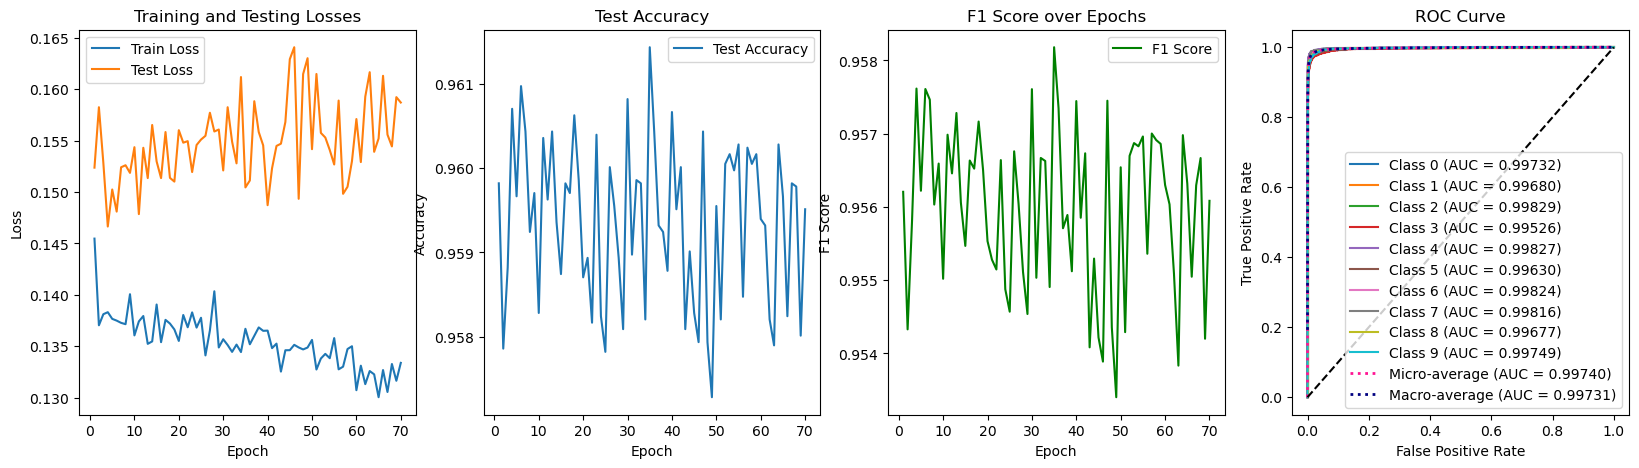

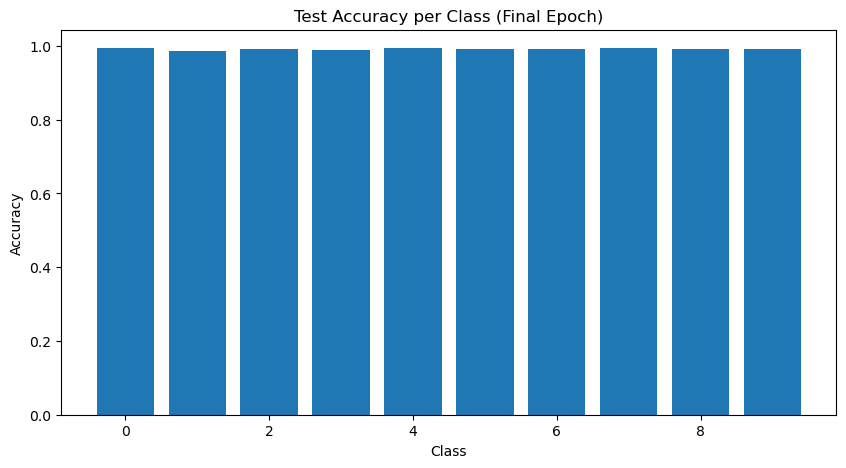

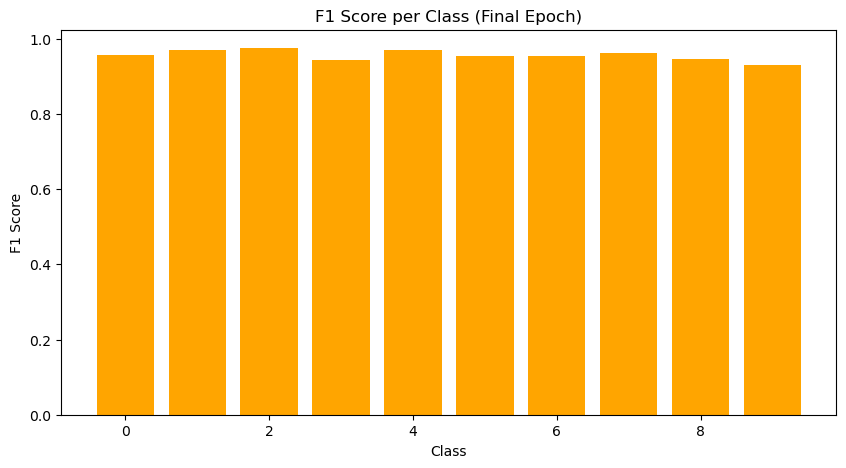

Confusion Matrix:
[[1686   10    4    2    1    4   11    4    7   15]
 [  20 4950   18   20   33    6   10   28   10    4]
 [   4   22 4034   33   10    3    3   20    8   12]
 [   5   12   14 2704    5   35    7    3   27   70]
 [   8   32    6   10 2446    2    4    4    4    7]
 [   4   10    7   50    2 2236   45    3   12   15]
 [  17   14    2    5    6    6 1905    2   18    2]
 [   1   54   17    4    3    2    1 1933    0    4]
 [  12   10    4    9    5    2   31    1 1575   11]
 [  26    9   20    8    6    3    2    3    9 1509]]


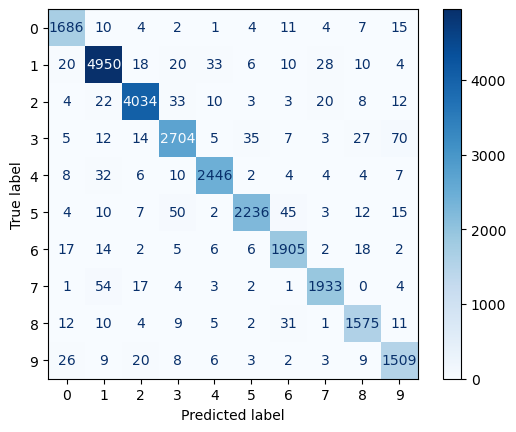

In [26]:
plot_results(train_losses_3_2_2, test_losses_3_2_2, test_accuracy_3_2_2, test_f1_3_2_2, all_labels_3_2_2, all_preds_3_2_2, all_probs_3_2_2 , num_epochs, 10)

## 3.3 Number of Epochs (Initial = 70)

### Num of Epochs = 35

In [27]:
num_epochs_3_3_1 = 35

In [28]:
train_losses_3_3_1, test_losses_3_3_1, test_accuracy_3_3_1, test_f1_3_3_1, all_labels_3_3_1, all_preds_3_3_1, all_probs_3_3_1 = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs_3_3_1, 'epc15')
results_3_3_1 = (train_losses_3_3_1, test_losses_3_3_1, test_accuracy_3_3_1, test_f1_3_3_1, all_labels_3_3_1, all_preds_3_3_1, all_probs_3_3_1)

100%|██████████| 573/573 [00:07<00:00, 74.52it/s]


Epoch [1/35], Train Loss: 0.1530, Test Loss: 0.1655, Test Accuracy: 0.9552


100%|██████████| 573/573 [00:07<00:00, 74.77it/s]


Epoch [2/35], Train Loss: 0.1517, Test Loss: 0.1591, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 74.72it/s]


Epoch [3/35], Train Loss: 0.1488, Test Loss: 0.1640, Test Accuracy: 0.9561


100%|██████████| 573/573 [00:07<00:00, 74.86it/s]


Epoch [4/35], Train Loss: 0.1476, Test Loss: 0.1631, Test Accuracy: 0.9562


100%|██████████| 573/573 [00:07<00:00, 74.73it/s]


Epoch [5/35], Train Loss: 0.1468, Test Loss: 0.1579, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.89it/s]


Epoch [6/35], Train Loss: 0.1457, Test Loss: 0.1619, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.90it/s]


Epoch [7/35], Train Loss: 0.1468, Test Loss: 0.1683, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.61it/s]


Epoch [8/35], Train Loss: 0.1487, Test Loss: 0.1575, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.57it/s]


Epoch [9/35], Train Loss: 0.1473, Test Loss: 0.1592, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 74.27it/s]


Epoch [10/35], Train Loss: 0.1465, Test Loss: 0.1589, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.72it/s]


Epoch [11/35], Train Loss: 0.1480, Test Loss: 0.1648, Test Accuracy: 0.9560


100%|██████████| 573/573 [00:07<00:00, 73.98it/s]


Epoch [12/35], Train Loss: 0.1455, Test Loss: 0.1669, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.78it/s]


Epoch [13/35], Train Loss: 0.1483, Test Loss: 0.1538, Test Accuracy: 0.9598


100%|██████████| 573/573 [00:07<00:00, 74.31it/s]


Epoch [14/35], Train Loss: 0.1447, Test Loss: 0.1609, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 74.34it/s]


Epoch [15/35], Train Loss: 0.1477, Test Loss: 0.1614, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.39it/s]


Epoch [16/35], Train Loss: 0.1460, Test Loss: 0.1538, Test Accuracy: 0.9591


100%|██████████| 573/573 [00:07<00:00, 74.37it/s]


Epoch [17/35], Train Loss: 0.1458, Test Loss: 0.1645, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.12it/s]


Epoch [18/35], Train Loss: 0.1450, Test Loss: 0.1614, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [19/35], Train Loss: 0.1455, Test Loss: 0.1571, Test Accuracy: 0.9592


100%|██████████| 573/573 [00:07<00:00, 74.48it/s]


Epoch [20/35], Train Loss: 0.1432, Test Loss: 0.1599, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 73.68it/s]


Epoch [21/35], Train Loss: 0.1457, Test Loss: 0.1589, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.70it/s]


Epoch [22/35], Train Loss: 0.1479, Test Loss: 0.1594, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [23/35], Train Loss: 0.1447, Test Loss: 0.1556, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.22it/s]


Epoch [24/35], Train Loss: 0.1463, Test Loss: 0.1652, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 73.95it/s]


Epoch [25/35], Train Loss: 0.1438, Test Loss: 0.1682, Test Accuracy: 0.9547


100%|██████████| 573/573 [00:07<00:00, 74.41it/s]


Epoch [26/35], Train Loss: 0.1437, Test Loss: 0.1571, Test Accuracy: 0.9594


100%|██████████| 573/573 [00:07<00:00, 74.10it/s]


Epoch [27/35], Train Loss: 0.1465, Test Loss: 0.1611, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.54it/s]


Epoch [28/35], Train Loss: 0.1445, Test Loss: 0.1629, Test Accuracy: 0.9560


100%|██████████| 573/573 [00:07<00:00, 74.87it/s]


Epoch [29/35], Train Loss: 0.1446, Test Loss: 0.1643, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 74.80it/s]


Epoch [30/35], Train Loss: 0.1472, Test Loss: 0.1662, Test Accuracy: 0.9561


100%|██████████| 573/573 [00:07<00:00, 74.86it/s]


Epoch [31/35], Train Loss: 0.1466, Test Loss: 0.1736, Test Accuracy: 0.9544


100%|██████████| 573/573 [00:07<00:00, 74.75it/s]


Epoch [32/35], Train Loss: 0.1447, Test Loss: 0.1575, Test Accuracy: 0.9591


100%|██████████| 573/573 [00:07<00:00, 74.36it/s]


Epoch [33/35], Train Loss: 0.1468, Test Loss: 0.1533, Test Accuracy: 0.9591


100%|██████████| 573/573 [00:07<00:00, 74.70it/s]


Epoch [34/35], Train Loss: 0.1464, Test Loss: 0.1598, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.36it/s]


Epoch [35/35], Train Loss: 0.1440, Test Loss: 0.1559, Test Accuracy: 0.9594


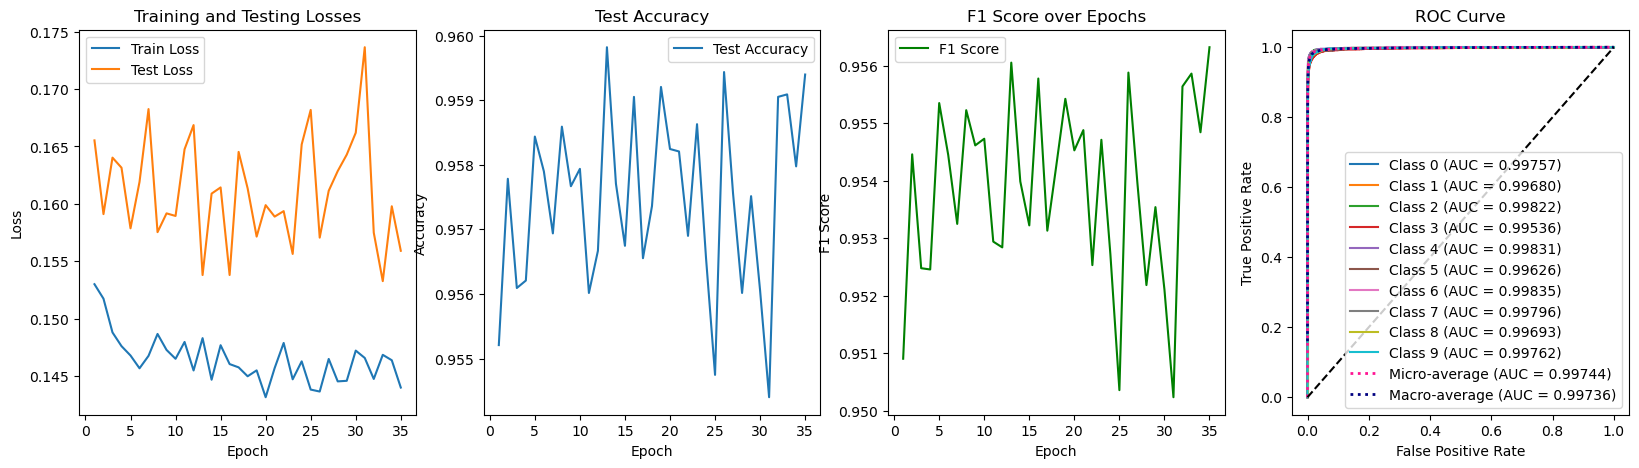

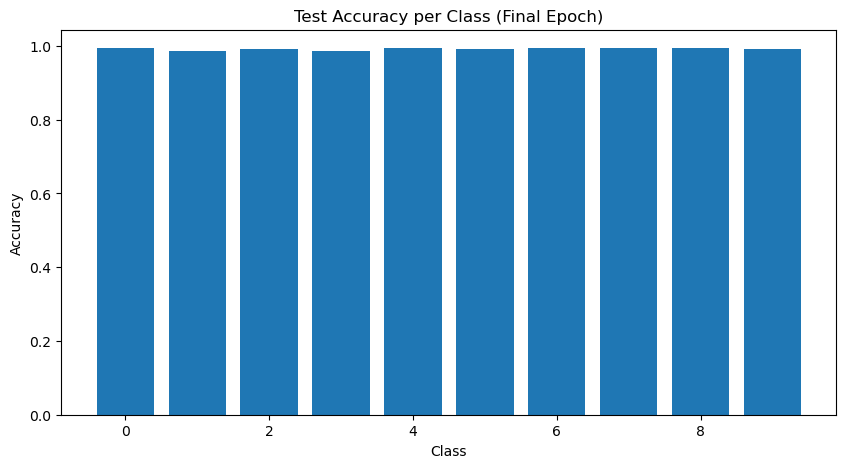

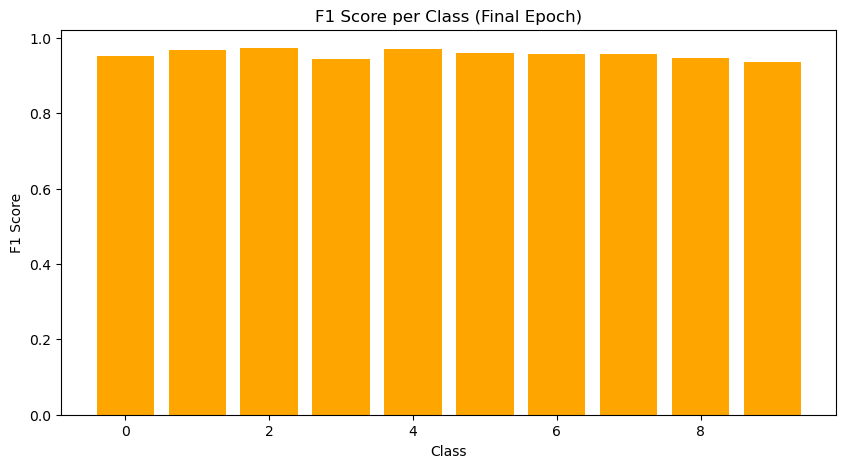

Confusion Matrix:
[[1689    9    2    4    2    4   13    4    8    9]
 [  27 4957   14   22   28    6    6   24   11    4]
 [   4   27 4027   41    7    9    1   15    9    9]
 [   8   20   12 2704    3   41    3    2   25   64]
 [   9   30   16   11 2433    6    2    3    5    8]
 [   5    9    7   27    2 2289   24    2    9   10]
 [  16   14    1    8    6   19 1893    1   18    1]
 [   3   68   23   11    3    5    3 1901    0    2]
 [  10   10    4   10    3    7   27    0 1579   10]
 [  34    8   21    7    2    5    3    2   10 1503]]


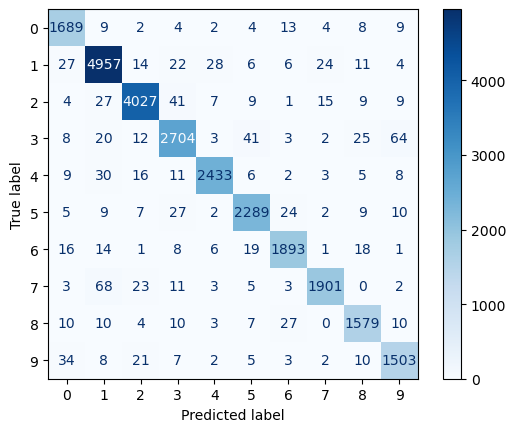

In [29]:
plot_results(train_losses_3_3_1, test_losses_3_3_1, test_accuracy_3_3_1, test_f1_3_3_1, all_labels_3_3_1, all_preds_3_3_1, all_probs_3_3_1, num_epochs_3_3_1, 10)

### Num of Epochs = 140

In [30]:
num_epochs_3_3_2 = 140

In [31]:
train_losses_3_3_2, test_losses_3_3_2, test_accuracy_3_3_2, test_f1_3_3_2, all_labels_3_3_2, all_preds_3_3_2, all_probs_3_3_2 = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs_3_3_2, 'epc60')
results_3_3_2 = (train_losses_3_3_2, test_losses_3_3_2, test_accuracy_3_3_2, test_f1_3_3_2, all_labels_3_3_2, all_preds_3_3_2, all_probs_3_3_2)

100%|██████████| 573/573 [00:07<00:00, 73.87it/s]


Epoch [1/140], Train Loss: 0.1449, Test Loss: 0.1551, Test Accuracy: 0.9593


100%|██████████| 573/573 [00:07<00:00, 74.45it/s]


Epoch [2/140], Train Loss: 0.1442, Test Loss: 0.1685, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.44it/s]


Epoch [3/140], Train Loss: 0.1423, Test Loss: 0.1625, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 74.20it/s]


Epoch [4/140], Train Loss: 0.1473, Test Loss: 0.1670, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.63it/s]


Epoch [5/140], Train Loss: 0.1457, Test Loss: 0.1677, Test Accuracy: 0.9552


100%|██████████| 573/573 [00:07<00:00, 74.34it/s]


Epoch [6/140], Train Loss: 0.1421, Test Loss: 0.1647, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.16it/s]


Epoch [7/140], Train Loss: 0.1443, Test Loss: 0.1594, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [8/140], Train Loss: 0.1437, Test Loss: 0.1645, Test Accuracy: 0.9560


100%|██████████| 573/573 [00:07<00:00, 74.61it/s]


Epoch [9/140], Train Loss: 0.1447, Test Loss: 0.1637, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.64it/s]


Epoch [10/140], Train Loss: 0.1420, Test Loss: 0.1536, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.65it/s]


Epoch [11/140], Train Loss: 0.1443, Test Loss: 0.1606, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.55it/s]


Epoch [12/140], Train Loss: 0.1467, Test Loss: 0.1620, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.44it/s]


Epoch [13/140], Train Loss: 0.1438, Test Loss: 0.1575, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [14/140], Train Loss: 0.1425, Test Loss: 0.1570, Test Accuracy: 0.9596


100%|██████████| 573/573 [00:07<00:00, 74.63it/s]


Epoch [15/140], Train Loss: 0.1467, Test Loss: 0.1643, Test Accuracy: 0.9564


100%|██████████| 573/573 [00:07<00:00, 74.21it/s]


Epoch [16/140], Train Loss: 0.1429, Test Loss: 0.1596, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 74.30it/s]


Epoch [17/140], Train Loss: 0.1458, Test Loss: 0.1637, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.21it/s]


Epoch [18/140], Train Loss: 0.1419, Test Loss: 0.1758, Test Accuracy: 0.9557


100%|██████████| 573/573 [00:07<00:00, 74.41it/s]


Epoch [19/140], Train Loss: 0.1436, Test Loss: 0.1669, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.75it/s]


Epoch [20/140], Train Loss: 0.1442, Test Loss: 0.1664, Test Accuracy: 0.9554


100%|██████████| 573/573 [00:07<00:00, 74.49it/s]


Epoch [21/140], Train Loss: 0.1436, Test Loss: 0.1608, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.23it/s]


Epoch [22/140], Train Loss: 0.1409, Test Loss: 0.1687, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.06it/s]


Epoch [23/140], Train Loss: 0.1454, Test Loss: 0.1599, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.13it/s]


Epoch [24/140], Train Loss: 0.1409, Test Loss: 0.1606, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.33it/s]


Epoch [25/140], Train Loss: 0.1428, Test Loss: 0.1661, Test Accuracy: 0.9557


100%|██████████| 573/573 [00:07<00:00, 73.61it/s]


Epoch [26/140], Train Loss: 0.1448, Test Loss: 0.1616, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.42it/s]


Epoch [27/140], Train Loss: 0.1423, Test Loss: 0.1690, Test Accuracy: 0.9565


100%|██████████| 573/573 [00:07<00:00, 74.06it/s]


Epoch [28/140], Train Loss: 0.1437, Test Loss: 0.1650, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.08it/s]


Epoch [29/140], Train Loss: 0.1419, Test Loss: 0.1613, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.62it/s]


Epoch [30/140], Train Loss: 0.1444, Test Loss: 0.1613, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.31it/s]


Epoch [31/140], Train Loss: 0.1433, Test Loss: 0.1594, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 73.87it/s]


Epoch [32/140], Train Loss: 0.1420, Test Loss: 0.1585, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.07it/s]


Epoch [33/140], Train Loss: 0.1434, Test Loss: 0.1652, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 74.34it/s]


Epoch [34/140], Train Loss: 0.1422, Test Loss: 0.1576, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.64it/s]


Epoch [35/140], Train Loss: 0.1422, Test Loss: 0.1542, Test Accuracy: 0.9595


100%|██████████| 573/573 [00:07<00:00, 74.36it/s]


Epoch [36/140], Train Loss: 0.1433, Test Loss: 0.1611, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.70it/s]


Epoch [37/140], Train Loss: 0.1428, Test Loss: 0.1576, Test Accuracy: 0.9590


100%|██████████| 573/573 [00:07<00:00, 74.47it/s]


Epoch [38/140], Train Loss: 0.1430, Test Loss: 0.1609, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.30it/s]


Epoch [39/140], Train Loss: 0.1421, Test Loss: 0.1687, Test Accuracy: 0.9563


100%|██████████| 573/573 [00:07<00:00, 74.19it/s]


Epoch [40/140], Train Loss: 0.1435, Test Loss: 0.1631, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.78it/s]


Epoch [41/140], Train Loss: 0.1441, Test Loss: 0.1587, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [42/140], Train Loss: 0.1425, Test Loss: 0.1649, Test Accuracy: 0.9555


100%|██████████| 573/573 [00:07<00:00, 74.76it/s]


Epoch [43/140], Train Loss: 0.1440, Test Loss: 0.1597, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.43it/s]


Epoch [44/140], Train Loss: 0.1424, Test Loss: 0.1546, Test Accuracy: 0.9590


100%|██████████| 573/573 [00:07<00:00, 74.33it/s]


Epoch [45/140], Train Loss: 0.1450, Test Loss: 0.1551, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.09it/s]


Epoch [46/140], Train Loss: 0.1425, Test Loss: 0.1587, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.33it/s]


Epoch [47/140], Train Loss: 0.1419, Test Loss: 0.1693, Test Accuracy: 0.9562


100%|██████████| 573/573 [00:07<00:00, 74.51it/s]


Epoch [48/140], Train Loss: 0.1448, Test Loss: 0.1632, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.22it/s]


Epoch [49/140], Train Loss: 0.1424, Test Loss: 0.1640, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.33it/s]


Epoch [50/140], Train Loss: 0.1433, Test Loss: 0.1640, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.77it/s]


Epoch [51/140], Train Loss: 0.1440, Test Loss: 0.1589, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 74.18it/s]


Epoch [52/140], Train Loss: 0.1413, Test Loss: 0.1615, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.65it/s]


Epoch [53/140], Train Loss: 0.1435, Test Loss: 0.1643, Test Accuracy: 0.9564


100%|██████████| 573/573 [00:07<00:00, 74.79it/s]


Epoch [54/140], Train Loss: 0.1423, Test Loss: 0.1664, Test Accuracy: 0.9557


100%|██████████| 573/573 [00:07<00:00, 74.71it/s]


Epoch [55/140], Train Loss: 0.1419, Test Loss: 0.1599, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 75.08it/s]


Epoch [56/140], Train Loss: 0.1421, Test Loss: 0.1743, Test Accuracy: 0.9539


100%|██████████| 573/573 [00:07<00:00, 74.80it/s]


Epoch [57/140], Train Loss: 0.1418, Test Loss: 0.1662, Test Accuracy: 0.9558


100%|██████████| 573/573 [00:07<00:00, 74.13it/s]


Epoch [58/140], Train Loss: 0.1414, Test Loss: 0.1591, Test Accuracy: 0.9594


100%|██████████| 573/573 [00:07<00:00, 74.50it/s]


Epoch [59/140], Train Loss: 0.1410, Test Loss: 0.1582, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.85it/s]


Epoch [60/140], Train Loss: 0.1418, Test Loss: 0.1595, Test Accuracy: 0.9590


100%|██████████| 573/573 [00:07<00:00, 74.27it/s]


Epoch [61/140], Train Loss: 0.1443, Test Loss: 0.1669, Test Accuracy: 0.9563


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [62/140], Train Loss: 0.1418, Test Loss: 0.1630, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.04it/s]


Epoch [63/140], Train Loss: 0.1427, Test Loss: 0.1615, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.47it/s]


Epoch [64/140], Train Loss: 0.1412, Test Loss: 0.1604, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.15it/s]


Epoch [65/140], Train Loss: 0.1395, Test Loss: 0.1608, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.52it/s]


Epoch [66/140], Train Loss: 0.1426, Test Loss: 0.1628, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 74.42it/s]


Epoch [67/140], Train Loss: 0.1424, Test Loss: 0.1642, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 74.32it/s]


Epoch [68/140], Train Loss: 0.1408, Test Loss: 0.1613, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [69/140], Train Loss: 0.1425, Test Loss: 0.1620, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.62it/s]


Epoch [70/140], Train Loss: 0.1405, Test Loss: 0.1638, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.27it/s]


Epoch [71/140], Train Loss: 0.1437, Test Loss: 0.1629, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 74.29it/s]


Epoch [72/140], Train Loss: 0.1404, Test Loss: 0.1646, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.21it/s]


Epoch [73/140], Train Loss: 0.1438, Test Loss: 0.1697, Test Accuracy: 0.9558


100%|██████████| 573/573 [00:07<00:00, 74.18it/s]


Epoch [74/140], Train Loss: 0.1428, Test Loss: 0.1571, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.72it/s]


Epoch [75/140], Train Loss: 0.1423, Test Loss: 0.1678, Test Accuracy: 0.9555


100%|██████████| 573/573 [00:07<00:00, 74.65it/s]


Epoch [76/140], Train Loss: 0.1413, Test Loss: 0.1601, Test Accuracy: 0.9588


100%|██████████| 573/573 [00:07<00:00, 72.57it/s]


Epoch [77/140], Train Loss: 0.1422, Test Loss: 0.1596, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 72.88it/s]


Epoch [78/140], Train Loss: 0.1431, Test Loss: 0.1669, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 73.51it/s]


Epoch [79/140], Train Loss: 0.1394, Test Loss: 0.1614, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.50it/s]


Epoch [80/140], Train Loss: 0.1433, Test Loss: 0.1700, Test Accuracy: 0.9555


100%|██████████| 573/573 [00:07<00:00, 74.51it/s]


Epoch [81/140], Train Loss: 0.1412, Test Loss: 0.1673, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 74.43it/s]


Epoch [82/140], Train Loss: 0.1418, Test Loss: 0.1674, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.60it/s]


Epoch [83/140], Train Loss: 0.1405, Test Loss: 0.1561, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 74.40it/s]


Epoch [84/140], Train Loss: 0.1406, Test Loss: 0.1574, Test Accuracy: 0.9601


100%|██████████| 573/573 [00:07<00:00, 73.79it/s]


Epoch [85/140], Train Loss: 0.1433, Test Loss: 0.1623, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [86/140], Train Loss: 0.1430, Test Loss: 0.1592, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 73.77it/s]


Epoch [87/140], Train Loss: 0.1406, Test Loss: 0.1630, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 74.36it/s]


Epoch [88/140], Train Loss: 0.1415, Test Loss: 0.1560, Test Accuracy: 0.9592


100%|██████████| 573/573 [00:07<00:00, 73.81it/s]


Epoch [89/140], Train Loss: 0.1410, Test Loss: 0.1619, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [90/140], Train Loss: 0.1416, Test Loss: 0.1675, Test Accuracy: 0.9562


100%|██████████| 573/573 [00:07<00:00, 74.07it/s]


Epoch [91/140], Train Loss: 0.1430, Test Loss: 0.1701, Test Accuracy: 0.9556


100%|██████████| 573/573 [00:07<00:00, 74.41it/s]


Epoch [92/140], Train Loss: 0.1439, Test Loss: 0.1654, Test Accuracy: 0.9565


100%|██████████| 573/573 [00:07<00:00, 74.06it/s]


Epoch [93/140], Train Loss: 0.1401, Test Loss: 0.1602, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 74.46it/s]


Epoch [94/140], Train Loss: 0.1412, Test Loss: 0.1589, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.59it/s]


Epoch [95/140], Train Loss: 0.1416, Test Loss: 0.1622, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.04it/s]


Epoch [96/140], Train Loss: 0.1449, Test Loss: 0.1648, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.26it/s]


Epoch [97/140], Train Loss: 0.1402, Test Loss: 0.1654, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.75it/s]


Epoch [98/140], Train Loss: 0.1413, Test Loss: 0.1583, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.12it/s]


Epoch [99/140], Train Loss: 0.1400, Test Loss: 0.1633, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 73.66it/s]


Epoch [100/140], Train Loss: 0.1396, Test Loss: 0.1781, Test Accuracy: 0.9536


100%|██████████| 573/573 [00:07<00:00, 74.22it/s]


Epoch [101/140], Train Loss: 0.1407, Test Loss: 0.1620, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.84it/s]


Epoch [102/140], Train Loss: 0.1425, Test Loss: 0.1637, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.07it/s]


Epoch [103/140], Train Loss: 0.1406, Test Loss: 0.1587, Test Accuracy: 0.9595


100%|██████████| 573/573 [00:07<00:00, 74.00it/s]


Epoch [104/140], Train Loss: 0.1401, Test Loss: 0.1688, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [105/140], Train Loss: 0.1404, Test Loss: 0.1715, Test Accuracy: 0.9555


100%|██████████| 573/573 [00:07<00:00, 74.11it/s]


Epoch [106/140], Train Loss: 0.1412, Test Loss: 0.1664, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.07it/s]


Epoch [107/140], Train Loss: 0.1408, Test Loss: 0.1582, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 73.80it/s]


Epoch [108/140], Train Loss: 0.1421, Test Loss: 0.1634, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 73.95it/s]


Epoch [109/140], Train Loss: 0.1424, Test Loss: 0.1665, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 73.52it/s]


Epoch [110/140], Train Loss: 0.1398, Test Loss: 0.1641, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 74.43it/s]


Epoch [111/140], Train Loss: 0.1389, Test Loss: 0.1668, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 73.87it/s]


Epoch [112/140], Train Loss: 0.1411, Test Loss: 0.1620, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 73.91it/s]


Epoch [113/140], Train Loss: 0.1390, Test Loss: 0.1730, Test Accuracy: 0.9554


100%|██████████| 573/573 [00:07<00:00, 73.80it/s]


Epoch [114/140], Train Loss: 0.1422, Test Loss: 0.1637, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.59it/s]


Epoch [115/140], Train Loss: 0.1417, Test Loss: 0.1621, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.57it/s]


Epoch [116/140], Train Loss: 0.1421, Test Loss: 0.1639, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [117/140], Train Loss: 0.1409, Test Loss: 0.1606, Test Accuracy: 0.9590


100%|██████████| 573/573 [00:07<00:00, 74.27it/s]


Epoch [118/140], Train Loss: 0.1405, Test Loss: 0.1633, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.95it/s]


Epoch [119/140], Train Loss: 0.1414, Test Loss: 0.1665, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.58it/s]


Epoch [120/140], Train Loss: 0.1408, Test Loss: 0.1681, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.67it/s]


Epoch [121/140], Train Loss: 0.1401, Test Loss: 0.1670, Test Accuracy: 0.9564


100%|██████████| 573/573 [00:07<00:00, 74.08it/s]


Epoch [122/140], Train Loss: 0.1411, Test Loss: 0.1670, Test Accuracy: 0.9565


100%|██████████| 573/573 [00:07<00:00, 73.51it/s]


Epoch [123/140], Train Loss: 0.1408, Test Loss: 0.1588, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 72.87it/s]


Epoch [124/140], Train Loss: 0.1393, Test Loss: 0.1590, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 72.90it/s]


Epoch [125/140], Train Loss: 0.1372, Test Loss: 0.1686, Test Accuracy: 0.9568


100%|██████████| 573/573 [00:07<00:00, 74.21it/s]


Epoch [126/140], Train Loss: 0.1428, Test Loss: 0.1777, Test Accuracy: 0.9536


100%|██████████| 573/573 [00:07<00:00, 74.18it/s]


Epoch [127/140], Train Loss: 0.1415, Test Loss: 0.1603, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 73.60it/s]


Epoch [128/140], Train Loss: 0.1424, Test Loss: 0.1604, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.56it/s]


Epoch [129/140], Train Loss: 0.1421, Test Loss: 0.1613, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.09it/s]


Epoch [130/140], Train Loss: 0.1401, Test Loss: 0.1546, Test Accuracy: 0.9599


100%|██████████| 573/573 [00:07<00:00, 74.35it/s]


Epoch [131/140], Train Loss: 0.1397, Test Loss: 0.1717, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.67it/s]


Epoch [132/140], Train Loss: 0.1397, Test Loss: 0.1675, Test Accuracy: 0.9564


100%|██████████| 573/573 [00:07<00:00, 74.79it/s]


Epoch [133/140], Train Loss: 0.1401, Test Loss: 0.1671, Test Accuracy: 0.9563


100%|██████████| 573/573 [00:07<00:00, 74.65it/s]


Epoch [134/140], Train Loss: 0.1405, Test Loss: 0.1647, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.38it/s]


Epoch [135/140], Train Loss: 0.1425, Test Loss: 0.1586, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 74.55it/s]


Epoch [136/140], Train Loss: 0.1426, Test Loss: 0.1613, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.35it/s]


Epoch [137/140], Train Loss: 0.1406, Test Loss: 0.1586, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.49it/s]


Epoch [138/140], Train Loss: 0.1413, Test Loss: 0.1643, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.12it/s]


Epoch [139/140], Train Loss: 0.1395, Test Loss: 0.1617, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 73.94it/s]


Epoch [140/140], Train Loss: 0.1377, Test Loss: 0.1622, Test Accuracy: 0.9579


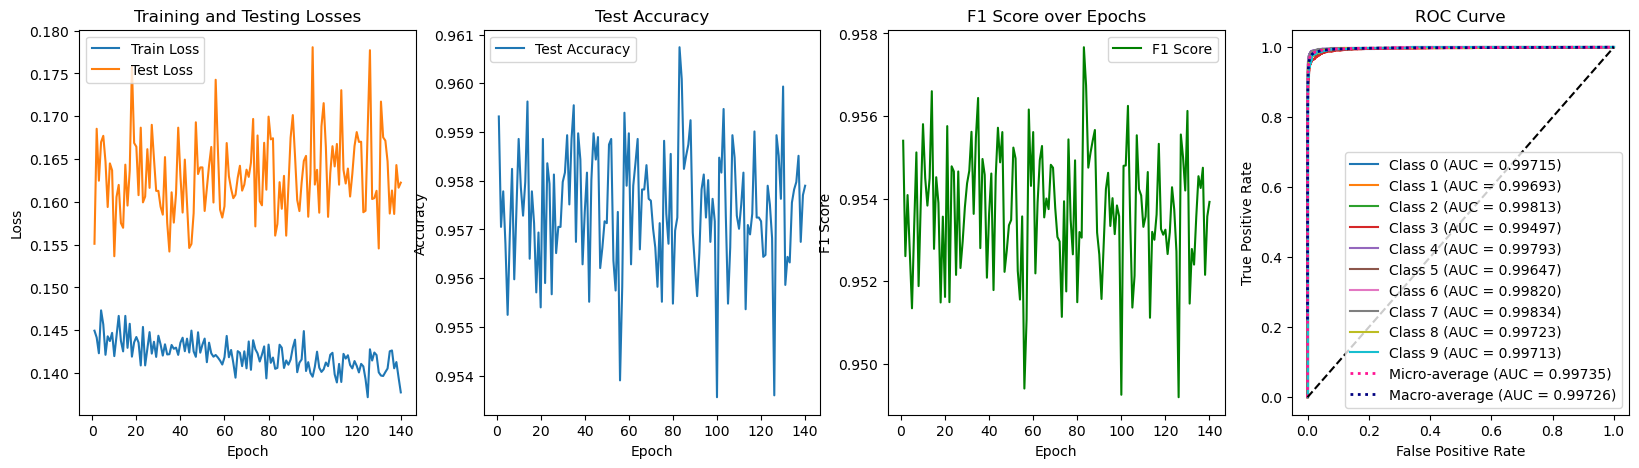

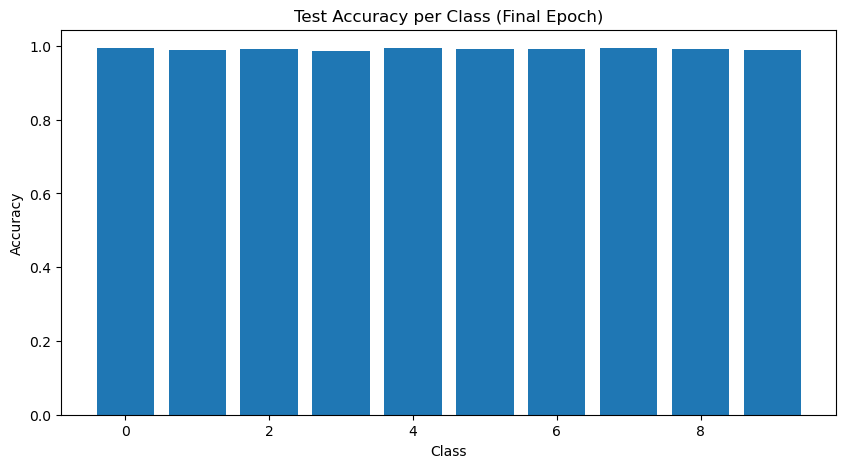

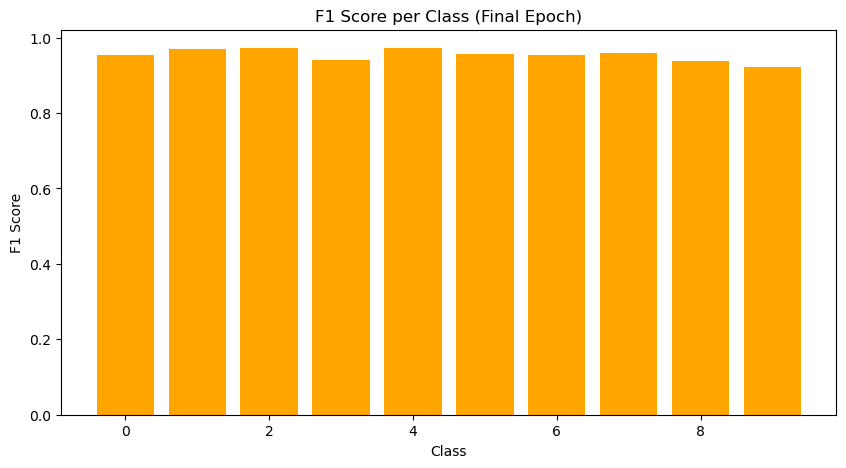

Confusion Matrix:
[[1682    8    8    6    1    4   10    7    5   13]
 [  19 4912   36   25   34    6    5   46    9    7]
 [   3   15 4069   30    6    4    0   12    3    7]
 [   5    9   20 2685    5   34    5    5   19   95]
 [   8   20   12    7 2449    7    3    5    4    8]
 [   5    8    8   36    5 2260   35    4   10   13]
 [  21   11    2    6    6   14 1891    2   22    2]
 [   1   35   33    5    3    4    0 1936    0    2]
 [  10    7   10   21    8    2   40    0 1541   21]
 [  26    6   24   10    2    3    1    2   10 1511]]


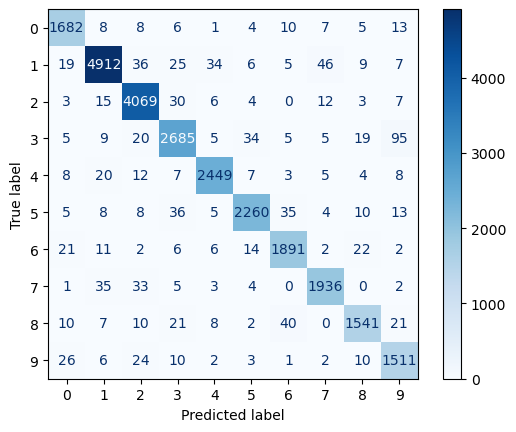

In [32]:
plot_results(train_losses_3_3_2, test_losses_3_3_2, test_accuracy_3_3_2, test_f1_3_3_2, all_labels_3_3_2, all_preds_3_3_2, all_probs_3_3_2 , num_epochs_3_3_2, 10)

## 3.4 Optimizer (Initial = Adam)

### Optimizer = SGD

In [33]:
optimizer_3_4_1 = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)

In [34]:
train_losses_3_4_1 , test_losses_3_4_1 , test_accuracy_3_4_1, test_f1_3_4_1, all_labels_3_4_1 , all_preds_3_4_1 , all_probs_3_4_1  = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer_3_4_1 , num_epochs, 'OpSgd')
results_3_4_1 = (train_losses_3_4_1 , test_losses_3_4_1 , test_accuracy_3_4_1, test_f1_3_4_1, all_labels_3_4_1 , all_preds_3_4_1 , all_probs_3_4_1 )

100%|██████████| 573/573 [00:07<00:00, 74.38it/s]


Epoch [1/70], Train Loss: 0.1261, Test Loss: 0.1590, Test Accuracy: 0.9594


100%|██████████| 573/573 [00:07<00:00, 74.90it/s]


Epoch [2/70], Train Loss: 0.1222, Test Loss: 0.1577, Test Accuracy: 0.9597


100%|██████████| 573/573 [00:07<00:00, 75.28it/s]


Epoch [3/70], Train Loss: 0.1209, Test Loss: 0.1571, Test Accuracy: 0.9601


100%|██████████| 573/573 [00:07<00:00, 75.17it/s]


Epoch [4/70], Train Loss: 0.1206, Test Loss: 0.1567, Test Accuracy: 0.9601


100%|██████████| 573/573 [00:07<00:00, 75.33it/s]


Epoch [5/70], Train Loss: 0.1179, Test Loss: 0.1567, Test Accuracy: 0.9602


100%|██████████| 573/573 [00:07<00:00, 75.10it/s]


Epoch [6/70], Train Loss: 0.1179, Test Loss: 0.1564, Test Accuracy: 0.9604


100%|██████████| 573/573 [00:07<00:00, 75.14it/s]


Epoch [7/70], Train Loss: 0.1166, Test Loss: 0.1563, Test Accuracy: 0.9605


100%|██████████| 573/573 [00:07<00:00, 75.22it/s]


Epoch [8/70], Train Loss: 0.1166, Test Loss: 0.1556, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.56it/s]


Epoch [9/70], Train Loss: 0.1161, Test Loss: 0.1555, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.22it/s]


Epoch [10/70], Train Loss: 0.1148, Test Loss: 0.1556, Test Accuracy: 0.9605


100%|██████████| 573/573 [00:07<00:00, 74.92it/s]


Epoch [11/70], Train Loss: 0.1157, Test Loss: 0.1557, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.23it/s]


Epoch [12/70], Train Loss: 0.1166, Test Loss: 0.1555, Test Accuracy: 0.9606


100%|██████████| 573/573 [00:07<00:00, 75.43it/s]


Epoch [13/70], Train Loss: 0.1166, Test Loss: 0.1555, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.18it/s]


Epoch [14/70], Train Loss: 0.1147, Test Loss: 0.1558, Test Accuracy: 0.9605


100%|██████████| 573/573 [00:07<00:00, 75.18it/s]


Epoch [15/70], Train Loss: 0.1140, Test Loss: 0.1559, Test Accuracy: 0.9606


100%|██████████| 573/573 [00:07<00:00, 74.90it/s]


Epoch [16/70], Train Loss: 0.1128, Test Loss: 0.1557, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.22it/s]


Epoch [17/70], Train Loss: 0.1135, Test Loss: 0.1559, Test Accuracy: 0.9609


100%|██████████| 573/573 [00:07<00:00, 75.01it/s]


Epoch [18/70], Train Loss: 0.1162, Test Loss: 0.1560, Test Accuracy: 0.9608


100%|██████████| 573/573 [00:07<00:00, 75.22it/s]


Epoch [19/70], Train Loss: 0.1139, Test Loss: 0.1555, Test Accuracy: 0.9606


100%|██████████| 573/573 [00:07<00:00, 75.44it/s]


Epoch [20/70], Train Loss: 0.1151, Test Loss: 0.1555, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.20it/s]


Epoch [21/70], Train Loss: 0.1137, Test Loss: 0.1555, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.43it/s]


Epoch [22/70], Train Loss: 0.1122, Test Loss: 0.1549, Test Accuracy: 0.9608


100%|██████████| 573/573 [00:07<00:00, 75.33it/s]


Epoch [23/70], Train Loss: 0.1129, Test Loss: 0.1552, Test Accuracy: 0.9608


100%|██████████| 573/573 [00:07<00:00, 75.63it/s]


Epoch [24/70], Train Loss: 0.1100, Test Loss: 0.1554, Test Accuracy: 0.9610


100%|██████████| 573/573 [00:07<00:00, 75.75it/s]


Epoch [25/70], Train Loss: 0.1138, Test Loss: 0.1549, Test Accuracy: 0.9611


100%|██████████| 573/573 [00:07<00:00, 75.19it/s]


Epoch [26/70], Train Loss: 0.1109, Test Loss: 0.1549, Test Accuracy: 0.9609


100%|██████████| 573/573 [00:07<00:00, 75.62it/s]


Epoch [27/70], Train Loss: 0.1137, Test Loss: 0.1553, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.12it/s]


Epoch [28/70], Train Loss: 0.1098, Test Loss: 0.1551, Test Accuracy: 0.9608


100%|██████████| 573/573 [00:07<00:00, 75.36it/s]


Epoch [29/70], Train Loss: 0.1124, Test Loss: 0.1553, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.47it/s]


Epoch [30/70], Train Loss: 0.1118, Test Loss: 0.1556, Test Accuracy: 0.9607


100%|██████████| 573/573 [00:07<00:00, 75.35it/s]


Epoch [31/70], Train Loss: 0.1128, Test Loss: 0.1549, Test Accuracy: 0.9610


100%|██████████| 573/573 [00:07<00:00, 75.40it/s]


Epoch [32/70], Train Loss: 0.1108, Test Loss: 0.1555, Test Accuracy: 0.9609


100%|██████████| 573/573 [00:07<00:00, 75.40it/s]


Epoch [33/70], Train Loss: 0.1119, Test Loss: 0.1559, Test Accuracy: 0.9609


100%|██████████| 573/573 [00:07<00:00, 75.42it/s]


Epoch [34/70], Train Loss: 0.1105, Test Loss: 0.1558, Test Accuracy: 0.9610


100%|██████████| 573/573 [00:07<00:00, 75.56it/s]


Epoch [35/70], Train Loss: 0.1122, Test Loss: 0.1551, Test Accuracy: 0.9611


100%|██████████| 573/573 [00:07<00:00, 75.14it/s]


Epoch [36/70], Train Loss: 0.1107, Test Loss: 0.1557, Test Accuracy: 0.9612


100%|██████████| 573/573 [00:07<00:00, 75.26it/s]


Epoch [37/70], Train Loss: 0.1111, Test Loss: 0.1559, Test Accuracy: 0.9612


100%|██████████| 573/573 [00:07<00:00, 75.52it/s]


Epoch [38/70], Train Loss: 0.1101, Test Loss: 0.1555, Test Accuracy: 0.9613


100%|██████████| 573/573 [00:07<00:00, 75.79it/s]


Epoch [39/70], Train Loss: 0.1104, Test Loss: 0.1554, Test Accuracy: 0.9613


100%|██████████| 573/573 [00:07<00:00, 75.54it/s]


Epoch [40/70], Train Loss: 0.1106, Test Loss: 0.1552, Test Accuracy: 0.9612


100%|██████████| 573/573 [00:07<00:00, 75.32it/s]


Epoch [41/70], Train Loss: 0.1101, Test Loss: 0.1554, Test Accuracy: 0.9613


100%|██████████| 573/573 [00:07<00:00, 75.61it/s]


Epoch [42/70], Train Loss: 0.1104, Test Loss: 0.1554, Test Accuracy: 0.9608


100%|██████████| 573/573 [00:07<00:00, 75.28it/s]


Epoch [43/70], Train Loss: 0.1081, Test Loss: 0.1553, Test Accuracy: 0.9611


100%|██████████| 573/573 [00:07<00:00, 75.06it/s]


Epoch [44/70], Train Loss: 0.1108, Test Loss: 0.1556, Test Accuracy: 0.9613


100%|██████████| 573/573 [00:07<00:00, 75.29it/s]


Epoch [45/70], Train Loss: 0.1123, Test Loss: 0.1559, Test Accuracy: 0.9612


100%|██████████| 573/573 [00:07<00:00, 75.72it/s]


Epoch [46/70], Train Loss: 0.1107, Test Loss: 0.1553, Test Accuracy: 0.9613


100%|██████████| 573/573 [00:07<00:00, 75.51it/s]


Epoch [47/70], Train Loss: 0.1111, Test Loss: 0.1554, Test Accuracy: 0.9612


100%|██████████| 573/573 [00:07<00:00, 75.52it/s]


Epoch [48/70], Train Loss: 0.1106, Test Loss: 0.1553, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.03it/s]


Epoch [49/70], Train Loss: 0.1086, Test Loss: 0.1560, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.16it/s]


Epoch [50/70], Train Loss: 0.1106, Test Loss: 0.1550, Test Accuracy: 0.9610


100%|██████████| 573/573 [00:07<00:00, 75.37it/s]


Epoch [51/70], Train Loss: 0.1103, Test Loss: 0.1549, Test Accuracy: 0.9616


100%|██████████| 573/573 [00:07<00:00, 75.75it/s]


Epoch [52/70], Train Loss: 0.1097, Test Loss: 0.1553, Test Accuracy: 0.9613


100%|██████████| 573/573 [00:07<00:00, 76.22it/s]


Epoch [53/70], Train Loss: 0.1088, Test Loss: 0.1560, Test Accuracy: 0.9617


100%|██████████| 573/573 [00:07<00:00, 75.56it/s]


Epoch [54/70], Train Loss: 0.1068, Test Loss: 0.1554, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.80it/s]


Epoch [55/70], Train Loss: 0.1090, Test Loss: 0.1554, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.23it/s]


Epoch [56/70], Train Loss: 0.1099, Test Loss: 0.1556, Test Accuracy: 0.9613


100%|██████████| 573/573 [00:07<00:00, 75.00it/s]


Epoch [57/70], Train Loss: 0.1090, Test Loss: 0.1558, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.24it/s]


Epoch [58/70], Train Loss: 0.1095, Test Loss: 0.1557, Test Accuracy: 0.9611


100%|██████████| 573/573 [00:07<00:00, 75.50it/s]


Epoch [59/70], Train Loss: 0.1103, Test Loss: 0.1558, Test Accuracy: 0.9612


100%|██████████| 573/573 [00:07<00:00, 75.24it/s]


Epoch [60/70], Train Loss: 0.1079, Test Loss: 0.1555, Test Accuracy: 0.9616


100%|██████████| 573/573 [00:07<00:00, 75.51it/s]


Epoch [61/70], Train Loss: 0.1091, Test Loss: 0.1558, Test Accuracy: 0.9615


100%|██████████| 573/573 [00:07<00:00, 75.83it/s]


Epoch [62/70], Train Loss: 0.1086, Test Loss: 0.1551, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.75it/s]


Epoch [63/70], Train Loss: 0.1080, Test Loss: 0.1556, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.03it/s]


Epoch [64/70], Train Loss: 0.1086, Test Loss: 0.1557, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 74.97it/s]


Epoch [65/70], Train Loss: 0.1071, Test Loss: 0.1555, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.35it/s]


Epoch [66/70], Train Loss: 0.1080, Test Loss: 0.1555, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.63it/s]


Epoch [67/70], Train Loss: 0.1072, Test Loss: 0.1553, Test Accuracy: 0.9613


100%|██████████| 573/573 [00:07<00:00, 75.58it/s]


Epoch [68/70], Train Loss: 0.1094, Test Loss: 0.1556, Test Accuracy: 0.9611


100%|██████████| 573/573 [00:07<00:00, 75.20it/s]


Epoch [69/70], Train Loss: 0.1079, Test Loss: 0.1551, Test Accuracy: 0.9614


100%|██████████| 573/573 [00:07<00:00, 75.23it/s]


Epoch [70/70], Train Loss: 0.1085, Test Loss: 0.1553, Test Accuracy: 0.9614


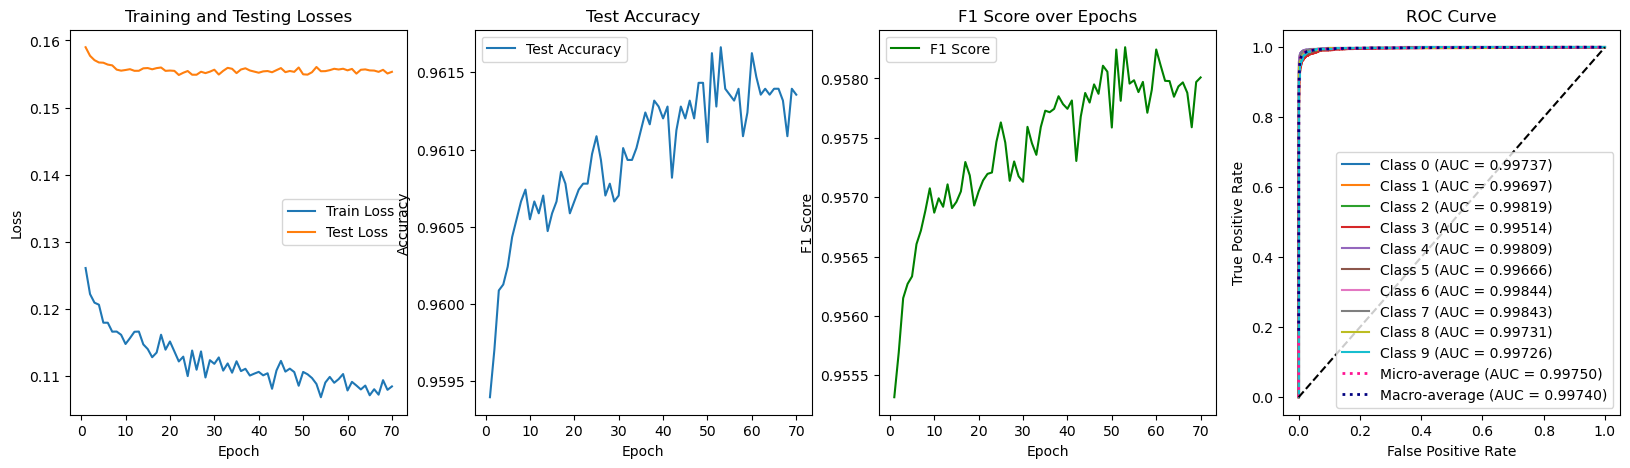

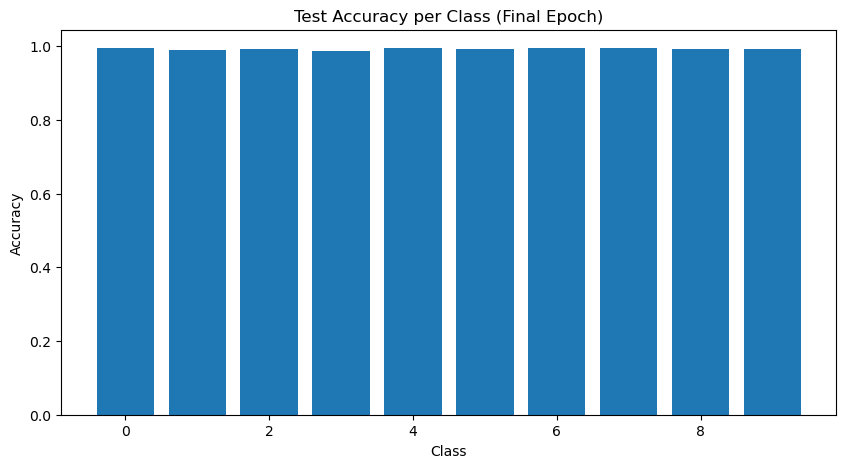

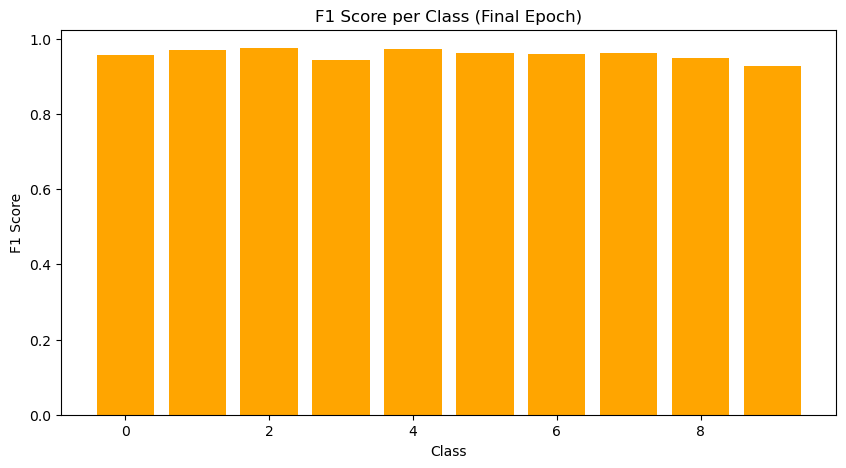

Confusion Matrix:
[[1691    9    4    6    0    4   10    6    7    7]
 [  21 4947   19   24   32    5    5   30    9    7]
 [   4   18 4050   34    8    4    3   15    5    8]
 [   6   12   18 2701    4   30    5    2   16   88]
 [   8   26    7    8 2454    4    2    4    3    7]
 [   5    7    7   32    4 2271   32    2   12   12]
 [  17   13    2    6    6   13 1904    1   14    1]
 [   1   52   23    5    3    2    0 1930    0    3]
 [   9    7    6   15    7    0   33    0 1566   17]
 [  30    6   21    9    2    4    1    3    7 1512]]


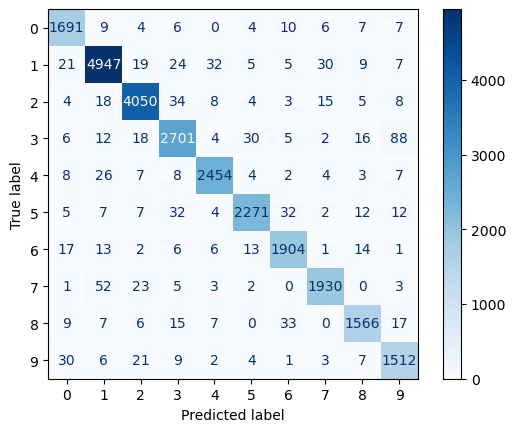

In [35]:
plot_results(train_losses_3_4_1 , test_losses_3_4_1 , test_accuracy_3_4_1, test_f1_3_4_1, all_labels_3_4_1 , all_preds_3_4_1 , all_probs_3_4_1 , num_epochs, 10)

### Optimizer = RMSrop

In [36]:
optimizer_3_4_2 = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)

In [37]:
train_losses_3_4_2 , test_losses_3_4_2 , test_accuracy_3_4_2 , test_f1_3_4_2, all_labels_3_4_2 , all_preds_3_4_2 , all_probs_3_4_2  = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer_3_4_2 , num_epochs, 'OpRMSrop')
results_3_4_1 = (train_losses_3_4_2 , test_losses_3_4_2 , test_accuracy_3_4_2 , test_f1_3_4_2, all_labels_3_4_2 , all_preds_3_4_2 , all_probs_3_4_2 )

100%|██████████| 573/573 [00:07<00:00, 74.15it/s]


Epoch [1/70], Train Loss: 0.1533, Test Loss: 0.1554, Test Accuracy: 0.9593


100%|██████████| 573/573 [00:07<00:00, 74.40it/s]


Epoch [2/70], Train Loss: 0.1432, Test Loss: 0.1558, Test Accuracy: 0.9597


100%|██████████| 573/573 [00:07<00:00, 74.26it/s]


Epoch [3/70], Train Loss: 0.1434, Test Loss: 0.1584, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.19it/s]


Epoch [4/70], Train Loss: 0.1448, Test Loss: 0.1680, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.90it/s]


Epoch [5/70], Train Loss: 0.1397, Test Loss: 0.1630, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.11it/s]


Epoch [6/70], Train Loss: 0.1416, Test Loss: 0.1712, Test Accuracy: 0.9536


100%|██████████| 573/573 [00:07<00:00, 73.44it/s]


Epoch [7/70], Train Loss: 0.1410, Test Loss: 0.1661, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.00it/s]


Epoch [8/70], Train Loss: 0.1403, Test Loss: 0.1687, Test Accuracy: 0.9560


100%|██████████| 573/573 [00:07<00:00, 72.76it/s]


Epoch [9/70], Train Loss: 0.1410, Test Loss: 0.1895, Test Accuracy: 0.9499


100%|██████████| 573/573 [00:07<00:00, 75.16it/s]


Epoch [10/70], Train Loss: 0.1409, Test Loss: 0.1671, Test Accuracy: 0.9552


100%|██████████| 573/573 [00:07<00:00, 75.46it/s]


Epoch [11/70], Train Loss: 0.1430, Test Loss: 0.1636, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.75it/s]


Epoch [12/70], Train Loss: 0.1395, Test Loss: 0.1672, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 75.36it/s]


Epoch [13/70], Train Loss: 0.1408, Test Loss: 0.1686, Test Accuracy: 0.9557


100%|██████████| 573/573 [00:07<00:00, 75.25it/s]


Epoch [14/70], Train Loss: 0.1428, Test Loss: 0.1620, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.91it/s]


Epoch [15/70], Train Loss: 0.1416, Test Loss: 0.1632, Test Accuracy: 0.9592


100%|██████████| 573/573 [00:07<00:00, 75.23it/s]


Epoch [16/70], Train Loss: 0.1413, Test Loss: 0.1621, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.77it/s]


Epoch [17/70], Train Loss: 0.1402, Test Loss: 0.1653, Test Accuracy: 0.9561


100%|██████████| 573/573 [00:07<00:00, 75.08it/s]


Epoch [18/70], Train Loss: 0.1402, Test Loss: 0.1635, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.61it/s]


Epoch [19/70], Train Loss: 0.1421, Test Loss: 0.1689, Test Accuracy: 0.9551


100%|██████████| 573/573 [00:07<00:00, 74.95it/s]


Epoch [20/70], Train Loss: 0.1425, Test Loss: 0.1680, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 75.25it/s]


Epoch [21/70], Train Loss: 0.1438, Test Loss: 0.1698, Test Accuracy: 0.9557


100%|██████████| 573/573 [00:07<00:00, 75.34it/s]


Epoch [22/70], Train Loss: 0.1430, Test Loss: 0.1745, Test Accuracy: 0.9538


100%|██████████| 573/573 [00:07<00:00, 75.52it/s]


Epoch [23/70], Train Loss: 0.1412, Test Loss: 0.1701, Test Accuracy: 0.9549


100%|██████████| 573/573 [00:07<00:00, 75.77it/s]


Epoch [24/70], Train Loss: 0.1401, Test Loss: 0.1731, Test Accuracy: 0.9551


100%|██████████| 573/573 [00:07<00:00, 75.22it/s]


Epoch [25/70], Train Loss: 0.1424, Test Loss: 0.1767, Test Accuracy: 0.9543


100%|██████████| 573/573 [00:07<00:00, 73.82it/s]


Epoch [26/70], Train Loss: 0.1432, Test Loss: 0.1928, Test Accuracy: 0.9500


100%|██████████| 573/573 [00:07<00:00, 72.67it/s]


Epoch [27/70], Train Loss: 0.1405, Test Loss: 0.1691, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 73.09it/s]


Epoch [28/70], Train Loss: 0.1425, Test Loss: 0.1760, Test Accuracy: 0.9549


100%|██████████| 573/573 [00:07<00:00, 74.42it/s]


Epoch [29/70], Train Loss: 0.1418, Test Loss: 0.1721, Test Accuracy: 0.9546


100%|██████████| 573/573 [00:07<00:00, 74.61it/s]


Epoch [30/70], Train Loss: 0.1427, Test Loss: 0.1606, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.80it/s]


Epoch [31/70], Train Loss: 0.1410, Test Loss: 0.1672, Test Accuracy: 0.9555


100%|██████████| 573/573 [00:07<00:00, 74.82it/s]


Epoch [32/70], Train Loss: 0.1399, Test Loss: 0.1844, Test Accuracy: 0.9511


100%|██████████| 573/573 [00:07<00:00, 75.18it/s]


Epoch [33/70], Train Loss: 0.1389, Test Loss: 0.1689, Test Accuracy: 0.9549


100%|██████████| 573/573 [00:07<00:00, 75.05it/s]


Epoch [34/70], Train Loss: 0.1413, Test Loss: 0.1670, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 74.53it/s]


Epoch [35/70], Train Loss: 0.1430, Test Loss: 0.1648, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 75.09it/s]


Epoch [36/70], Train Loss: 0.1417, Test Loss: 0.1646, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 75.35it/s]


Epoch [37/70], Train Loss: 0.1411, Test Loss: 0.1617, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 75.20it/s]


Epoch [38/70], Train Loss: 0.1422, Test Loss: 0.1676, Test Accuracy: 0.9562


100%|██████████| 573/573 [00:07<00:00, 75.24it/s]


Epoch [39/70], Train Loss: 0.1407, Test Loss: 0.1676, Test Accuracy: 0.9563


100%|██████████| 573/573 [00:07<00:00, 75.16it/s]


Epoch [40/70], Train Loss: 0.1408, Test Loss: 0.1638, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 75.44it/s]


Epoch [41/70], Train Loss: 0.1430, Test Loss: 0.1642, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 75.03it/s]


Epoch [42/70], Train Loss: 0.1411, Test Loss: 0.1659, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 75.38it/s]


Epoch [43/70], Train Loss: 0.1416, Test Loss: 0.1685, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 75.03it/s]


Epoch [44/70], Train Loss: 0.1401, Test Loss: 0.1661, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.81it/s]


Epoch [45/70], Train Loss: 0.1412, Test Loss: 0.1746, Test Accuracy: 0.9541


100%|██████████| 573/573 [00:07<00:00, 74.95it/s]


Epoch [46/70], Train Loss: 0.1412, Test Loss: 0.1728, Test Accuracy: 0.9551


100%|██████████| 573/573 [00:07<00:00, 75.27it/s]


Epoch [47/70], Train Loss: 0.1423, Test Loss: 0.1656, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 75.17it/s]


Epoch [48/70], Train Loss: 0.1421, Test Loss: 0.1737, Test Accuracy: 0.9546


100%|██████████| 573/573 [00:07<00:00, 74.96it/s]


Epoch [49/70], Train Loss: 0.1410, Test Loss: 0.1604, Test Accuracy: 0.9591


100%|██████████| 573/573 [00:07<00:00, 74.73it/s]


Epoch [50/70], Train Loss: 0.1414, Test Loss: 0.1760, Test Accuracy: 0.9554


100%|██████████| 573/573 [00:07<00:00, 75.02it/s]


Epoch [51/70], Train Loss: 0.1426, Test Loss: 0.1688, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.64it/s]


Epoch [52/70], Train Loss: 0.1432, Test Loss: 0.1659, Test Accuracy: 0.9563


100%|██████████| 573/573 [00:07<00:00, 74.90it/s]


Epoch [53/70], Train Loss: 0.1365, Test Loss: 0.1691, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 75.66it/s]


Epoch [54/70], Train Loss: 0.1405, Test Loss: 0.1634, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.99it/s]


Epoch [55/70], Train Loss: 0.1430, Test Loss: 0.1746, Test Accuracy: 0.9551


100%|██████████| 573/573 [00:07<00:00, 75.16it/s]


Epoch [56/70], Train Loss: 0.1423, Test Loss: 0.1674, Test Accuracy: 0.9555


100%|██████████| 573/573 [00:07<00:00, 75.14it/s]


Epoch [57/70], Train Loss: 0.1406, Test Loss: 0.1653, Test Accuracy: 0.9564


100%|██████████| 573/573 [00:07<00:00, 74.89it/s]


Epoch [58/70], Train Loss: 0.1408, Test Loss: 0.1635, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 73.46it/s]


Epoch [59/70], Train Loss: 0.1436, Test Loss: 0.1637, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.19it/s]


Epoch [60/70], Train Loss: 0.1416, Test Loss: 0.1739, Test Accuracy: 0.9561


100%|██████████| 573/573 [00:07<00:00, 74.95it/s]


Epoch [61/70], Train Loss: 0.1419, Test Loss: 0.1682, Test Accuracy: 0.9553


100%|██████████| 573/573 [00:07<00:00, 75.18it/s]


Epoch [62/70], Train Loss: 0.1433, Test Loss: 0.1683, Test Accuracy: 0.9562


100%|██████████| 573/573 [00:07<00:00, 75.15it/s]


Epoch [63/70], Train Loss: 0.1423, Test Loss: 0.1659, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.93it/s]


Epoch [64/70], Train Loss: 0.1392, Test Loss: 0.1679, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.95it/s]


Epoch [65/70], Train Loss: 0.1415, Test Loss: 0.1688, Test Accuracy: 0.9551


100%|██████████| 573/573 [00:07<00:00, 74.41it/s]


Epoch [66/70], Train Loss: 0.1391, Test Loss: 0.1660, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 75.43it/s]


Epoch [67/70], Train Loss: 0.1377, Test Loss: 0.1702, Test Accuracy: 0.9544


100%|██████████| 573/573 [00:07<00:00, 74.94it/s]


Epoch [68/70], Train Loss: 0.1437, Test Loss: 0.1585, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 75.34it/s]


Epoch [69/70], Train Loss: 0.1420, Test Loss: 0.1680, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 75.27it/s]


Epoch [70/70], Train Loss: 0.1421, Test Loss: 0.1598, Test Accuracy: 0.9589


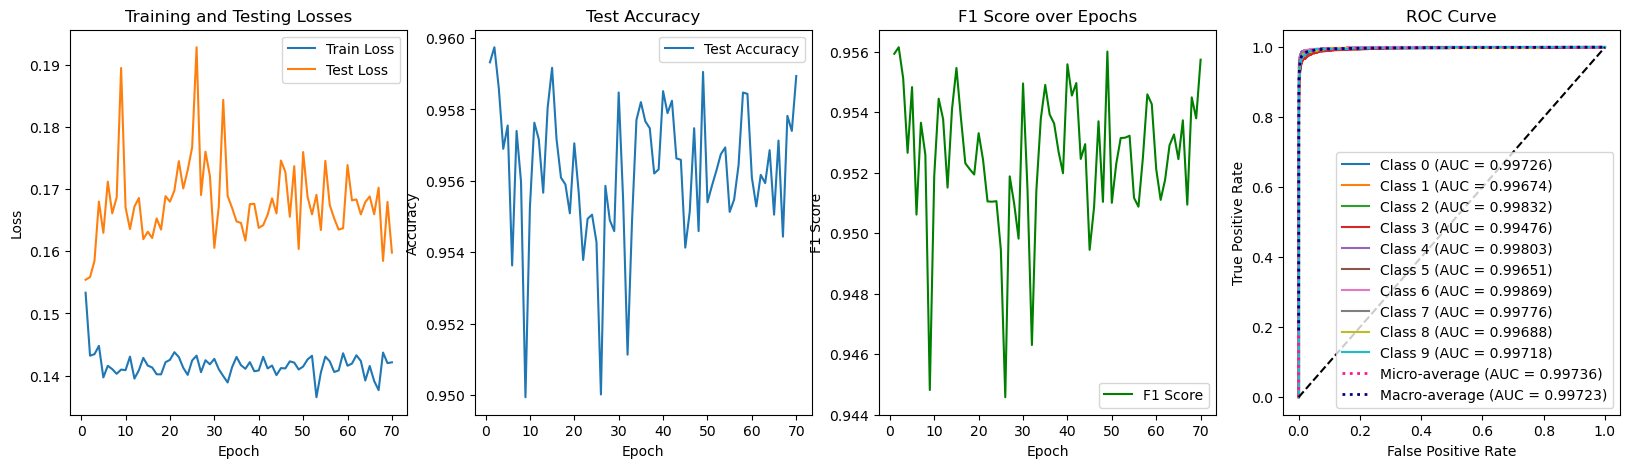

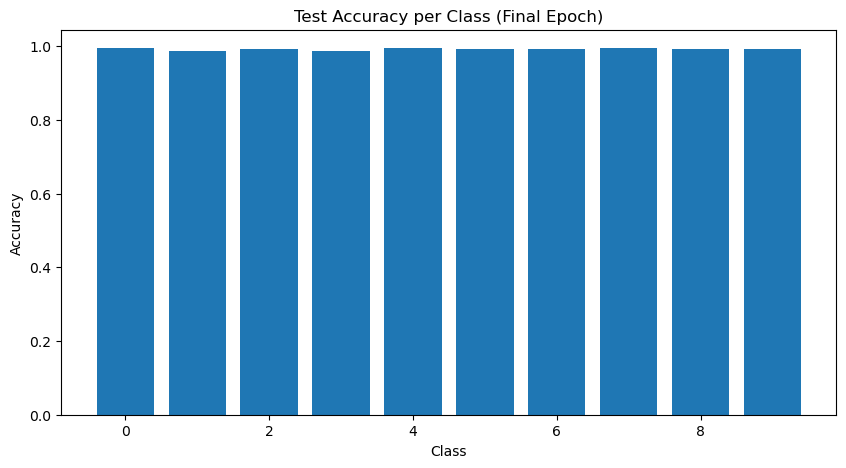

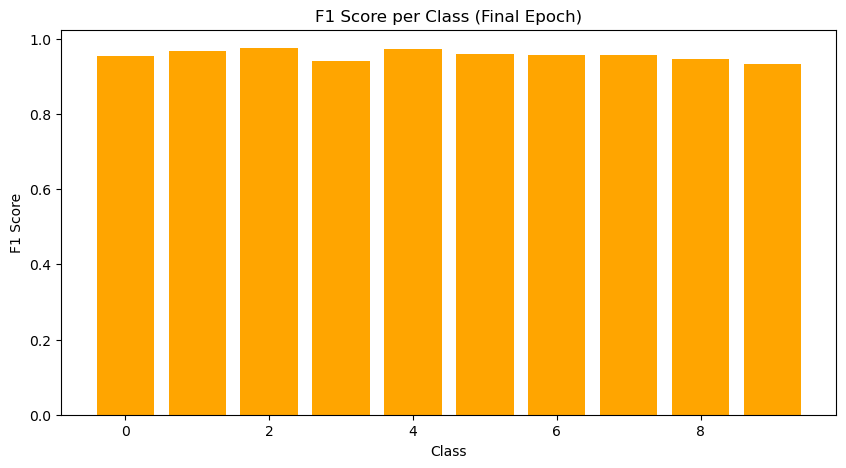

Confusion Matrix:
[[1690    9    3    6    0    4   10    4    7   11]
 [  21 4951   19   34   19    6    7   31    8    3]
 [   9   27 4028   40    8    5    4   12    6   10]
 [   7   16    8 2711    3   33    4    1   16   83]
 [   9   32   11   14 2431    5    3    4    3   11]
 [   6   11    4   31    2 2269   31    2   16   12]
 [  23   15    1    7    5   14 1889    1   19    3]
 [   2   69   20   11    3    2    2 1904    0    6]
 [  12    8    5   19    7    3   26    0 1563   17]
 [  20    8   13   11    4    4    0    1    7 1527]]


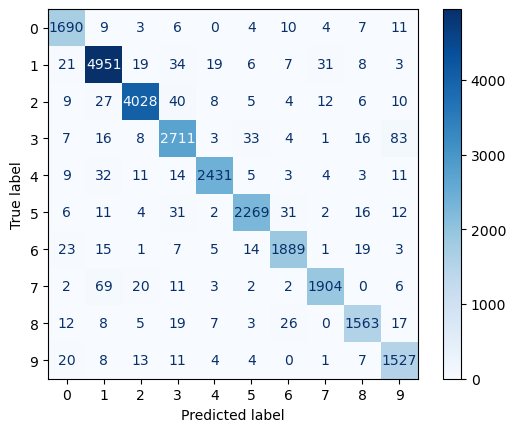

In [38]:
plot_results(train_losses_3_4_2 , test_losses_3_4_2 , test_accuracy_3_4_2 , test_f1_3_4_2, all_labels_3_4_2 , all_preds_3_4_2 , all_probs_3_4_2 , num_epochs, 10)

## 3.5 Rotation (Initial = 0)

### Rotation = 15

In [39]:
train_transform_3_5_1 = SVHNAugmentation(15, (1.0,1.0), (0.75,1.33))

# Load the training dataset
train_dataset_3_5_1 = datasets.SVHN(root='./data', split='train', download=True, transform=train_transform_3_5_1)
train_loader_3_5_1 = DataLoader(train_dataset, batch_size=128, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat


In [40]:
train_losses_3_5_1, test_losses_3_5_1, test_accuracy_3_5_1, test_f1_3_5_1, all_labels_3_5_1, all_preds_3_5_1, all_probs_3_5_1 = train_and_evaluate(model, train_loader_3_5_1, test_loader, criterion, optimizer, num_epochs, "rot15")
initial_results_3_5_1 = (train_losses_3_5_1, test_losses_3_5_1, test_accuracy_3_5_1, test_f1_3_5_1, all_labels_3_5_1, all_preds_3_5_1, all_probs_3_5_1)

100%|██████████| 573/573 [00:07<00:00, 73.59it/s]


Epoch [1/70], Train Loss: 0.1398, Test Loss: 0.1741, Test Accuracy: 0.9562


100%|██████████| 573/573 [00:07<00:00, 73.33it/s]


Epoch [2/70], Train Loss: 0.1415, Test Loss: 0.1690, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 73.96it/s]


Epoch [3/70], Train Loss: 0.1407, Test Loss: 0.1586, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.03it/s]


Epoch [4/70], Train Loss: 0.1405, Test Loss: 0.1669, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.68it/s]


Epoch [5/70], Train Loss: 0.1396, Test Loss: 0.1690, Test Accuracy: 0.9544


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [6/70], Train Loss: 0.1404, Test Loss: 0.1598, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 74.32it/s]


Epoch [7/70], Train Loss: 0.1387, Test Loss: 0.1711, Test Accuracy: 0.9560


100%|██████████| 573/573 [00:07<00:00, 73.98it/s]


Epoch [8/70], Train Loss: 0.1389, Test Loss: 0.1697, Test Accuracy: 0.9561


100%|██████████| 573/573 [00:07<00:00, 74.14it/s]


Epoch [9/70], Train Loss: 0.1385, Test Loss: 0.1581, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.50it/s]


Epoch [10/70], Train Loss: 0.1380, Test Loss: 0.1686, Test Accuracy: 0.9558


100%|██████████| 573/573 [00:07<00:00, 74.39it/s]


Epoch [11/70], Train Loss: 0.1415, Test Loss: 0.1631, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.37it/s]


Epoch [12/70], Train Loss: 0.1372, Test Loss: 0.1777, Test Accuracy: 0.9535


100%|██████████| 573/573 [00:07<00:00, 74.59it/s]


Epoch [13/70], Train Loss: 0.1408, Test Loss: 0.1699, Test Accuracy: 0.9548


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [14/70], Train Loss: 0.1383, Test Loss: 0.1659, Test Accuracy: 0.9568


100%|██████████| 573/573 [00:07<00:00, 74.89it/s]


Epoch [15/70], Train Loss: 0.1388, Test Loss: 0.1629, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.64it/s]


Epoch [16/70], Train Loss: 0.1409, Test Loss: 0.1704, Test Accuracy: 0.9551


100%|██████████| 573/573 [00:07<00:00, 74.42it/s]


Epoch [17/70], Train Loss: 0.1375, Test Loss: 0.1688, Test Accuracy: 0.9554


100%|██████████| 573/573 [00:07<00:00, 74.09it/s]


Epoch [18/70], Train Loss: 0.1420, Test Loss: 0.1667, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.46it/s]


Epoch [19/70], Train Loss: 0.1396, Test Loss: 0.1744, Test Accuracy: 0.9556


100%|██████████| 573/573 [00:07<00:00, 74.53it/s]


Epoch [20/70], Train Loss: 0.1398, Test Loss: 0.1589, Test Accuracy: 0.9591


100%|██████████| 573/573 [00:07<00:00, 74.26it/s]


Epoch [21/70], Train Loss: 0.1414, Test Loss: 0.1616, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 73.94it/s]


Epoch [22/70], Train Loss: 0.1396, Test Loss: 0.1670, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 73.63it/s]


Epoch [23/70], Train Loss: 0.1389, Test Loss: 0.1665, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 73.96it/s]


Epoch [24/70], Train Loss: 0.1387, Test Loss: 0.1637, Test Accuracy: 0.9563


100%|██████████| 573/573 [00:07<00:00, 74.21it/s]


Epoch [25/70], Train Loss: 0.1391, Test Loss: 0.1733, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.43it/s]


Epoch [26/70], Train Loss: 0.1399, Test Loss: 0.1682, Test Accuracy: 0.9540


100%|██████████| 573/573 [00:07<00:00, 74.30it/s]


Epoch [27/70], Train Loss: 0.1387, Test Loss: 0.1647, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.29it/s]


Epoch [28/70], Train Loss: 0.1379, Test Loss: 0.1613, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.13it/s]


Epoch [29/70], Train Loss: 0.1419, Test Loss: 0.1622, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.17it/s]


Epoch [30/70], Train Loss: 0.1390, Test Loss: 0.1693, Test Accuracy: 0.9558


100%|██████████| 573/573 [00:07<00:00, 73.41it/s]


Epoch [31/70], Train Loss: 0.1404, Test Loss: 0.1662, Test Accuracy: 0.9557


100%|██████████| 573/573 [00:07<00:00, 72.73it/s]


Epoch [32/70], Train Loss: 0.1388, Test Loss: 0.1621, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 73.10it/s]


Epoch [33/70], Train Loss: 0.1381, Test Loss: 0.1619, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 73.38it/s]


Epoch [34/70], Train Loss: 0.1392, Test Loss: 0.1661, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.61it/s]


Epoch [35/70], Train Loss: 0.1372, Test Loss: 0.1596, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 74.80it/s]


Epoch [36/70], Train Loss: 0.1422, Test Loss: 0.1721, Test Accuracy: 0.9554


100%|██████████| 573/573 [00:07<00:00, 74.89it/s]


Epoch [37/70], Train Loss: 0.1412, Test Loss: 0.1634, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.63it/s]


Epoch [38/70], Train Loss: 0.1409, Test Loss: 0.1655, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.58it/s]


Epoch [39/70], Train Loss: 0.1396, Test Loss: 0.1642, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.13it/s]


Epoch [40/70], Train Loss: 0.1391, Test Loss: 0.1637, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 74.56it/s]


Epoch [41/70], Train Loss: 0.1394, Test Loss: 0.1741, Test Accuracy: 0.9551


100%|██████████| 573/573 [00:07<00:00, 74.89it/s]


Epoch [42/70], Train Loss: 0.1391, Test Loss: 0.1652, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.67it/s]


Epoch [43/70], Train Loss: 0.1362, Test Loss: 0.1789, Test Accuracy: 0.9537


100%|██████████| 573/573 [00:07<00:00, 74.10it/s]


Epoch [44/70], Train Loss: 0.1380, Test Loss: 0.1619, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [45/70], Train Loss: 0.1391, Test Loss: 0.1684, Test Accuracy: 0.9568


100%|██████████| 573/573 [00:07<00:00, 74.72it/s]


Epoch [46/70], Train Loss: 0.1390, Test Loss: 0.1701, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 72.66it/s]


Epoch [47/70], Train Loss: 0.1391, Test Loss: 0.1697, Test Accuracy: 0.9557


100%|██████████| 573/573 [00:07<00:00, 72.72it/s]


Epoch [48/70], Train Loss: 0.1367, Test Loss: 0.1878, Test Accuracy: 0.9525


100%|██████████| 573/573 [00:07<00:00, 71.88it/s]


Epoch [49/70], Train Loss: 0.1378, Test Loss: 0.1663, Test Accuracy: 0.9568


100%|██████████| 573/573 [00:07<00:00, 71.98it/s]


Epoch [50/70], Train Loss: 0.1402, Test Loss: 0.1642, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 72.45it/s]


Epoch [51/70], Train Loss: 0.1385, Test Loss: 0.1646, Test Accuracy: 0.9568


100%|██████████| 573/573 [00:07<00:00, 74.38it/s]


Epoch [52/70], Train Loss: 0.1386, Test Loss: 0.1702, Test Accuracy: 0.9546


100%|██████████| 573/573 [00:07<00:00, 73.70it/s]


Epoch [53/70], Train Loss: 0.1385, Test Loss: 0.1629, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 74.12it/s]


Epoch [54/70], Train Loss: 0.1385, Test Loss: 0.1613, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 73.87it/s]


Epoch [55/70], Train Loss: 0.1385, Test Loss: 0.1702, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.38it/s]


Epoch [56/70], Train Loss: 0.1381, Test Loss: 0.1654, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.97it/s]


Epoch [57/70], Train Loss: 0.1391, Test Loss: 0.1661, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 73.58it/s]


Epoch [58/70], Train Loss: 0.1421, Test Loss: 0.1725, Test Accuracy: 0.9550


100%|██████████| 573/573 [00:07<00:00, 72.22it/s]


Epoch [59/70], Train Loss: 0.1375, Test Loss: 0.1616, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 73.13it/s]


Epoch [60/70], Train Loss: 0.1364, Test Loss: 0.1651, Test Accuracy: 0.9568


100%|██████████| 573/573 [00:07<00:00, 73.21it/s]


Epoch [61/70], Train Loss: 0.1379, Test Loss: 0.1654, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 73.65it/s]


Epoch [62/70], Train Loss: 0.1392, Test Loss: 0.1569, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 73.68it/s]


Epoch [63/70], Train Loss: 0.1382, Test Loss: 0.1580, Test Accuracy: 0.9592


100%|██████████| 573/573 [00:07<00:00, 73.34it/s]


Epoch [64/70], Train Loss: 0.1379, Test Loss: 0.1650, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 73.30it/s]


Epoch [65/70], Train Loss: 0.1386, Test Loss: 0.1596, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 73.07it/s]


Epoch [66/70], Train Loss: 0.1393, Test Loss: 0.1690, Test Accuracy: 0.9561


100%|██████████| 573/573 [00:07<00:00, 73.59it/s]


Epoch [67/70], Train Loss: 0.1395, Test Loss: 0.1734, Test Accuracy: 0.9545


100%|██████████| 573/573 [00:07<00:00, 73.54it/s]


Epoch [68/70], Train Loss: 0.1372, Test Loss: 0.1786, Test Accuracy: 0.9531


100%|██████████| 573/573 [00:07<00:00, 73.66it/s]


Epoch [69/70], Train Loss: 0.1376, Test Loss: 0.1650, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 73.30it/s]


Epoch [70/70], Train Loss: 0.1406, Test Loss: 0.1675, Test Accuracy: 0.9570


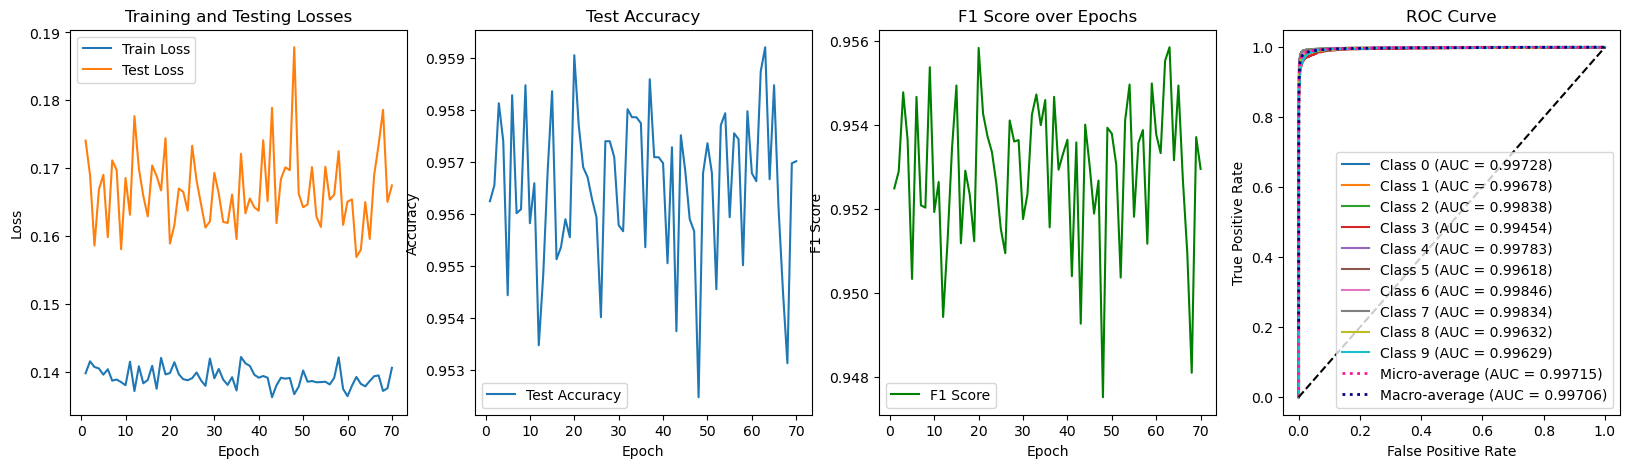

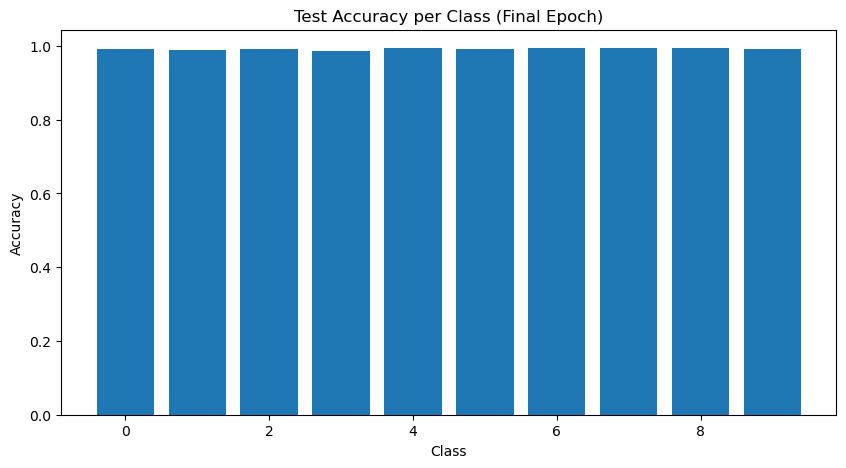

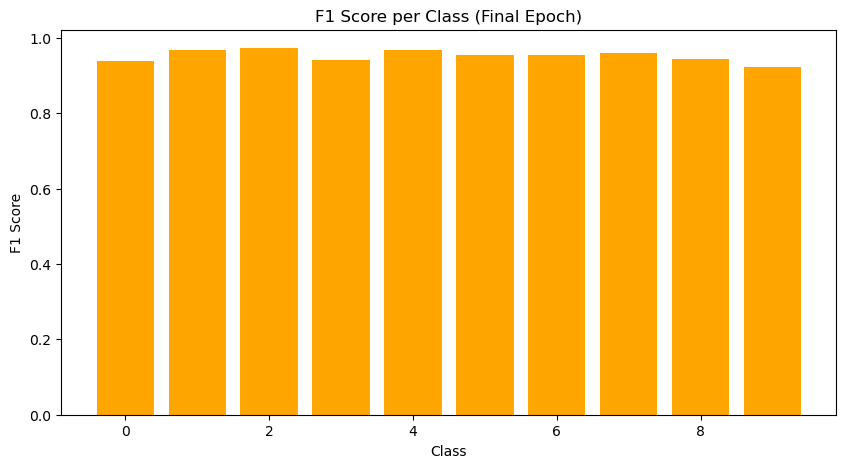

Confusion Matrix:
[[1708    7    4    2    0    4    8    6    3    2]
 [  48 4898   27   16   44    6    8   44    4    4]
 [   6   18 4056   22    9    5    3   16    6    8]
 [   9   15   23 2650    4   44    9    6   28   94]
 [  14   19   11    8 2453    3    2    4    3    6]
 [   8    9   12   28    4 2260   36    4   11   12]
 [  30   11    0    2    7   11 1895    0   20    1]
 [   3   36   26    7    5    2    0 1938    1    1]
 [  16    6    5   11    6    4   32    0 1566   14]
 [  47    5   21    6    6    6    1    2   12 1489]]


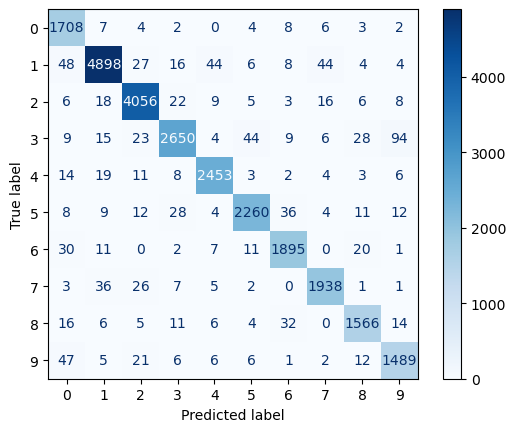

In [41]:
plot_results(train_losses_3_5_1 , test_losses_3_5_1 , test_accuracy_3_5_1 , test_f1_3_5_1, all_labels_3_5_1 , all_preds_3_5_1 , all_probs_3_5_1 , num_epochs, 10)

### Rotation = 30

In [42]:
train_transform_3_5_2 = SVHNAugmentation(30, (1.0,1.0), (0.75,1.33))

# Load the training dataset
train_dataset_3_5_2 = datasets.SVHN(root='./data', split='train', download=True, transform=train_transform_3_5_2)
train_loader_3_5_2 = DataLoader(train_dataset, batch_size=128, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat


In [43]:
train_losses_3_5_2, test_losses_3_5_2, test_accuracy_3_5_2, test_f1_3_5_2, all_labels_3_5_2, all_preds_3_5_2, all_probs_3_5_2 = train_and_evaluate(model, train_loader_3_5_2, test_loader, criterion, optimizer, num_epochs, "rot30")
initial_results_3_5_2 = (train_losses_3_5_2, test_losses_3_5_2, test_accuracy_3_5_2, test_f1_3_5_2, all_labels_3_5_2, all_preds_3_5_2, all_probs_3_5_2)

100%|██████████| 573/573 [00:07<00:00, 74.61it/s]


Epoch [1/70], Train Loss: 0.1390, Test Loss: 0.1650, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.72it/s]


Epoch [2/70], Train Loss: 0.1362, Test Loss: 0.1569, Test Accuracy: 0.9597


100%|██████████| 573/573 [00:07<00:00, 74.46it/s]


Epoch [3/70], Train Loss: 0.1371, Test Loss: 0.1651, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 75.15it/s]


Epoch [4/70], Train Loss: 0.1408, Test Loss: 0.1665, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 75.17it/s]


Epoch [5/70], Train Loss: 0.1388, Test Loss: 0.1653, Test Accuracy: 0.9560


100%|██████████| 573/573 [00:07<00:00, 74.28it/s]


Epoch [6/70], Train Loss: 0.1391, Test Loss: 0.1692, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [7/70], Train Loss: 0.1361, Test Loss: 0.1621, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 74.49it/s]


Epoch [8/70], Train Loss: 0.1387, Test Loss: 0.1661, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.86it/s]


Epoch [9/70], Train Loss: 0.1406, Test Loss: 0.1649, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.70it/s]


Epoch [10/70], Train Loss: 0.1369, Test Loss: 0.1684, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.57it/s]


Epoch [11/70], Train Loss: 0.1375, Test Loss: 0.1727, Test Accuracy: 0.9555


100%|██████████| 573/573 [00:07<00:00, 74.54it/s]


Epoch [12/70], Train Loss: 0.1361, Test Loss: 0.1604, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.52it/s]


Epoch [13/70], Train Loss: 0.1377, Test Loss: 0.1589, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.81it/s]


Epoch [14/70], Train Loss: 0.1356, Test Loss: 0.1687, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.73it/s]


Epoch [15/70], Train Loss: 0.1393, Test Loss: 0.1611, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 74.45it/s]


Epoch [16/70], Train Loss: 0.1391, Test Loss: 0.1638, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.57it/s]


Epoch [17/70], Train Loss: 0.1377, Test Loss: 0.1666, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.51it/s]


Epoch [18/70], Train Loss: 0.1372, Test Loss: 0.1622, Test Accuracy: 0.9592


100%|██████████| 573/573 [00:07<00:00, 74.42it/s]


Epoch [19/70], Train Loss: 0.1381, Test Loss: 0.1611, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.86it/s]


Epoch [20/70], Train Loss: 0.1385, Test Loss: 0.1635, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.84it/s]


Epoch [21/70], Train Loss: 0.1372, Test Loss: 0.1631, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 74.48it/s]


Epoch [22/70], Train Loss: 0.1389, Test Loss: 0.1618, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.63it/s]


Epoch [23/70], Train Loss: 0.1389, Test Loss: 0.1650, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.32it/s]


Epoch [24/70], Train Loss: 0.1380, Test Loss: 0.1662, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.54it/s]


Epoch [25/70], Train Loss: 0.1402, Test Loss: 0.1663, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 73.19it/s]


Epoch [26/70], Train Loss: 0.1374, Test Loss: 0.1608, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 73.43it/s]


Epoch [27/70], Train Loss: 0.1387, Test Loss: 0.1621, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.71it/s]


Epoch [28/70], Train Loss: 0.1396, Test Loss: 0.1697, Test Accuracy: 0.9547


100%|██████████| 573/573 [00:07<00:00, 74.39it/s]


Epoch [29/70], Train Loss: 0.1369, Test Loss: 0.1594, Test Accuracy: 0.9597


100%|██████████| 573/573 [00:07<00:00, 74.22it/s]


Epoch [30/70], Train Loss: 0.1398, Test Loss: 0.1634, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.47it/s]


Epoch [31/70], Train Loss: 0.1370, Test Loss: 0.1574, Test Accuracy: 0.9588


100%|██████████| 573/573 [00:07<00:00, 74.71it/s]


Epoch [32/70], Train Loss: 0.1354, Test Loss: 0.1689, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.78it/s]


Epoch [33/70], Train Loss: 0.1390, Test Loss: 0.1596, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 74.32it/s]


Epoch [34/70], Train Loss: 0.1397, Test Loss: 0.1707, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 73.69it/s]


Epoch [35/70], Train Loss: 0.1408, Test Loss: 0.1680, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.11it/s]


Epoch [36/70], Train Loss: 0.1371, Test Loss: 0.1703, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.17it/s]


Epoch [37/70], Train Loss: 0.1373, Test Loss: 0.1588, Test Accuracy: 0.9588


100%|██████████| 573/573 [00:07<00:00, 74.07it/s]


Epoch [38/70], Train Loss: 0.1387, Test Loss: 0.1647, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.21it/s]


Epoch [39/70], Train Loss: 0.1356, Test Loss: 0.1642, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.59it/s]


Epoch [40/70], Train Loss: 0.1383, Test Loss: 0.1655, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 74.10it/s]


Epoch [41/70], Train Loss: 0.1399, Test Loss: 0.1564, Test Accuracy: 0.9599


100%|██████████| 573/573 [00:07<00:00, 73.92it/s]


Epoch [42/70], Train Loss: 0.1392, Test Loss: 0.1606, Test Accuracy: 0.9591


100%|██████████| 573/573 [00:07<00:00, 73.92it/s]


Epoch [43/70], Train Loss: 0.1395, Test Loss: 0.1673, Test Accuracy: 0.9571


100%|██████████| 573/573 [00:07<00:00, 74.51it/s]


Epoch [44/70], Train Loss: 0.1379, Test Loss: 0.1609, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.59it/s]


Epoch [45/70], Train Loss: 0.1355, Test Loss: 0.1604, Test Accuracy: 0.9594


100%|██████████| 573/573 [00:07<00:00, 74.71it/s]


Epoch [46/70], Train Loss: 0.1372, Test Loss: 0.1640, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.59it/s]


Epoch [47/70], Train Loss: 0.1380, Test Loss: 0.1590, Test Accuracy: 0.9592


100%|██████████| 573/573 [00:07<00:00, 72.97it/s]


Epoch [48/70], Train Loss: 0.1399, Test Loss: 0.1678, Test Accuracy: 0.9565


100%|██████████| 573/573 [00:07<00:00, 71.79it/s]


Epoch [49/70], Train Loss: 0.1389, Test Loss: 0.1631, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 72.98it/s]


Epoch [50/70], Train Loss: 0.1374, Test Loss: 0.1651, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 72.55it/s]


Epoch [51/70], Train Loss: 0.1390, Test Loss: 0.1593, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:08<00:00, 71.06it/s]


Epoch [52/70], Train Loss: 0.1377, Test Loss: 0.1607, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 72.80it/s]


Epoch [53/70], Train Loss: 0.1370, Test Loss: 0.1579, Test Accuracy: 0.9589


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [54/70], Train Loss: 0.1370, Test Loss: 0.1633, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.00it/s]


Epoch [55/70], Train Loss: 0.1387, Test Loss: 0.1596, Test Accuracy: 0.9592


100%|██████████| 573/573 [00:07<00:00, 74.51it/s]


Epoch [56/70], Train Loss: 0.1401, Test Loss: 0.1734, Test Accuracy: 0.9546


100%|██████████| 573/573 [00:07<00:00, 74.18it/s]


Epoch [57/70], Train Loss: 0.1397, Test Loss: 0.1682, Test Accuracy: 0.9561


100%|██████████| 573/573 [00:07<00:00, 74.93it/s]


Epoch [58/70], Train Loss: 0.1371, Test Loss: 0.1663, Test Accuracy: 0.9584


100%|██████████| 573/573 [00:07<00:00, 74.15it/s]


Epoch [59/70], Train Loss: 0.1362, Test Loss: 0.1627, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.48it/s]


Epoch [60/70], Train Loss: 0.1383, Test Loss: 0.1639, Test Accuracy: 0.9575


100%|██████████| 573/573 [00:07<00:00, 73.81it/s]


Epoch [61/70], Train Loss: 0.1370, Test Loss: 0.1610, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.27it/s]


Epoch [62/70], Train Loss: 0.1379, Test Loss: 0.1638, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.42it/s]


Epoch [63/70], Train Loss: 0.1364, Test Loss: 0.1613, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.56it/s]


Epoch [64/70], Train Loss: 0.1366, Test Loss: 0.1710, Test Accuracy: 0.9550


100%|██████████| 573/573 [00:07<00:00, 74.29it/s]


Epoch [65/70], Train Loss: 0.1386, Test Loss: 0.1633, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.67it/s]


Epoch [66/70], Train Loss: 0.1387, Test Loss: 0.1597, Test Accuracy: 0.9576


100%|██████████| 573/573 [00:07<00:00, 74.52it/s]


Epoch [67/70], Train Loss: 0.1381, Test Loss: 0.1634, Test Accuracy: 0.9568


100%|██████████| 573/573 [00:07<00:00, 74.51it/s]


Epoch [68/70], Train Loss: 0.1384, Test Loss: 0.1608, Test Accuracy: 0.9568


100%|██████████| 573/573 [00:07<00:00, 74.61it/s]


Epoch [69/70], Train Loss: 0.1374, Test Loss: 0.1715, Test Accuracy: 0.9552


100%|██████████| 573/573 [00:07<00:00, 74.71it/s]


Epoch [70/70], Train Loss: 0.1372, Test Loss: 0.1643, Test Accuracy: 0.9564


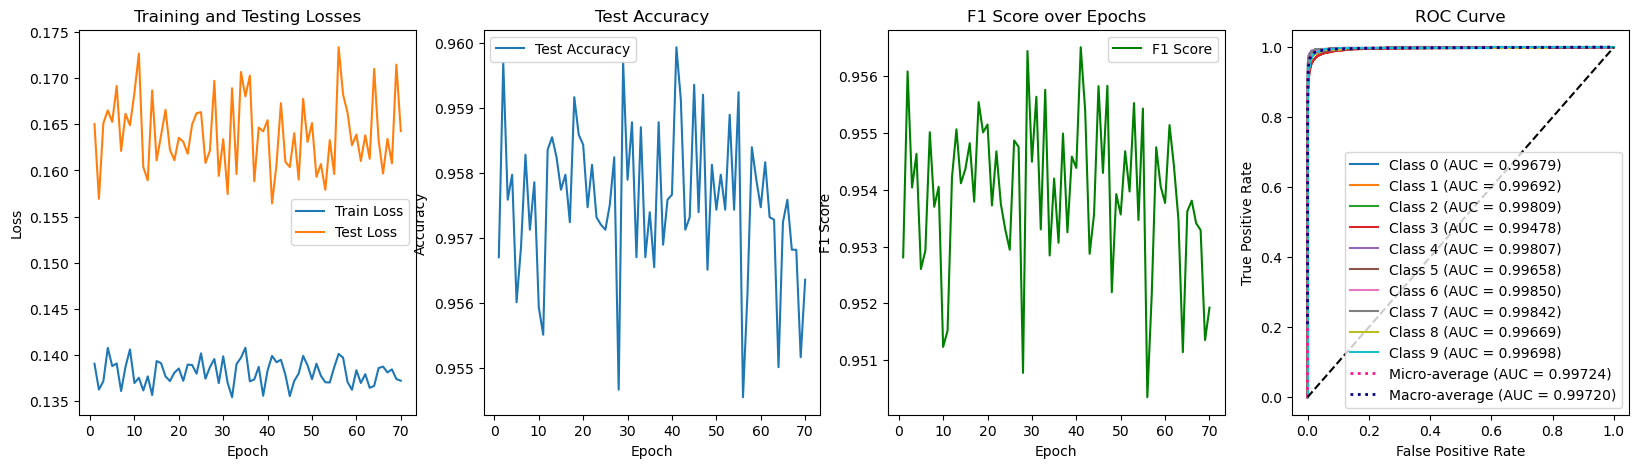

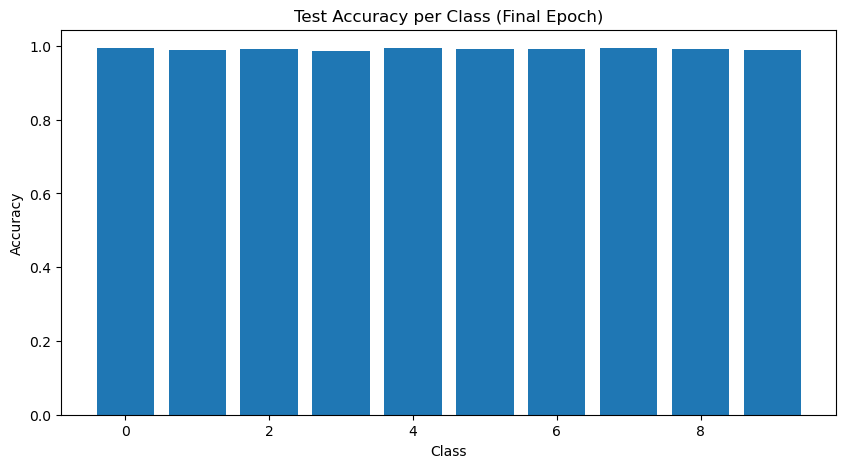

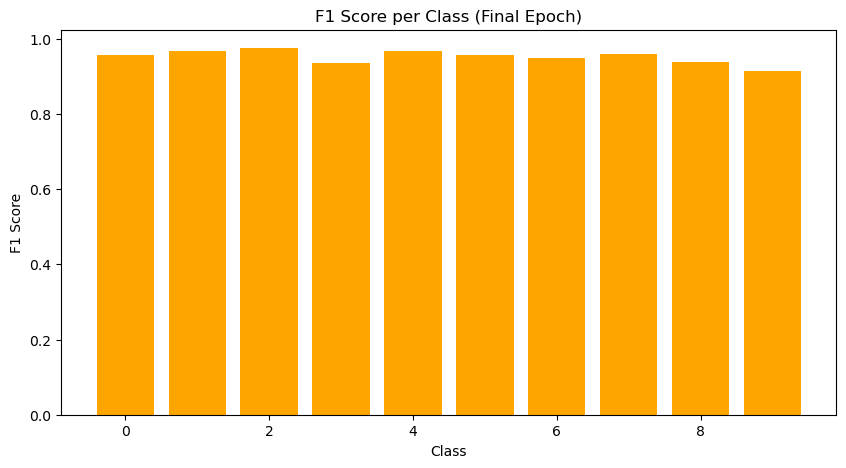

Confusion Matrix:
[[1664   11    4    5    3    4   21    7    9   16]
 [  20 4906   24   20   44    7   10   51    8    9]
 [   4   17 4036   29   13    6    5   18    4   17]
 [   6   12   13 2633    8   46    6   11   32  115]
 [   4   19    6    7 2463    1    5    4    3   11]
 [   4    8    7   26    3 2268   39    3   13   13]
 [   7    9    1    3    6   17 1913    1   19    1]
 [   1   41   17    1    6    0    1 1947    0    5]
 [   6    6    6   11   10    5   45    0 1550   21]
 [  22    5   14    5    7    6    9    3    8 1516]]


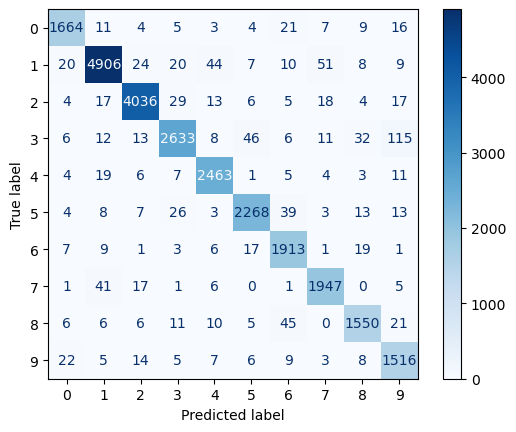

In [44]:
plot_results(train_losses_3_5_2 , test_losses_3_5_2 , test_accuracy_3_5_2 , test_f1_3_5_2, all_labels_3_5_2 , all_preds_3_5_2 , all_probs_3_5_2 , num_epochs, 10)

## 3.6 Crop Scale Range (Initial = 1.0,1.0)

### Crop Scale Range = (0.8,1.0)

In [45]:
train_transform_3_6_1 = SVHNAugmentation(0, (0.8,1.0), (0.75,1.33))

# Load the training dataset
train_dataset_3_6_1 = datasets.SVHN(root='./data', split='train', download=True, transform=train_transform_3_6_1)
train_loader_3_6_1 = DataLoader(train_dataset, batch_size=128, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat


In [46]:
train_losses_3_6_1, test_losses_3_6_1, test_accuracy_3_6_1, test_f1_3_6_1, all_labels_3_6_1, all_preds_3_6_1, all_probs_3_6_1 = train_and_evaluate(model, train_loader_3_6_1, test_loader, criterion, optimizer, num_epochs, "csr0.8")
initial_results_3_6_1 = (train_losses_3_6_1, test_losses_3_6_1, test_accuracy_3_6_1, test_f1_3_6_1, all_labels_3_6_1, all_preds_3_6_1, all_probs_3_6_1)

100%|██████████| 573/573 [00:07<00:00, 73.84it/s]


Epoch [1/70], Train Loss: 0.1368, Test Loss: 0.1700, Test Accuracy: 0.9556


100%|██████████| 573/573 [00:07<00:00, 74.71it/s]


Epoch [2/70], Train Loss: 0.1376, Test Loss: 0.1642, Test Accuracy: 0.9564


100%|██████████| 573/573 [00:07<00:00, 74.21it/s]


Epoch [3/70], Train Loss: 0.1361, Test Loss: 0.1651, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 74.20it/s]


Epoch [4/70], Train Loss: 0.1367, Test Loss: 0.1644, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 73.97it/s]


Epoch [5/70], Train Loss: 0.1387, Test Loss: 0.1594, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [6/70], Train Loss: 0.1380, Test Loss: 0.1662, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 74.40it/s]


Epoch [7/70], Train Loss: 0.1380, Test Loss: 0.1666, Test Accuracy: 0.9564


100%|██████████| 573/573 [00:07<00:00, 74.08it/s]


Epoch [8/70], Train Loss: 0.1384, Test Loss: 0.1673, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.46it/s]


Epoch [9/70], Train Loss: 0.1381, Test Loss: 0.1720, Test Accuracy: 0.9550


100%|██████████| 573/573 [00:07<00:00, 74.56it/s]


Epoch [10/70], Train Loss: 0.1380, Test Loss: 0.1620, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 74.15it/s]


Epoch [11/70], Train Loss: 0.1356, Test Loss: 0.1663, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 74.76it/s]


Epoch [12/70], Train Loss: 0.1390, Test Loss: 0.1642, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.81it/s]


Epoch [13/70], Train Loss: 0.1382, Test Loss: 0.1621, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:08<00:00, 71.28it/s]


Epoch [14/70], Train Loss: 0.1382, Test Loss: 0.1657, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.92it/s]


Epoch [15/70], Train Loss: 0.1362, Test Loss: 0.1628, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.81it/s]


Epoch [16/70], Train Loss: 0.1407, Test Loss: 0.1620, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.09it/s]


Epoch [17/70], Train Loss: 0.1347, Test Loss: 0.1638, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 73.75it/s]


Epoch [18/70], Train Loss: 0.1394, Test Loss: 0.1574, Test Accuracy: 0.9592


100%|██████████| 573/573 [00:07<00:00, 74.14it/s]


Epoch [19/70], Train Loss: 0.1375, Test Loss: 0.1692, Test Accuracy: 0.9554


100%|██████████| 573/573 [00:07<00:00, 74.73it/s]


Epoch [20/70], Train Loss: 0.1355, Test Loss: 0.1612, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.28it/s]


Epoch [21/70], Train Loss: 0.1378, Test Loss: 0.1641, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 74.84it/s]


Epoch [22/70], Train Loss: 0.1387, Test Loss: 0.1736, Test Accuracy: 0.9545


100%|██████████| 573/573 [00:07<00:00, 74.66it/s]


Epoch [23/70], Train Loss: 0.1360, Test Loss: 0.1670, Test Accuracy: 0.9555


100%|██████████| 573/573 [00:07<00:00, 74.39it/s]


Epoch [24/70], Train Loss: 0.1402, Test Loss: 0.1683, Test Accuracy: 0.9562


100%|██████████| 573/573 [00:07<00:00, 74.55it/s]


Epoch [25/70], Train Loss: 0.1375, Test Loss: 0.1674, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.44it/s]


Epoch [26/70], Train Loss: 0.1384, Test Loss: 0.1717, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.42it/s]


Epoch [27/70], Train Loss: 0.1358, Test Loss: 0.1657, Test Accuracy: 0.9578


100%|██████████| 573/573 [00:07<00:00, 74.39it/s]


Epoch [28/70], Train Loss: 0.1367, Test Loss: 0.1689, Test Accuracy: 0.9564


100%|██████████| 573/573 [00:07<00:00, 74.10it/s]


Epoch [29/70], Train Loss: 0.1374, Test Loss: 0.1655, Test Accuracy: 0.9568


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [30/70], Train Loss: 0.1368, Test Loss: 0.1671, Test Accuracy: 0.9565


100%|██████████| 573/573 [00:07<00:00, 74.47it/s]


Epoch [31/70], Train Loss: 0.1372, Test Loss: 0.1716, Test Accuracy: 0.9561


100%|██████████| 573/573 [00:07<00:00, 74.34it/s]


Epoch [32/70], Train Loss: 0.1399, Test Loss: 0.1661, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.26it/s]


Epoch [33/70], Train Loss: 0.1360, Test Loss: 0.1646, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.61it/s]


Epoch [34/70], Train Loss: 0.1360, Test Loss: 0.1671, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.75it/s]


Epoch [35/70], Train Loss: 0.1367, Test Loss: 0.1671, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.90it/s]


Epoch [36/70], Train Loss: 0.1366, Test Loss: 0.1765, Test Accuracy: 0.9534


100%|██████████| 573/573 [00:07<00:00, 74.18it/s]


Epoch [37/70], Train Loss: 0.1366, Test Loss: 0.1640, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.49it/s]


Epoch [38/70], Train Loss: 0.1368, Test Loss: 0.1656, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 74.57it/s]


Epoch [39/70], Train Loss: 0.1366, Test Loss: 0.1723, Test Accuracy: 0.9548


100%|██████████| 573/573 [00:07<00:00, 74.47it/s]


Epoch [40/70], Train Loss: 0.1370, Test Loss: 0.1652, Test Accuracy: 0.9565


100%|██████████| 573/573 [00:07<00:00, 74.25it/s]


Epoch [41/70], Train Loss: 0.1391, Test Loss: 0.1620, Test Accuracy: 0.9588


100%|██████████| 573/573 [00:07<00:00, 74.86it/s]


Epoch [42/70], Train Loss: 0.1373, Test Loss: 0.1576, Test Accuracy: 0.9586


100%|██████████| 573/573 [00:07<00:00, 74.74it/s]


Epoch [43/70], Train Loss: 0.1365, Test Loss: 0.1738, Test Accuracy: 0.9546


100%|██████████| 573/573 [00:07<00:00, 74.44it/s]


Epoch [44/70], Train Loss: 0.1380, Test Loss: 0.1585, Test Accuracy: 0.9587


100%|██████████| 573/573 [00:07<00:00, 74.40it/s]


Epoch [45/70], Train Loss: 0.1377, Test Loss: 0.1605, Test Accuracy: 0.9588


100%|██████████| 573/573 [00:07<00:00, 74.27it/s]


Epoch [46/70], Train Loss: 0.1356, Test Loss: 0.1614, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.24it/s]


Epoch [47/70], Train Loss: 0.1378, Test Loss: 0.1666, Test Accuracy: 0.9577


100%|██████████| 573/573 [00:07<00:00, 75.08it/s]


Epoch [48/70], Train Loss: 0.1384, Test Loss: 0.1633, Test Accuracy: 0.9581


100%|██████████| 573/573 [00:07<00:00, 74.75it/s]


Epoch [49/70], Train Loss: 0.1386, Test Loss: 0.1633, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.22it/s]


Epoch [50/70], Train Loss: 0.1381, Test Loss: 0.1641, Test Accuracy: 0.9572


100%|██████████| 573/573 [00:07<00:00, 74.18it/s]


Epoch [51/70], Train Loss: 0.1376, Test Loss: 0.1627, Test Accuracy: 0.9579


100%|██████████| 573/573 [00:07<00:00, 74.40it/s]


Epoch [52/70], Train Loss: 0.1378, Test Loss: 0.1671, Test Accuracy: 0.9559


100%|██████████| 573/573 [00:07<00:00, 74.12it/s]


Epoch [53/70], Train Loss: 0.1364, Test Loss: 0.1636, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.84it/s]


Epoch [54/70], Train Loss: 0.1388, Test Loss: 0.1611, Test Accuracy: 0.9582


100%|██████████| 573/573 [00:07<00:00, 74.63it/s]


Epoch [55/70], Train Loss: 0.1372, Test Loss: 0.1638, Test Accuracy: 0.9573


100%|██████████| 573/573 [00:07<00:00, 74.08it/s]


Epoch [56/70], Train Loss: 0.1380, Test Loss: 0.1674, Test Accuracy: 0.9566


100%|██████████| 573/573 [00:07<00:00, 74.63it/s]


Epoch [57/70], Train Loss: 0.1359, Test Loss: 0.1617, Test Accuracy: 0.9583


100%|██████████| 573/573 [00:07<00:00, 74.43it/s]


Epoch [58/70], Train Loss: 0.1400, Test Loss: 0.1591, Test Accuracy: 0.9585


100%|██████████| 573/573 [00:07<00:00, 74.69it/s]


Epoch [59/70], Train Loss: 0.1364, Test Loss: 0.1644, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 74.31it/s]


Epoch [60/70], Train Loss: 0.1392, Test Loss: 0.1593, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.42it/s]


Epoch [61/70], Train Loss: 0.1335, Test Loss: 0.1647, Test Accuracy: 0.9580


100%|██████████| 573/573 [00:07<00:00, 74.30it/s]


Epoch [62/70], Train Loss: 0.1362, Test Loss: 0.1689, Test Accuracy: 0.9557


100%|██████████| 573/573 [00:07<00:00, 74.06it/s]


Epoch [63/70], Train Loss: 0.1394, Test Loss: 0.1620, Test Accuracy: 0.9563


100%|██████████| 573/573 [00:07<00:00, 74.36it/s]


Epoch [64/70], Train Loss: 0.1366, Test Loss: 0.1630, Test Accuracy: 0.9574


100%|██████████| 573/573 [00:07<00:00, 74.34it/s]


Epoch [65/70], Train Loss: 0.1354, Test Loss: 0.1683, Test Accuracy: 0.9570


100%|██████████| 573/573 [00:07<00:00, 73.87it/s]


Epoch [66/70], Train Loss: 0.1365, Test Loss: 0.1731, Test Accuracy: 0.9556


100%|██████████| 573/573 [00:07<00:00, 74.64it/s]


Epoch [67/70], Train Loss: 0.1366, Test Loss: 0.1624, Test Accuracy: 0.9569


100%|██████████| 573/573 [00:07<00:00, 74.42it/s]


Epoch [68/70], Train Loss: 0.1387, Test Loss: 0.1675, Test Accuracy: 0.9567


100%|██████████| 573/573 [00:07<00:00, 74.45it/s]


Epoch [69/70], Train Loss: 0.1354, Test Loss: 0.1741, Test Accuracy: 0.9554


100%|██████████| 573/573 [00:07<00:00, 74.48it/s]


Epoch [70/70], Train Loss: 0.1355, Test Loss: 0.1599, Test Accuracy: 0.9573


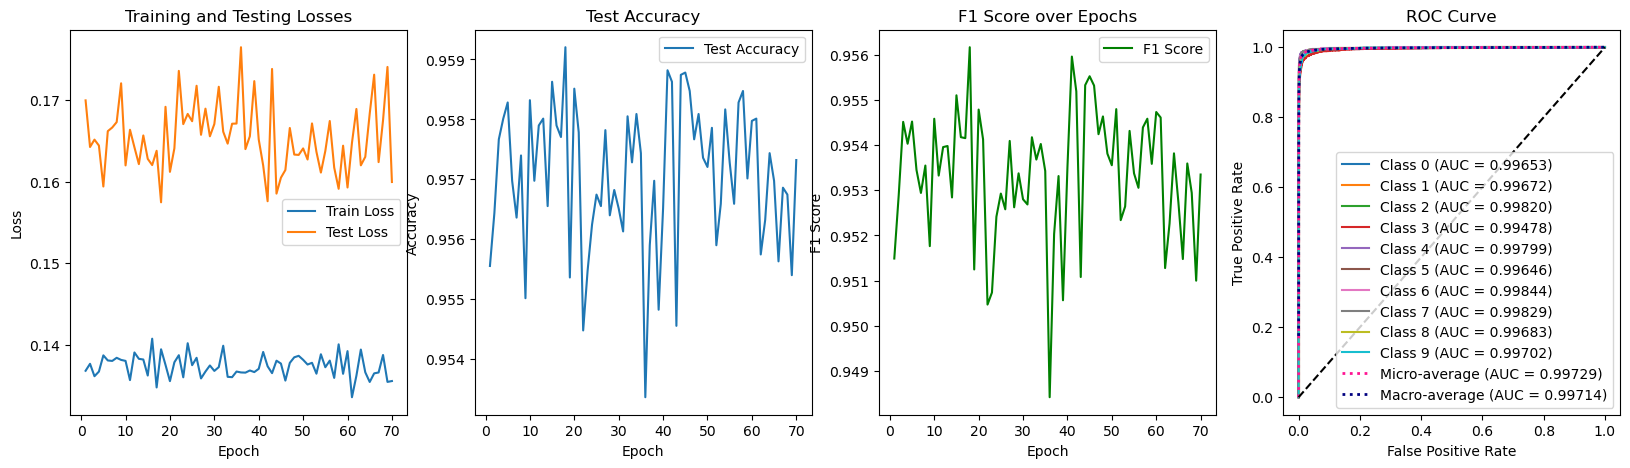

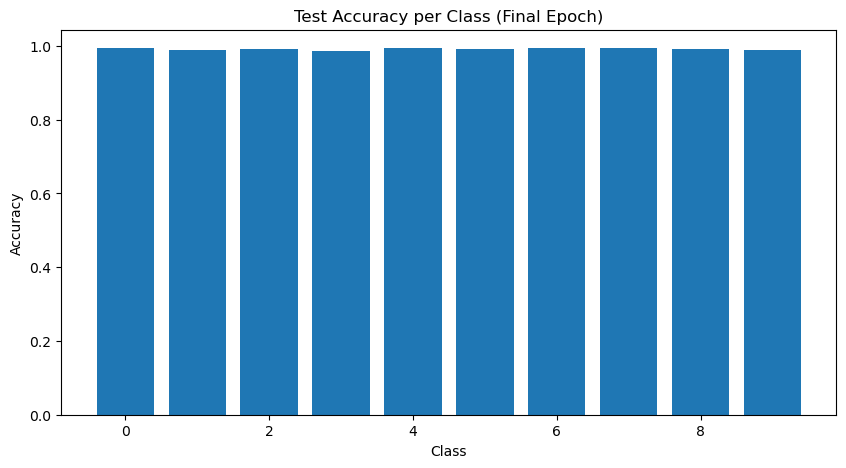

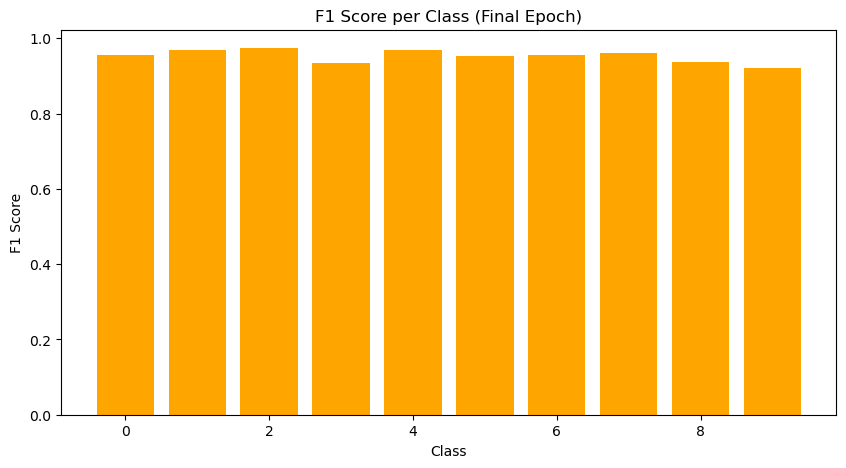

Confusion Matrix:
[[1666   15    6   13    1    5   15    5    6   12]
 [  18 4954   16   22   32    9    7   32    5    4]
 [   4   25 4018   39    7   10    5   27    4   10]
 [   3   14   11 2689    5   41    3    4   11  101]
 [   5   22    9   14 2445    4    2    4   10    8]
 [   3    9    7   39    3 2275   17    3   13   15]
 [  11   16    2    8    6   23 1875    1   34    1]
 [   1   51    9    7    8    1    0 1938    0    4]
 [  12   10    7   20    5   14   22    2 1545   23]
 [  23    7   15   16    5    4    4    0    5 1516]]


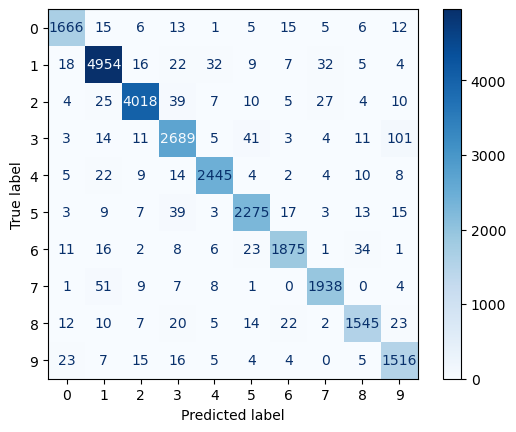

In [47]:
plot_results(train_losses_3_6_1 , test_losses_3_6_1 , test_accuracy_3_6_1 , test_f1_3_6_1, all_labels_3_6_1 , all_preds_3_6_1 , all_probs_3_6_1 , num_epochs, 10)